# <center>Réalisez une analyse de sentiments grâce au Deep Learning</center>

# Introduction

Dans le cadre de notre collaboration avec **Air Paradis**, une compagnie aérienne, notre objectif est de développer un produit **IA** permettant de prédire les sentiments des tweets associés à la marque. **Air Paradis** souhaite anticiper les **bad buzz** sur les réseaux sociaux afin d'améliorer son image de marque et de mieux réagir face aux tweets négatifs.

## Contexte

Le projet consiste à construire un prototype de modèle **IA** capable de prédire si un tweet exprime un sentiment **négatif** ou **non**. Les données disponibles sont issues de sources **open source**, comprenant des informations sur les tweets comme l'utilisateur ayant posté, le contenu du tweet et le moment du post. Chaque tweet est également accompagné d'un **label binaire** indiquant si le tweet est négatif ou non.


# Sommaire :

**Introduction**
  
**Partie 1 : Chargement des données et des bibliothèques**

   - <a href="#C1">Importation des données et des librairies</a>
 
**Partie 2 : Analyse exploratoire et prétraitement des textes**
   - <a href="#C2">1. Exploration des données</a>
   - <a href="#C3">2. Prétraitement</a>
   
**Partie 3 : Méthodologies de Modélisation**   

   - <a href="#C4">1. Modèle sur Mesure Simple:Régression logistique</a>
   - <a href="#C5">2 Modèle sur Mesure Avancé:Réseaux de neurones profonds pour prédire les sentiments</a>
       - <a href="#C6">2.1 LSTM avec apprentissage des embeddings à partir des données.</a>
       - <a href="#C7">2.2 LSTM et embeddings GloVe pré-entraînés.</a>
       - <a href="#C8">2.3 Modèle LSTM avec Word2Vec (Non Préentraîné) </a>
       - <a href="#C9">2.4 Expérimentation avec le modèle **BERT**</a>
   - <a href="#C10">3.Mise en Œuvre de l'API et du Déploiement</a>

# Partie 1 : Chargement des données et des bibliothèques
## <a href="#C1">Importation des données et Import des librairies</a>

In [20]:
# Data manipulation and computation
import numpy as np
import pandas as pd
import pickle
import joblib

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Natural Language Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer

# Machine Learning and Deep Learning
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, log_loss, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# MLflow and model tracking
import mlflow
import mlflow.sklearn
import mlflow.keras
import mlflow.tensorflow

# Word Embeddings (e.g., Word2Vec)
from gensim.models import Word2Vec

# Progress bar
from tqdm import tqdm


## <a href="C2">2. Exploration

In [93]:
import pandas as pd
# Charger les données
data = pd.read_csv("training.1600000.processed.noemoticon.csv", header=None, encoding="ISO-8859-1")
data.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
print("Le fichier contient", len(data), "lignes.")
# Compter les lignes dupliquées basées sur la colonne 'id'
nb_duplicated_id = data.duplicated(subset=['id']).sum()
print(f"Nombre de lignes dupliquées selon 'id' : {nb_duplicated_id}")
# Compter le nombre d'utilisateurs uniques
nb_users = data['user'].nunique()
print(f"Nombre d'utilisateurs uniques : {nb_users}")
# Compter le nombre de NaN dans la colonne "target"
nb_nan = data['target'].isna().sum()

print(f"Nombre de NaN dans la colonne 'target' : {nb_nan}")



Le fichier contient 1600000 lignes.
Nombre de lignes dupliquées selon 'id' : 1685
Nombre d'utilisateurs uniques : 659775
Nombre de NaN dans la colonne 'target' : 0


In [94]:
print(print(data['id'].nunique())  
)
print(data.id.value_counts())
display(data.loc[data.id==2190457769,:])

1598315
None
id
2190457769    2
1972193428    2
1989776729    2
1989776908    2
1564543229    2
             ..
2197311196    1
2197311146    1
2197310899    1
2197310477    1
2193602129    1
Name: count, Length: 1598315, dtype: int64


target          id                          date      flag  \
513734        0  2190457769  Tue Jun 16 02:47:11 PDT 2009  NO_QUERY   
1583635       4  2190457769  Tue Jun 16 02:47:11 PDT 2009  NO_QUERY   

              user                                               text  
513734   mam1cutie  @berntina I know I thought it was great.. 3 te...  
1583635  mam1cutie  @berntina I know I thought it was great.. 3 te...

On a quelques doublons avec des target différents 

In [95]:
# Supprimer complètement les tweets dupliqués
data = data[~data.duplicated(subset=['text'], keep=False)]

# Vérifier le nombre de lignes après suppression
print(f"Le DataFrame après suppression des tweets dupliqués contient {len(data)} lignes.")


Le DataFrame après suppression des tweets dupliqués contient 1573032 lignes.


In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud



# Filtrer les colonnes nécessaires
data = data[['target', 'text']]

# Vérification des classes
print(data['target'].value_counts())

# Conversion des classes 
data['target'] = data['target'].apply(lambda x: 1 if x == 4 else 0)  # 4 = positif, 0 = négatif

# Vérification des textes vides
# Vérifier si 'text' est vide ou contient uniquement des espaces
missing_texts = data[data['text'].isnull() | (data['text'].str.strip() == '')]

# Afficher le nombre de textes vides
print(f"Nombre de textes vides ou manquants : {len(missing_texts)}")

# les indices ou les textes vides eux-mêmes
print("Exemples de textes vides ou manquants :")
print(missing_texts.head())

# supprimer ces lignes de textes vides 
data = data.dropna(subset=['text'])  # Supprimer les lignes où 'text' est manquant
data = data[data['text'].str.strip() != '']  # Supprimer les lignes avec des textes vides

# Vérification du DataFrame nettoyé
print(f"Le DataFrame nettoyé contient {len(data)} lignes après suppression des textes vides.")



target
4    788715
0    784317
Name: count, dtype: int64
Nombre de textes vides ou manquants : 0
Exemples de textes vides ou manquants :
Empty DataFrame
Columns: [target, text]
Index: []
Le DataFrame nettoyé contient 1573032 lignes après suppression des textes vides.


Text(0.5, 1.0, 'Distribution du nombre de caractères des tweets')

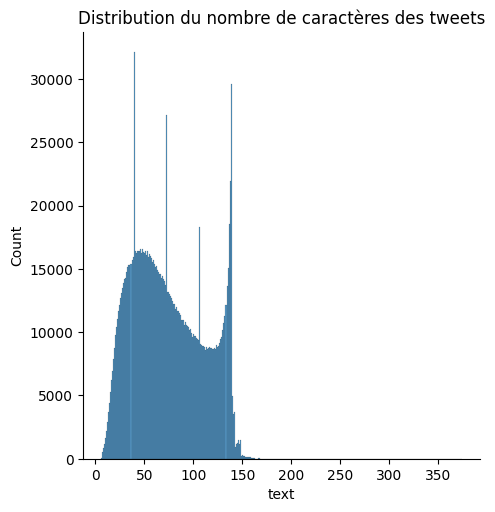

In [97]:
tmp = data.text.str.len()
sns.displot(tmp)
plt.title("Distribution du nombre de caractères des tweets")

In [ ]:
plt.figure(figsize=(8,5))
sns.ecdfplot(tmp, color="darkorange")
plt.title("Fonction de Répartition Cumulative (CDF) des longueurs des tweets")
plt.xlabel("Nombre de caractères")
plt.ylabel("Proportion cumulative")
plt.grid(True)
plt.show()


## <a href="C3">2. Prétraitement des textes

In [98]:
def filter_tweet(df):
    """
    Filtre et supprime les tweets non informatifs et affiche les premières lignes supprimées.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame filtré.
    """
    df['text'] = df['text'].str.strip()
    filtered_df = df[df['text'].str.match('^(@\w+\s*)+$')]
    df = df.drop(filtered_df.index, axis= 0)
    display(filtered_df.head(20))
    print(f"Nombre de tweets non informatif supprimés : {filtered_df.shape[0]}")
    return df
filter_tweet(data)    

<>:10: SyntaxWarning: invalid escape sequence '\w'
<>:10: SyntaxWarning: invalid escape sequence '\w'
C:\Users\attia\AppData\Local\Temp\ipykernel_126136\3690200661.py:10: SyntaxWarning: invalid escape sequence '\w'
  filtered_df = df[df['text'].str.match('^(@\w+\s*)+$')]


target              text
208         0         @mandayyy
249         0         @mandayyy
430         0         @anistorm
1011        0     @citizensheep
1014        0   @GirlsGoneChild
1231        0    @thecoolestout
1421        0   @marlonjenglish
1486        0       @oishiieats
1641        0       @thisisguan
2898        0         @AnotherA
4377        0  @TheBlondeTheory
4508        0      @_EmilyYoung
6058        0     @Tnkdifferent
6419        0   @whiterobisdead
7840        0        @reinmouse
8838        0           @wunmic
9072        0    @theropolitans
9556        0     @whatkilesaid
9599        0     @CHELLETASTIC
10625       0      @wichitarecs

Nombre de tweets non informatif supprimés : 2436


target                                               text
0             0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1             0  is upset that he can't update his Facebook by ...
2             0  @Kenichan I dived many times for the ball. Man...
3             0     my whole body feels itchy and like its on fire
4             0  @nationwideclass no, it's not behaving at all....
...         ...                                                ...
1599995       1  Just woke up. Having no school is the best fee...
1599996       1  TheWDB.com - Very cool to hear old Walt interv...
1599997       1  Are you ready for your MoJo Makeover? Ask me f...
1599998       1  Happy 38th Birthday to my boo of alll time!!! ...
1599999       1  happy #charitytuesday @theNSPCC @SparksCharity...

[1570596 rows x 2 columns]

In [99]:
tweets_air_paradis = data[data['text'].str.contains("Air Paradis", case=False, na=False)]
tweets_air_paradis

Empty DataFrame
Columns: [target, text]
Index: []

Répartition des classes (en pourcentage) :
target
1    0.501398
0    0.498602
Name: proportion, dtype: float64


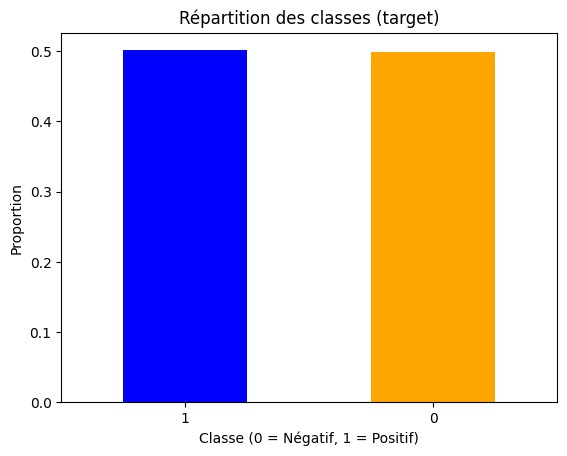

Les données ne semblent pas trop déséquilibrées.


In [100]:
import pandas as pd

# Afficher la répartition des classes dans la colonne 'target'
class_distribution = data['target'].value_counts(normalize=True)  # normalize=True donne les pourcentages
print("Répartition des classes (en pourcentage) :")
print(class_distribution)

# Afficher un graphique pour mieux visualiser le déséquilibre
import matplotlib.pyplot as plt

# Afficher un graphique à barres
class_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title("Répartition des classes (target)")
plt.xlabel("Classe (0 = Négatif, 1 = Positif)")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()

# Vérifier si l'écart entre les classes est significatif
if class_distribution[0] > 0.8:  # Si une classe représente plus de 80% des données
    print("Les données sont fortement déséquilibrées.")
else:
    print("Les données ne semblent pas trop déséquilibrées.")


In [103]:
# Vérifier la répartition des classes
class_counts = data['target'].value_counts()
print("Répartition avant équilibrage :")
print(class_counts / len(data))
# Trouver la taille de la classe minoritaire
min_class_size = class_counts.min()

# Échantillonner aléatoirement chaque classe à la même taille
data = (data.groupby('target')
                    .apply(lambda x: x.sample(min_class_size, random_state=42))
                    .reset_index(drop=True))

# Vérifier la répartition après équilibrage
print("\nRépartition après équilibrage :")
print(data['target'].value_counts(normalize=True))

# Sauvegarde du dataset équilibré
data.to_csv("dataset_equilibre.csv", index=False, encoding="ISO-8859-1")

print("\n Dataset équilibré et sauvegardé !")

Répartition avant équilibrage :
target
1    0.501398
0    0.498602
Name: count, dtype: float64


C:\Users\attia\AppData\Local\Temp\ipykernel_126136\3424853162.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_class_size, random_state=42))



Répartition après équilibrage :
target
0    0.5
1    0.5
Name: proportion, dtype: float64

 Dataset équilibré et sauvegardé !


In [106]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

# Télécharger les ressources nécessaires de NLTK
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')  # Pour tokenisation plus précise

# Initialiser le lemmatizer et le stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Liste des mots vides
stop_words = set(stopwords.words('english'))

# Fonction de nettoyage générique (minuscule, suppression ponctuation et chiffres)
def clean_text(text):
    # Mettre en minuscule
    text = text.lower()
    # Supprimer la ponctuation et les chiffres
    text = re.sub(r'[^\w\s]', '', text)  # Suppression de la ponctuation
    text = re.sub(r'\d+', '', text)      # Suppression des chiffres
    return text

# Fonction de prétraitement avec lemmatisation ou stemming
def preprocess_text(text, method='lemmatization'):
    # Nettoyage du texte
    text = clean_text(text)
    # Tokenisation
    tokens = nltk.word_tokenize(text)
    # Appliquer la technique choisie (lemmatisation ou stemming)
    if method == 'lemmatization':
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    elif method == 'stemming':
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Appliquer la fonction sur les textes
data['cleaned_text']= data['text'].apply(lambda x: clean_text(x))
data['cleaned_text_lemmatized'] = data['text'].apply(lambda x: preprocess_text(x, method='lemmatization'))
data['cleaned_text_stemmed'] = data['text'].apply(lambda x: preprocess_text(x, method='stemming'))
data = data.dropna(subset=['target'])  # Supprime les lignes avec NaN dans la colonne 'target'

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\attia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\attia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\attia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\attia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
import string
### Text Normalizing function. Part of the following function was taken from this link. 
def best_clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text
# apply the above function to df['text']
data['text_clean_stem'] = data['text'].map(lambda x: best_clean_text(x))

In [23]:
# Sauvegarder le DataFrame avec les textes nettoyés
data.to_csv('data_cleaned_text.csv', index=False)

In [1]:
import pandas as pd
# Charger les données sauvegardées depuis un fichier CSV
data = pd.read_csv('data_cleaned_text.csv')

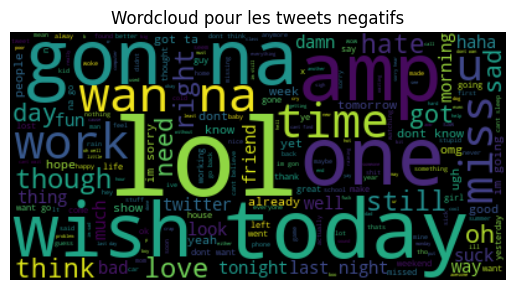

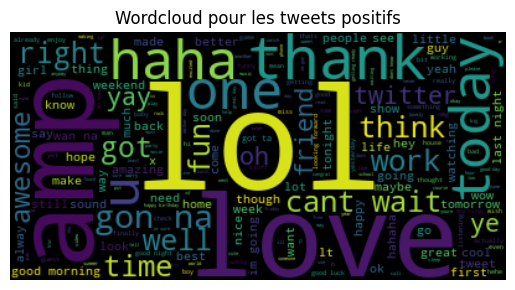

In [137]:
def generate_wordcloud(dataframe, column_name, title):
    """
    Génère un nuage de mots à partir d'une colonne d'un DataFrame.
    Args:
        dataframe (pd.DataFrame): DataFrame contenant les textes.
        column_name (str): Nom de la colonne texte.
        title (str): Titre du nuage de mots.
    """
    # Convertir en string et remplacer NaN
    text = " ".join(str(review) for review in dataframe[column_name].dropna())

    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()
df_sample_neg = data.loc[data['target']==0, :]
df_sample_pos = data.loc[data['target']==1, :]
generate_wordcloud(df_sample_neg, 'cleaned_text_lemmatized', 'Wordcloud pour les tweets negatifs')
generate_wordcloud(df_sample_pos, 'cleaned_text_lemmatized', 'Wordcloud pour les tweets positifs')

## Partie 3 : Méthodologies de Modélisation

### <a href="#C4">1. Modèle sur Mesure Simple:Régression logistique</a>


#### Présentation synthétique des principes du MLOps

### Principes clés :
- **Automatisation :** Pipelines pour les étapes clés (données, entraînement, déploiement).
- **Versioning :** Suivi des données, modèles et scripts pour reproductibilité.
- **CI/CD :** Intégration et déploiement continus des modèles.
- **Surveillance :** Suivi des performances et gestion des dérives.
- **Collaboration :** Alignement des équipes Data Science, IT et métiers.
- **Scalabilité :** Optimisation des ressources pour traiter des données à grande échelle.

### Apports :
- **Fiabilité :** Réduction des erreurs grâce à l’automatisation.
- **Rapidité :** Accélération du cycle de vie des modèles.
- **Amélioration continue :** Suivi en temps réel et mises à jour fréquentes.
- **Collaboration :** Meilleure coordination interdisciplinaire.
- **Optimisation des coûts :** Gestion efficace des ressources.
- **Création de valeur :** Alignement des modèles avec les besoins métiers.

**MLOps** industrialise le Machine Learning pour un déploiement fiable, scalable et centré sur la valeur.



==============================================================================================================================

J'ai utilisé MLFlow pour gérer l'entraînement et l'évaluation de plusieurs modèles de régression logistique sur des données textuelles. Après avoir divisé les données en ensembles d'entraînement, de validation et de test, j'ai testé deux représentations de texte : le texte lemmatisé et celui avec des racines réduites (stemming). J'ai utilisé la technique de vectorisation [TF-IDF](w) pour transformer les textes en vecteurs. J'ai ensuite choisi la meilleure représentation et optimisé les hyperparamètres du modèle via une recherche sur grille.

Ensuite, j'ai enregistré chaque modèle ainsi que ses résultats (précision, AUC, log-loss, temps d'entraînement) dans MLFlow, puis sauvegardé le modèle le plus performant dans un fichier pickle.

Enfin, j'ai consulté le meilleur modèle sur MLFlow pour examiner ses métriques et sauvegardé les résultats de cette exécution optimale.




Meilleure représentation : cleaned_text_lemmatized


2025/03/04 12:07:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpnke1mnt6\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/04 12:07:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic_Regression_Model_1 - Training Time: 4.87 seconds
🏃 View run Logistic_Regression_Model_1 at: http://localhost:5000/#/experiments/275875010236740487/runs/193b7e68388643f6b093cd48fcba300a
🧪 View experiment at: http://localhost:5000/#/experiments/275875010236740487


2025/03/04 12:08:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpvsia6jv2\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/04 12:08:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic_Regression_Model_2 - Training Time: 4.99 seconds
🏃 View run Logistic_Regression_Model_2 at: http://localhost:5000/#/experiments/275875010236740487/runs/2dac33ad7af741d7b6c814d76e03bf85
🧪 View experiment at: http://localhost:5000/#/experiments/275875010236740487


2025/03/04 12:08:35 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpcy7bb01u\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/04 12:08:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic_Regression_Model_3 - Training Time: 5.69 seconds
🏃 View run Logistic_Regression_Model_3 at: http://localhost:5000/#/experiments/275875010236740487/runs/82960cb1c8e241659fe90bb7df62df61
🧪 View experiment at: http://localhost:5000/#/experiments/275875010236740487


2025/03/04 12:08:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpyje6j98o\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/04 12:08:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic_Regression_Model_4 - Training Time: 5.91 seconds
🏃 View run Logistic_Regression_Model_4 at: http://localhost:5000/#/experiments/275875010236740487/runs/a58ff0860d204f1abe03c6402a160797
🧪 View experiment at: http://localhost:5000/#/experiments/275875010236740487


2025/03/04 12:09:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpxaw65c0x\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/04 12:09:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic_Regression_Model_5 - Training Time: 7.27 seconds
🏃 View run Logistic_Regression_Model_5 at: http://localhost:5000/#/experiments/275875010236740487/runs/c898a53d8eea4bfb8f0745f4da1b0a88
🧪 View experiment at: http://localhost:5000/#/experiments/275875010236740487


2025/03/04 12:09:37 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp_hjec57z\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/04 12:09:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic_Regression_Model_6 - Training Time: 4.71 seconds
🏃 View run Logistic_Regression_Model_6 at: http://localhost:5000/#/experiments/275875010236740487/runs/bf8230261f464e6eab9a42bca21a90ab
🧪 View experiment at: http://localhost:5000/#/experiments/275875010236740487


2025/03/04 12:10:00 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpk71jozej\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/04 12:10:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic_Regression_Model_7 - Training Time: 9.07 seconds
🏃 View run Logistic_Regression_Model_7 at: http://localhost:5000/#/experiments/275875010236740487/runs/c4bbc69670d9457db0163929ab6a72d5
🧪 View experiment at: http://localhost:5000/#/experiments/275875010236740487


2025/03/04 12:10:22 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmphbubwv8t\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/04 12:10:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic_Regression_Model_8 - Training Time: 6.41 seconds
🏃 View run Logistic_Regression_Model_8 at: http://localhost:5000/#/experiments/275875010236740487/runs/7d2e1333a395453389bb6c4cd393f2a9
🧪 View experiment at: http://localhost:5000/#/experiments/275875010236740487
Modèle sauvegardé : best_model.pkl


2025/03/04 12:10:42 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpsdfy8skq\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/04 12:10:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best_Logistic_Regression - Training Time: 6.43 seconds
🏃 View run Best_Logistic_Regression at: http://localhost:5000/#/experiments/275875010236740487/runs/c014385983644fdb97746591d6bf61bd
🧪 View experiment at: http://localhost:5000/#/experiments/275875010236740487


(0.7672, 0.8496814275872571, 6.429403305053711)

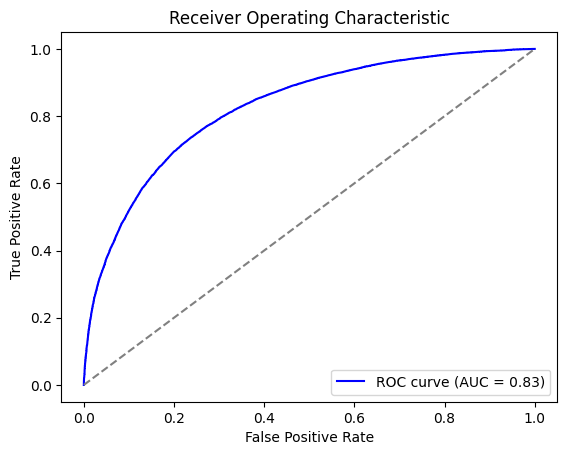

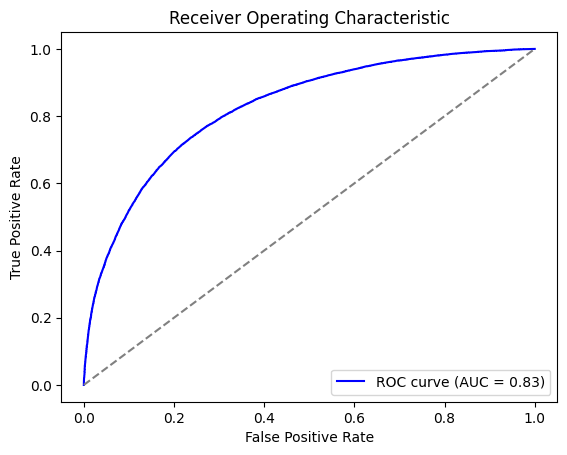

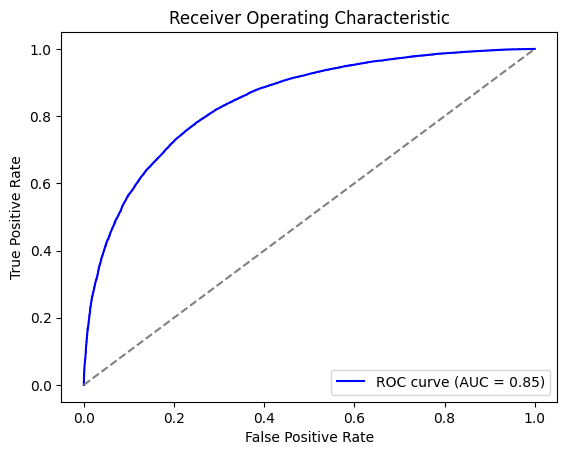

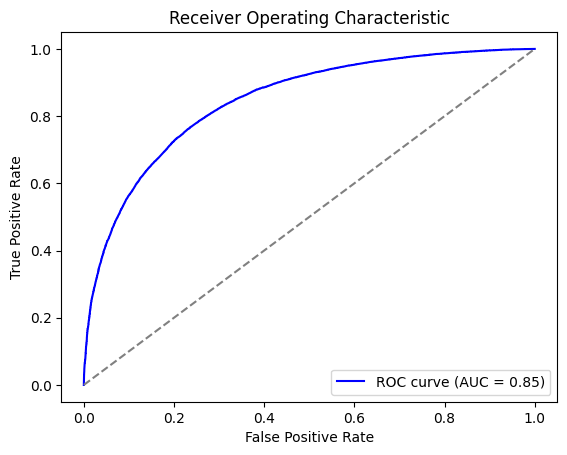

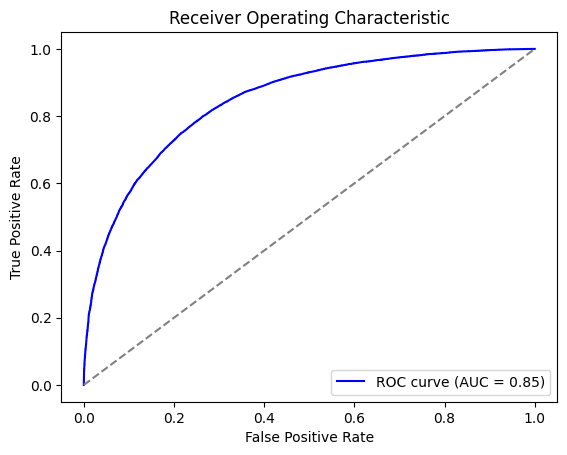

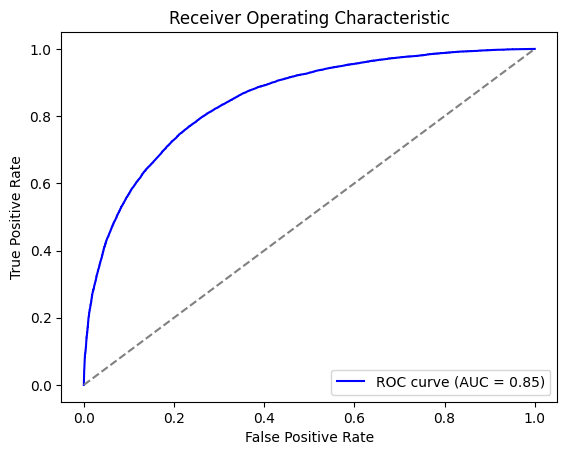

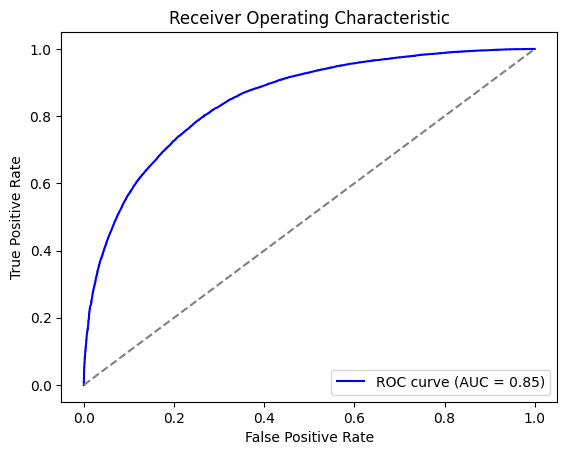

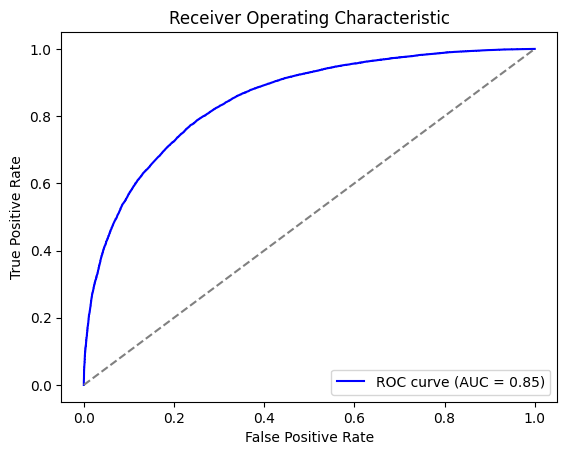

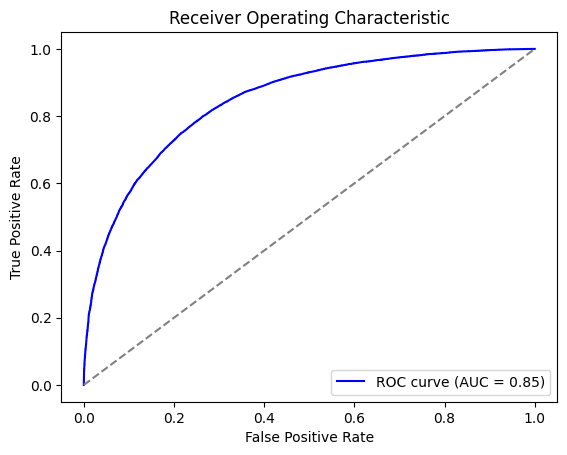

In [138]:
import mlflow
import mlflow.sklearn
import time
import matplotlib.pyplot as plt
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, log_loss, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Définir l'URI du serveur MLFlow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("tweet_prediction_by_regression_logistique_final")

# Charger les données
subset_data = data.sample(n=500000, random_state=42)

# Diviser en Train, Validation et Test
X_train, X_temp, y_train, y_temp = train_test_split(
    subset_data[['cleaned_text_lemmatized', 'cleaned_text_stemmed']],
    subset_data['target'], test_size=0.2, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Remplacer les NaN
for col in ['cleaned_text_lemmatized', 'cleaned_text_stemmed']:
    X_train[col] = X_train[col].fillna('')
    X_valid[col] = X_valid[col].fillna('')
    X_test[col] = X_test[col].fillna('')

# Fonction d'entraînement et de suivi MLflow
def log_mlflow_experiment(model, vectorizer, model_name, X_train, y_train, X_valid, y_valid, X_test, y_test, params=None):
    with mlflow.start_run(run_name=model_name):
        mlflow.set_tag("best_representation", best_text_representation)

        if params:
            mlflow.log_params(params)

        start_time = time.time()

        # Entraînement
        model.fit(vectorizer.transform(X_train), y_train)

        end_time = time.time()
        training_time = end_time - start_time

        # Prédictions
        y_train_pred = model.predict(vectorizer.transform(X_train))
        y_valid_pred = model.predict(vectorizer.transform(X_valid))
        y_test_pred = model.predict(vectorizer.transform(X_test))

        # Probabilités
        y_train_proba = model.predict_proba(vectorizer.transform(X_train))[:, 1]
        y_valid_proba = model.predict_proba(vectorizer.transform(X_valid))[:, 1]
        y_test_proba = model.predict_proba(vectorizer.transform(X_test))[:, 1]

        # Calcul des métriques
        train_accuracy = accuracy_score(y_train, y_train_pred)
        valid_accuracy = accuracy_score(y_valid, y_valid_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        train_auc = roc_auc_score(y_train, y_train_proba)
        valid_auc = roc_auc_score(y_valid, y_valid_proba)
        test_auc = roc_auc_score(y_test, y_test_proba)

        train_loss = log_loss(y_train, y_train_proba)
        valid_loss = log_loss(y_valid, y_valid_proba)
        test_loss = log_loss(y_test, y_test_proba)

        # Log des métriques
        mlflow.log_metrics({
            "Train Accuracy": train_accuracy,
            "Validation Accuracy": valid_accuracy,
            "Test Accuracy": test_accuracy,
            "Train AUC": train_auc,
            "Validation AUC": valid_auc,
            "Test AUC": test_auc,
            "Train Log-Loss": train_loss,
            "Validation Log-Loss": valid_loss,
            "Test Log-Loss": test_loss,
            "Training Time": training_time
        })

        # Rapport de classification
        report = classification_report(y_test, y_test_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        report_path = f"{model_name}_classification_report.csv"
        report_df.to_csv(report_path)
        mlflow.log_artifact(report_path)

        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig(f"{model_name}_roc_curve.png")
        mlflow.log_artifact(f"{model_name}_roc_curve.png")

        # Sauvegarde du modèle
        mlflow.sklearn.log_model(model, model_name)

        print(f"{model_name} - Training Time: {training_time:.2f} seconds")

    return test_accuracy, test_auc, training_time

# Sélection de la meilleure représentation textuelle
def evaluate_text_representation(text_column):
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train[text_column])
    X_valid_tfidf = vectorizer.transform(X_valid[text_column])
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_tfidf, y_train)
    
    valid_accuracy = accuracy_score(y_valid, model.predict(X_valid_tfidf))
    return valid_accuracy, vectorizer

# Tester les deux représentations
acc_lemmatized, vectorizer_lemmatized = evaluate_text_representation("cleaned_text_lemmatized")
acc_stemmed, vectorizer_stemmed = evaluate_text_representation("cleaned_text_stemmed")

if acc_lemmatized > acc_stemmed:
    best_text_representation = "cleaned_text_lemmatized"
    best_vectorizer = vectorizer_lemmatized
else:
    best_text_representation = "cleaned_text_stemmed"
    best_vectorizer = vectorizer_stemmed

print(f"Meilleure représentation : {best_text_representation}")

# GridSearch et suivi MLflow
pipeline = Pipeline([
    ('tfidf', best_vectorizer),
    ('logreg', LogisticRegression(max_iter=1000))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train[best_text_representation], y_train)

# Log des modèles GridSearch
for i, model_params in enumerate(grid_search.cv_results_['params']):
    model_name = f"Logistic_Regression_Model_{i+1}"
    pipeline.set_params(**model_params)
    log_mlflow_experiment(pipeline['logreg'], best_vectorizer, model_name, X_train[best_text_representation], y_train, X_valid[best_text_representation], y_valid, X_test[best_text_representation], y_test, model_params)

# Enregistrement du meilleur modèle
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'best_model.pkl')
print("Modèle sauvegardé : best_model.pkl")

# Enregistrement MLflow du meilleur modèle
log_mlflow_experiment(best_model['logreg'], best_vectorizer, "Best_Logistic_Regression", X_train[best_text_representation], y_train, X_valid[best_text_representation], y_valid, X_test[best_text_representation], y_test)


### Résumé des performances du modèle

#### Classe 0 :
- **Précision** : 78.18 %  
- **Rappel** : 74.12 %  
- **F1-score** : 76.09 %  
- **Support** : 24 995  

#### Classe 1 :
- **Précision** : 75.40 %  
- **Rappel** : 79.32 %  
- **F1-score** : 77.31 %  
- **Support** : 25 005  

#### Moyennes :
- **Macro moyenne** : Précision/Rappel/F1-score = **76.72 %**  
- **Moyenne pondérée** : Précision = **76.79 %**, Rappel = **76.72 %**, F1-score = **76.70 %**  

### Interprétation :
- Performances équilibrées entre les classes.  
- Légère amélioration possible sur le rappel de la classe 0 et la précision de la classe 1.  


## <a href="C5">2 Modèle sur Mesure Avancé:Réseaux de neurones profonds pour prédire les sentiments</a>
## <a href="C6">2.1 LSTM avec apprentissage des embeddings à partir des données.</a>

#### Modèle LSTM (Long Short-Term Memory)

Les **LSTM** (Long Short-Term Memory) sont un type de réseau de neurones récurrent (RNN) conçus pour résoudre le problème du gradient qui disparaît ou explose dans les réseaux de neurones traditionnels lorsqu'ils sont utilisés pour des tâches séquentielles, comme la modélisation de séries temporelles ou le traitement du langage naturel. 

Les LSTM sont capables de "se souvenir" d'informations sur des périodes de temps plus longues grâce à des **portes** spéciales qui régulent le flux d'informations. Ces portes comprennent :

- **Porte d'entrée** : contrôle l'ajout de nouvelles informations à la mémoire.
- **Porte de sortie** : contrôle ce qui doit être utilisé pour la prédiction.
- **Porte d'oubli** : décide quelles informations doivent être oubliées.

En conséquence, les LSTM sont particulièrement efficaces pour capturer les dépendances à long terme dans des données séquentielles, telles que les séries temporelles ou les séquences de texte.

####  Expérimentation LSTM avec MLflow et Tuning d'Hyperparamètres  

####  Objectif  
J'ai utilisé un modèle **LSTM ** pour classifier du texte en explorant deux variantes :  
- **Lemmatization**  
- **Stemming**  

####  Prétraitement  
- Tokenisation et padding (max_len=500)  
- Séparation des données en **train/validation/test**  
- Deux ensembles de textes : **lemmatisés** et **stemmés**  

####  Modèle  
J'ai utilisé un **LSTM simple avec Embedding classique** :  
- **Hyperparamètres testés** : nombre d'unités (64,128), dropout (0.2,0.4), batch_size (32,64), epochs (3,5)  
- **Optimisation** : Adam, loss=binary_crossentropy  

####  Suivi & Évaluation  
- Tracking avec **MLflow** (accuracy, AUC, temps d'entraînement)  
- Génération des **courbes ROC, matrices de confusion, rapports de classification**  
- Comparaison des performances **lemmatized vs stemmed**  


C:\Users\attia\AppData\Local\Temp\ipykernel_19440\2488582201.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna('', inplace=True)
C:\Users\attia\AppData\Local\Temp\ipykernel_19440\2488582201.py:158: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

Testing Lemmatized Data...
Epoch 1/3


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 239s 118ms/step - accuracy: 0.7025 - loss: 0.5618 - val_accuracy: 0.7567 - val_loss: 0.4944 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 232s 116ms/step - accuracy: 0.7850 - loss: 0.4530 - val_accuracy: 0.7559 - val_loss: 0.4939 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 234s 117ms/step - accuracy: 0.8070 - loss: 0.4116 - val_accuracy: 0.7565 - val_loss: 0.5126 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step


2025/02/27 16:50:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.77      0.77      0.77      4004
           1       0.77      0.77      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 16:51:00 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpo2e9c453\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 16:51:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 716.00 seconds
🏃 View run LSTM_Lemmatized_batch_size-32_dropout_rate-0.2_epochs-3_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/172fdb0d436042f0882611ab115d2b01
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/3


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 594s 296ms/step - accuracy: 0.7028 - loss: 0.5610 - val_accuracy: 0.7559 - val_loss: 0.4951 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 547s 273ms/step - accuracy: 0.7828 - loss: 0.4561 - val_accuracy: 0.7631 - val_loss: 0.4930 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 479s 240ms/step - accuracy: 0.8050 - loss: 0.4118 - val_accuracy: 0.7586 - val_loss: 0.5077 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step


2025/02/27 17:18:22 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.79      0.75      0.77      4004
           1       0.76      0.80      0.78      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 17:18:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp_m70ed2k\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 17:18:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 1639.36 seconds
🏃 View run LSTM_Lemmatized_batch_size-32_dropout_rate-0.2_epochs-3_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/8cca2161196040d4a6411791b7cc98bb
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 344s 171ms/step - accuracy: 0.7044 - loss: 0.5620 - val_accuracy: 0.7549 - val_loss: 0.4962 - learning_rate: 0.0010
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 317s 159ms/step - accuracy: 0.7850 - loss: 0.4564 - val_accuracy: 0.7550 - val_loss: 0.4939 - learning_rate: 0.0010
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 270s 135ms/step - accuracy: 0.8054 - loss: 0.4174 - val_accuracy: 0.7573 - val_loss: 0.5065 - learning_rate: 0.0010
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 262s 131ms/step - accuracy: 0.8231 - loss: 0.3784 - val_accuracy: 0.7500 - val_loss: 0.5323 - learning_rate: 0.0010
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 267s 134ms/step - accuracy: 0.8450 - loss: 0.3331 - val_accuracy: 0.7484 - val_loss: 0.6050 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step


2025/02/27 17:43:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.79      0.75      0.77      4004
           1       0.76      0.80      0.78      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 17:43:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpjyyfxu7k\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 17:43:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 1473.16 seconds
🏃 View run LSTM_Lemmatized_batch_size-32_dropout_rate-0.2_epochs-5_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/f9adfb045eaa49329942816d650ab91e
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/5


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 464s 231ms/step - accuracy: 0.7017 - loss: 0.5620 - val_accuracy: 0.7590 - val_loss: 0.4964 - learning_rate: 0.0010
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 482s 241ms/step - accuracy: 0.7860 - loss: 0.4543 - val_accuracy: 0.7585 - val_loss: 0.4931 - learning_rate: 0.0010
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 473s 236ms/step - accuracy: 0.8083 - loss: 0.4123 - val_accuracy: 0.7585 - val_loss: 0.5095 - learning_rate: 0.0010
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 546s 273ms/step - accuracy: 0.8232 - loss: 0.3770 - val_accuracy: 0.7515 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 567s 284ms/step - accuracy: 0.8502 - loss: 0.3268 - val_accuracy: 0.7448 - val_loss: 0.6120 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step


2025/02/27 18:25:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.76      0.79      0.78      4004
           1       0.78      0.75      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 18:26:42 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp6yh33o4i\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 18:26:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 2559.55 seconds
🏃 View run LSTM_Lemmatized_batch_size-32_dropout_rate-0.2_epochs-5_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/803c0021eabc400cabc0a4431e84a43f
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/3


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 315s 156ms/step - accuracy: 0.6994 - loss: 0.5645 - val_accuracy: 0.7531 - val_loss: 0.4950 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 297s 148ms/step - accuracy: 0.7818 - loss: 0.4573 - val_accuracy: 0.7542 - val_loss: 0.4971 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 336s 168ms/step - accuracy: 0.8065 - loss: 0.4137 - val_accuracy: 0.7533 - val_loss: 0.5080 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step


2025/02/27 18:42:55 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.78      0.75      0.76      4004
           1       0.76      0.79      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 18:43:02 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmprqajc9wf\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 18:43:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 967.97 seconds
🏃 View run LSTM_Lemmatized_batch_size-32_dropout_rate-0.4_epochs-3_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/338811fe94b147b5aecae8bac102c2ed
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/3


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 616s 307ms/step - accuracy: 0.7005 - loss: 0.5644 - val_accuracy: 0.7577 - val_loss: 0.4932 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 622s 311ms/step - accuracy: 0.7860 - loss: 0.4548 - val_accuracy: 0.7523 - val_loss: 0.4953 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 626s 313ms/step - accuracy: 0.8026 - loss: 0.4161 - val_accuracy: 0.7499 - val_loss: 0.5082 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step


2025/02/27 19:14:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.78      0.75      0.77      4004
           1       0.76      0.78      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 19:14:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpgk050pu0\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 19:14:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 1901.71 seconds
🏃 View run LSTM_Lemmatized_batch_size-32_dropout_rate-0.4_epochs-3_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/ff837ae9245d44a1855ea74f2df4e295
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 170ms/step - accuracy: 0.7009 - loss: 0.5650 - val_accuracy: 0.7535 - val_loss: 0.5019 - learning_rate: 0.0010
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 170ms/step - accuracy: 0.7864 - loss: 0.4536 - val_accuracy: 0.7610 - val_loss: 0.4952 - learning_rate: 0.0010
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 345s 172ms/step - accuracy: 0.8026 - loss: 0.4166 - val_accuracy: 0.7566 - val_loss: 0.5097 - learning_rate: 0.0010
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 338s 169ms/step - accuracy: 0.8201 - loss: 0.3819 - val_accuracy: 0.7506 - val_loss: 0.5523 - learning_rate: 0.0010
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 350s 175ms/step - accuracy: 0.8397 - loss: 0.3396 - val_accuracy: 0.7480 - val_loss: 0.6065 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step


2025/02/27 19:43:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.79      0.75      0.77      4004
           1       0.76      0.80      0.78      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 19:43:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp4a5aw3fz\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 19:43:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
C:\Users\attia\AppData\Local\Temp\ipykernel_19440\2488582201.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 5))


Training Time: 1730.84 seconds
🏃 View run LSTM_Lemmatized_batch_size-32_dropout_rate-0.4_epochs-5_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/776be5f0acce4341b0a8f9cf40e5bb13
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/5


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 558s 278ms/step - accuracy: 0.6598 - loss: 0.6200 - val_accuracy: 0.7559 - val_loss: 0.4962 - learning_rate: 0.0010
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 462s 231ms/step - accuracy: 0.7806 - loss: 0.4651 - val_accuracy: 0.7546 - val_loss: 0.4951 - learning_rate: 0.0010
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 468s 234ms/step - accuracy: 0.7969 - loss: 0.4323 - val_accuracy: 0.7604 - val_loss: 0.5015 - learning_rate: 0.0010
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 499s 249ms/step - accuracy: 0.8123 - loss: 0.3996 - val_accuracy: 0.7561 - val_loss: 0.5221 - learning_rate: 0.0010
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 485s 243ms/step - accuracy: 0.8356 - loss: 0.3541 - val_accuracy: 0.7523 - val_loss: 0.5729 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step


2025/02/27 20:25:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.77      0.77      0.77      4004
           1       0.77      0.77      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 20:25:41 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp2xyw31j7\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 20:25:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 2495.16 seconds
🏃 View run LSTM_Lemmatized_batch_size-32_dropout_rate-0.4_epochs-5_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/2b7e740874f345a3ab5278f3b0295448
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 256s 254ms/step - accuracy: 0.6951 - loss: 0.5701 - val_accuracy: 0.7550 - val_loss: 0.4975 - learning_rate: 0.0010
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 251s 251ms/step - accuracy: 0.7825 - loss: 0.4588 - val_accuracy: 0.7598 - val_loss: 0.4916 - learning_rate: 0.0010
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 246s 246ms/step - accuracy: 0.8003 - loss: 0.4263 - val_accuracy: 0.7571 - val_loss: 0.5016 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step


2025/02/27 20:38:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.78      0.76      0.77      4004
           1       0.76      0.79      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 20:38:38 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmppj_7nyf9\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 20:38:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 766.00 seconds
🏃 View run LSTM_Lemmatized_batch_size-64_dropout_rate-0.2_epochs-3_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/cc4a5ed65fbb42a2add629f8652f4076
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/3


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 591s 589ms/step - accuracy: 0.6795 - loss: 0.6120 - val_accuracy: 0.7595 - val_loss: 0.4958 - learning_rate: 0.0010
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 596s 596ms/step - accuracy: 0.7833 - loss: 0.4592 - val_accuracy: 0.7582 - val_loss: 0.4961 - learning_rate: 0.0010
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 612s 612ms/step - accuracy: 0.7993 - loss: 0.4303 - val_accuracy: 0.7586 - val_loss: 0.5040 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step


2025/02/27 21:09:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.80      0.72      0.76      4004
           1       0.75      0.82      0.78      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 21:09:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp30y7elmm\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 21:09:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 1838.30 seconds
🏃 View run LSTM_Lemmatized_batch_size-64_dropout_rate-0.2_epochs-3_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/ff631ae1a10f41d7b6c96d35e7216024
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 240s 236ms/step - accuracy: 0.6953 - loss: 0.5704 - val_accuracy: 0.7530 - val_loss: 0.4950 - learning_rate: 0.0010
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 234s 234ms/step - accuracy: 0.7800 - loss: 0.4663 - val_accuracy: 0.7470 - val_loss: 0.4961 - learning_rate: 0.0010
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 238s 238ms/step - accuracy: 0.7987 - loss: 0.4288 - val_accuracy: 0.7595 - val_loss: 0.4990 - learning_rate: 0.0010
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 245s 245ms/step - accuracy: 0.8219 - loss: 0.3827 - val_accuracy: 0.7567 - val_loss: 0.5418 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step


2025/02/27 21:25:40 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.79      0.73      0.76      4004
           1       0.75      0.80      0.78      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 21:25:48 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpl5bsdfsz\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 21:25:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 970.47 seconds
🏃 View run LSTM_Lemmatized_batch_size-64_dropout_rate-0.2_epochs-5_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/16c2294bbee448f8b588d8d73fb9ec95
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/5


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 647s 645ms/step - accuracy: 0.6208 - loss: 0.8184 - val_accuracy: 0.7446 - val_loss: 0.5133 - learning_rate: 0.0010
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 652s 652ms/step - accuracy: 0.7699 - loss: 0.4844 - val_accuracy: 0.7550 - val_loss: 0.4964 - learning_rate: 0.0010
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 648s 648ms/step - accuracy: 0.7924 - loss: 0.4472 - val_accuracy: 0.7567 - val_loss: 0.4942 - learning_rate: 0.0010
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 639s 639ms/step - accuracy: 0.8027 - loss: 0.4261 - val_accuracy: 0.7579 - val_loss: 0.5028 - learning_rate: 0.0010
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 424s 423ms/step - accuracy: 0.8143 - loss: 0.4023 - val_accuracy: 0.7515 - val_loss: 0.5199 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step


2025/02/27 22:16:27 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.78      0.75      0.76      4004
           1       0.76      0.79      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 22:16:35 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpvurt_sju\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 22:16:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 3035.65 seconds
🏃 View run LSTM_Lemmatized_batch_size-64_dropout_rate-0.2_epochs-5_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/2fad026281d042fda7796d54dbbaf421
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 197s 195ms/step - accuracy: 0.6902 - loss: 0.5752 - val_accuracy: 0.7517 - val_loss: 0.5000 - learning_rate: 0.0010
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 204s 204ms/step - accuracy: 0.7816 - loss: 0.4657 - val_accuracy: 0.7551 - val_loss: 0.4955 - learning_rate: 0.0010
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 236s 236ms/step - accuracy: 0.7806 - loss: 0.4559 - val_accuracy: 0.7565 - val_loss: 0.5023 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step


2025/02/27 22:27:28 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.77      0.77      0.77      4004
           1       0.77      0.77      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 22:27:35 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp8821mdlg\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 22:27:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 649.89 seconds
🏃 View run LSTM_Lemmatized_batch_size-64_dropout_rate-0.4_epochs-3_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/f5e39d2d2cf14e05a8edd0dafcbcdd55
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 642s 641ms/step - accuracy: 0.6936 - loss: 0.5718 - val_accuracy: 0.7531 - val_loss: 0.4974 - learning_rate: 0.0010
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 537s 537ms/step - accuracy: 0.7831 - loss: 0.4642 - val_accuracy: 0.7523 - val_loss: 0.4960 - learning_rate: 0.0010
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 637s 637ms/step - accuracy: 0.7912 - loss: 0.4361 - val_accuracy: 0.7556 - val_loss: 0.5034 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step


2025/02/27 22:58:21 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.78      0.73      0.76      4004
           1       0.75      0.80      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 22:58:28 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpfdpjum4q\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 22:58:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 1842.77 seconds
🏃 View run LSTM_Lemmatized_batch_size-64_dropout_rate-0.4_epochs-3_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/43a849803b624ad498d2f7adea5bec2f
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/5


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 232s 231ms/step - accuracy: 0.6909 - loss: 0.5724 - val_accuracy: 0.7552 - val_loss: 0.4977 - learning_rate: 0.0010
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 232s 231ms/step - accuracy: 0.7817 - loss: 0.4619 - val_accuracy: 0.7544 - val_loss: 0.4916 - learning_rate: 0.0010
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 229s 229ms/step - accuracy: 0.7986 - loss: 0.4270 - val_accuracy: 0.7607 - val_loss: 0.5049 - learning_rate: 0.0010
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 238s 238ms/step - accuracy: 0.8162 - loss: 0.3917 - val_accuracy: 0.7504 - val_loss: 0.5283 - learning_rate: 0.0010
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 239s 239ms/step - accuracy: 0.8359 - loss: 0.3488 - val_accuracy: 0.7485 - val_loss: 0.5822 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step


2025/02/27 23:18:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.79      0.73      0.76      4004
           1       0.75      0.80      0.78      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/27 23:18:23 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp3jjtb7zx\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/27 23:18:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 1183.92 seconds
🏃 View run LSTM_Lemmatized_batch_size-64_dropout_rate-0.4_epochs-5_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/4e3d473622f64ec68c6ca9bda8692b9a
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/5


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 649s 648ms/step - accuracy: 0.6913 - loss: 0.5705 - val_accuracy: 0.7533 - val_loss: 0.4971 - learning_rate: 0.0010
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 639s 639ms/step - accuracy: 0.7818 - loss: 0.4592 - val_accuracy: 0.7566 - val_loss: 0.4952 - learning_rate: 0.0010
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 642s 642ms/step - accuracy: 0.7988 - loss: 0.4265 - val_accuracy: 0.7617 - val_loss: 0.5165 - learning_rate: 0.0010
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 637s 637ms/step - accuracy: 0.8167 - loss: 0.3931 - val_accuracy: 0.7594 - val_loss: 0.5261 - learning_rate: 0.0010
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 635s 635ms/step - accuracy: 0.8384 - loss: 0.3499 - val_accuracy: 0.7434 - val_loss: 0.5871 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step


2025/02/28 00:12:27 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.78      0.75      0.76      4004
           1       0.76      0.79      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 00:12:33 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp6onvsrf2\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 00:12:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 3239.83 seconds
🏃 View run LSTM_Lemmatized_batch_size-64_dropout_rate-0.4_epochs-5_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/69871abec2d7406189b4a8e4ccb7a428
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Testing Stemmed Data...


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 405s 201ms/step - accuracy: 0.7035 - loss: 0.5595 - val_accuracy: 0.7567 - val_loss: 0.4951 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 389s 194ms/step - accuracy: 0.7825 - loss: 0.4575 - val_accuracy: 0.7619 - val_loss: 0.4898 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 394s 197ms/step - accuracy: 0.8024 - loss: 0.4184 - val_accuracy: 0.7577 - val_loss: 0.5069 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step


2025/02/28 00:32:39 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.77      0.77      0.77      4004
           1       0.77      0.77      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 00:32:47 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpcf8rbvdk\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 00:32:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 1202.40 seconds
🏃 View run LSTM_Stemmed_batch_size-32_dropout_rate-0.2_epochs-3_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/2e105bbe728a47f7a65ce8f86db2b3cd
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/3


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 619s 308ms/step - accuracy: 0.7061 - loss: 0.5567 - val_accuracy: 0.7546 - val_loss: 0.4911 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 599s 299ms/step - accuracy: 0.7810 - loss: 0.4612 - val_accuracy: 0.7607 - val_loss: 0.4930 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 591s 296ms/step - accuracy: 0.8029 - loss: 0.4182 - val_accuracy: 0.7555 - val_loss: 0.5076 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step


2025/02/28 01:03:43 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.78      0.75      0.76      4004
           1       0.76      0.79      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 01:03:50 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpnjvycm1b\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 01:03:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 1852.71 seconds
🏃 View run LSTM_Stemmed_batch_size-32_dropout_rate-0.2_epochs-3_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/a00a3ddf1419494ca52e93bc662ebb1a
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 433s 216ms/step - accuracy: 0.7092 - loss: 0.5557 - val_accuracy: 0.7565 - val_loss: 0.4943 - learning_rate: 0.0010
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 420s 210ms/step - accuracy: 0.7787 - loss: 0.4636 - val_accuracy: 0.7535 - val_loss: 0.4947 - learning_rate: 0.0010
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 428s 214ms/step - accuracy: 0.8055 - loss: 0.4167 - val_accuracy: 0.7580 - val_loss: 0.5104 - learning_rate: 0.0010
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 421s 211ms/step - accuracy: 0.8292 - loss: 0.3703 - val_accuracy: 0.7559 - val_loss: 0.5430 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step


2025/02/28 01:32:35 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.77      0.76      0.77      4004
           1       0.77      0.78      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 01:32:42 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp3a2zki8m\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 01:32:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 1720.89 seconds
🏃 View run LSTM_Stemmed_batch_size-32_dropout_rate-0.2_epochs-5_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/0954703cf5ce4e68be02da1e5c9e3985
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/5


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 597s 298ms/step - accuracy: 0.7073 - loss: 0.5576 - val_accuracy: 0.7560 - val_loss: 0.4953 - learning_rate: 0.0010
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 590s 295ms/step - accuracy: 0.7852 - loss: 0.4576 - val_accuracy: 0.7573 - val_loss: 0.4938 - learning_rate: 0.0010
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 577s 288ms/step - accuracy: 0.8050 - loss: 0.4136 - val_accuracy: 0.7569 - val_loss: 0.5047 - learning_rate: 0.0010
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 579s 289ms/step - accuracy: 0.8239 - loss: 0.3793 - val_accuracy: 0.7580 - val_loss: 0.5320 - learning_rate: 0.0010
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 539s 270ms/step - accuracy: 0.8502 - loss: 0.3265 - val_accuracy: 0.7531 - val_loss: 0.6104 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step


2025/02/28 02:21:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.76      0.80      0.78      4004
           1       0.79      0.74      0.76      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 02:21:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp6nj2z0cq\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 02:21:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 2919.00 seconds
🏃 View run LSTM_Stemmed_batch_size-32_dropout_rate-0.2_epochs-5_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/38970b3d726f4cd483d26f722c2d1dae
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 400s 199ms/step - accuracy: 0.6986 - loss: 0.5611 - val_accuracy: 0.7577 - val_loss: 0.4929 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 415s 208ms/step - accuracy: 0.7839 - loss: 0.4571 - val_accuracy: 0.7601 - val_loss: 0.4914 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 394s 197ms/step - accuracy: 0.8026 - loss: 0.4181 - val_accuracy: 0.7621 - val_loss: 0.5039 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step


2025/02/28 02:41:59 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.79      0.74      0.76      4004
           1       0.75      0.80      0.78      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 02:42:06 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpky0phwbt\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 02:42:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 1224.55 seconds
🏃 View run LSTM_Stemmed_batch_size-32_dropout_rate-0.4_epochs-3_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/39598d234f624c03bae16ac1f8fe7ca4
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/3


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 578s 288ms/step - accuracy: 0.6894 - loss: 0.5826 - val_accuracy: 0.7558 - val_loss: 0.4983 - learning_rate: 0.0010
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 577s 289ms/step - accuracy: 0.7807 - loss: 0.4644 - val_accuracy: 0.7611 - val_loss: 0.4904 - learning_rate: 0.0010
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 575s 287ms/step - accuracy: 0.8010 - loss: 0.4274 - val_accuracy: 0.7613 - val_loss: 0.5031 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step


2025/02/28 03:11:36 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.77      0.77      0.77      4004
           1       0.77      0.77      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 03:11:43 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp3o4h3xmk\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 03:11:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 1766.15 seconds
🏃 View run LSTM_Stemmed_batch_size-32_dropout_rate-0.4_epochs-3_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/9680ef3391ca4f9db682abecf9f344be
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/5


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 385s 191ms/step - accuracy: 0.7068 - loss: 0.5604 - val_accuracy: 0.7544 - val_loss: 0.4958 - learning_rate: 0.0010
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 380s 190ms/step - accuracy: 0.7841 - loss: 0.4580 - val_accuracy: 0.7636 - val_loss: 0.4937 - learning_rate: 0.0010
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 373s 186ms/step - accuracy: 0.8018 - loss: 0.4184 - val_accuracy: 0.7556 - val_loss: 0.5046 - learning_rate: 0.0010
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 367s 183ms/step - accuracy: 0.8207 - loss: 0.3825 - val_accuracy: 0.7533 - val_loss: 0.5283 - learning_rate: 0.0010
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 352s 176ms/step - accuracy: 0.8441 - loss: 0.3377 - val_accuracy: 0.7445 - val_loss: 0.5954 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step


2025/02/28 03:42:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.78      0.76      0.77      4004
           1       0.77      0.78      0.78      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 03:43:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp2tmbimu1\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 03:43:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 1870.84 seconds
🏃 View run LSTM_Stemmed_batch_size-32_dropout_rate-0.4_epochs-5_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/7b3a1dfff9484f86b49c492272802259
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 577s 287ms/step - accuracy: 0.7033 - loss: 0.5601 - val_accuracy: 0.7545 - val_loss: 0.4935 - learning_rate: 0.0010
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 570s 285ms/step - accuracy: 0.7824 - loss: 0.4606 - val_accuracy: 0.7616 - val_loss: 0.4917 - learning_rate: 0.0010
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 573s 286ms/step - accuracy: 0.8038 - loss: 0.4204 - val_accuracy: 0.7573 - val_loss: 0.5095 - learning_rate: 0.0010
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 574s 287ms/step - accuracy: 0.8204 - loss: 0.3844 - val_accuracy: 0.7591 - val_loss: 0.5340 - learning_rate: 0.0010
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 569s 284ms/step - accuracy: 0.8427 - loss: 0.3367 - val_accuracy: 0.7500 - val_loss: 0.5912 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step


2025/02/28 04:31:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.79      0.75      0.77      4004
           1       0.76      0.80      0.78      3996

    accuracy                           0.77      8000
   macro avg       0.78      0.77      0.77      8000
weighted avg       0.78      0.77      0.77      8000



2025/02/28 04:31:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpr86wsrj2\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 04:31:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 2896.27 seconds
🏃 View run LSTM_Stemmed_batch_size-32_dropout_rate-0.4_epochs-5_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/fab2d6cc42384ef88f5ed30c7b219b1c
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 243s 241ms/step - accuracy: 0.6955 - loss: 0.5691 - val_accuracy: 0.7577 - val_loss: 0.4973 - learning_rate: 0.0010
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 252s 252ms/step - accuracy: 0.7835 - loss: 0.4574 - val_accuracy: 0.7604 - val_loss: 0.4928 - learning_rate: 0.0010
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 243s 243ms/step - accuracy: 0.8012 - loss: 0.4271 - val_accuracy: 0.7590 - val_loss: 0.5037 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step


2025/02/28 04:44:11 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.76      0.79      0.78      4004
           1       0.78      0.75      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 04:44:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp3t85skeo\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 04:44:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 757.15 seconds
🏃 View run LSTM_Stemmed_batch_size-64_dropout_rate-0.2_epochs-3_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/a553fb539ef0470299507c788ba3268e
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/3


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 786s 784ms/step - accuracy: 0.6954 - loss: 0.5680 - val_accuracy: 0.7575 - val_loss: 0.4963 - learning_rate: 0.0010
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 799s 781ms/step - accuracy: 0.7822 - loss: 0.4598 - val_accuracy: 0.7626 - val_loss: 0.4934 - learning_rate: 0.0010
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 800s 800ms/step - accuracy: 0.7981 - loss: 0.4303 - val_accuracy: 0.7579 - val_loss: 0.5074 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 201ms/step


2025/02/28 05:24:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.79      0.75      0.77      4004
           1       0.76      0.80      0.78      3996

    accuracy                           0.78      8000
   macro avg       0.78      0.78      0.78      8000
weighted avg       0.78      0.78      0.78      8000



2025/02/28 05:25:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpeyc6uo_y\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 05:25:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 2435.46 seconds
🏃 View run LSTM_Stemmed_batch_size-64_dropout_rate-0.2_epochs-3_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/64e2f1e3092f47f3ae83e2fae4c8cf7d
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/5


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 240s 238ms/step - accuracy: 0.6980 - loss: 0.5669 - val_accuracy: 0.7556 - val_loss: 0.4959 - learning_rate: 0.0010
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 238s 238ms/step - accuracy: 0.7830 - loss: 0.4606 - val_accuracy: 0.7561 - val_loss: 0.4964 - learning_rate: 0.0010
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 236s 236ms/step - accuracy: 0.7993 - loss: 0.4280 - val_accuracy: 0.7606 - val_loss: 0.4999 - learning_rate: 0.0010
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 238s 238ms/step - accuracy: 0.8232 - loss: 0.3808 - val_accuracy: 0.7579 - val_loss: 0.5353 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step


2025/02/28 05:41:17 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.78      0.76      0.77      4004
           1       0.77      0.78      0.78      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 05:41:24 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpiv1_ha_3\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 05:41:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 969.61 seconds
🏃 View run LSTM_Stemmed_batch_size-64_dropout_rate-0.2_epochs-5_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/73682faa772e4cefba13a78c89e22ea2
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 736s 734ms/step - accuracy: 0.6979 - loss: 0.5695 - val_accuracy: 0.7551 - val_loss: 0.5002 - learning_rate: 0.0010
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 616s 616ms/step - accuracy: 0.7830 - loss: 0.4616 - val_accuracy: 0.7554 - val_loss: 0.4952 - learning_rate: 0.0010
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 729s 729ms/step - accuracy: 0.7944 - loss: 0.4381 - val_accuracy: 0.7632 - val_loss: 0.4963 - learning_rate: 0.0010
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 738s 738ms/step - accuracy: 0.8140 - loss: 0.3975 - val_accuracy: 0.7581 - val_loss: 0.5150 - learning_rate: 0.0010
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 746s 746ms/step - accuracy: 0.8355 - loss: 0.3566 - val_accuracy: 0.7520 - val_loss: 0.5646 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step


2025/02/28 06:41:43 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.77      0.77      0.77      4004
           1       0.77      0.77      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 06:41:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpsqrbtbw_\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 06:41:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 3615.55 seconds
🏃 View run LSTM_Stemmed_batch_size-64_dropout_rate-0.2_epochs-5_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/d7f59fc336c740e6a1b03c220331b4fc
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 236s 234ms/step - accuracy: 0.6936 - loss: 0.5724 - val_accuracy: 0.7561 - val_loss: 0.4955 - learning_rate: 0.0010
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 231s 231ms/step - accuracy: 0.7807 - loss: 0.4645 - val_accuracy: 0.7592 - val_loss: 0.4922 - learning_rate: 0.0010
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 232s 232ms/step - accuracy: 0.7993 - loss: 0.4318 - val_accuracy: 0.7573 - val_loss: 0.5057 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step


2025/02/28 06:53:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.76      0.78      0.77      4004
           1       0.78      0.76      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 06:54:03 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpb0g6il9s\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 06:54:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 717.03 seconds
🏃 View run LSTM_Stemmed_batch_size-64_dropout_rate-0.4_epochs-3_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/0004eb067bc0476e96458ee27fbf341c
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/3


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 712s 710ms/step - accuracy: 0.6941 - loss: 0.5695 - val_accuracy: 0.7509 - val_loss: 0.4993 - learning_rate: 0.0010
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 716s 716ms/step - accuracy: 0.7731 - loss: 0.4810 - val_accuracy: 0.7479 - val_loss: 0.5074 - learning_rate: 0.0010
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 719s 718ms/step - accuracy: 0.7835 - loss: 0.4639 - val_accuracy: 0.7604 - val_loss: 0.4973 - learning_rate: 0.0010
250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 177ms/step


2025/02/28 07:30:37 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.76      0.78      0.77      4004
           1       0.77      0.76      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 07:30:44 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpy5m7onn6\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 07:30:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 2190.72 seconds
🏃 View run LSTM_Stemmed_batch_size-64_dropout_rate-0.4_epochs-3_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/543f16a5c6644b88bea4c0d575ac33b6
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 237s 235ms/step - accuracy: 0.6955 - loss: 0.5718 - val_accuracy: 0.7551 - val_loss: 0.4962 - learning_rate: 0.0010
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 230s 230ms/step - accuracy: 0.7787 - loss: 0.4652 - val_accuracy: 0.7591 - val_loss: 0.4943 - learning_rate: 0.0010
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 235s 235ms/step - accuracy: 0.7937 - loss: 0.4354 - val_accuracy: 0.7625 - val_loss: 0.4983 - learning_rate: 0.0010
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 232s 232ms/step - accuracy: 0.8105 - loss: 0.4014 - val_accuracy: 0.7589 - val_loss: 0.5139 - learning_rate: 0.0010
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 233s 233ms/step - accuracy: 0.8308 - loss: 0.3616 - val_accuracy: 0.7554 - val_loss: 0.5679 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step


2025/02/28 07:50:36 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.78      0.77      0.77      4004
           1       0.77      0.78      0.78      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 07:50:42 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpynys1tsg\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 07:50:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 1187.90 seconds
🏃 View run LSTM_Stemmed_batch_size-64_dropout_rate-0.4_epochs-5_units-64 at: http://localhost:5000/#/experiments/364484712967337855/runs/70ac5ccf443d4d5b91e33a3bd77d136b
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855
Epoch 1/5


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 741s 739ms/step - accuracy: 0.6954 - loss: 0.5677 - val_accuracy: 0.7546 - val_loss: 0.4962 - learning_rate: 0.0010
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 751s 750ms/step - accuracy: 0.7818 - loss: 0.4623 - val_accuracy: 0.7590 - val_loss: 0.4895 - learning_rate: 0.0010
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 742s 742ms/step - accuracy: 0.7941 - loss: 0.4350 - val_accuracy: 0.7592 - val_loss: 0.4940 - learning_rate: 0.0010
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 737s 737ms/step - accuracy: 0.8144 - loss: 0.3997 - val_accuracy: 0.7594 - val_loss: 0.5196 - learning_rate: 0.0010
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 729s 729ms/step - accuracy: 0.8355 - loss: 0.3548 - val_accuracy: 0.7526 - val_loss: 0.5727 - learning_rate: 5.0000e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 233ms/step


2025/02/28 08:53:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


              precision    recall  f1-score   support

           0       0.78      0.75      0.77      4004
           1       0.76      0.79      0.77      3996

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



2025/02/28 08:53:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpoeda21f8\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 08:53:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 3758.65 seconds
🏃 View run LSTM_Stemmed_batch_size-64_dropout_rate-0.4_epochs-5_units-128 at: http://localhost:5000/#/experiments/364484712967337855/runs/6c2c2292d4494df8b7a2cea5f3b5e2e3
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


2025/02/28 08:53:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/28 08:53:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp0uer2337\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/28 08:53:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Model is saved as 'best_lstm_model' with Validation Accuracy: 0.7636250257492065
🏃 View run Best_LSTM_Model at: http://localhost:5000/#/experiments/364484712967337855/runs/d1bc7a15853b41279128ca28bf2b4c4c
🧪 View experiment at: http://localhost:5000/#/experiments/364484712967337855


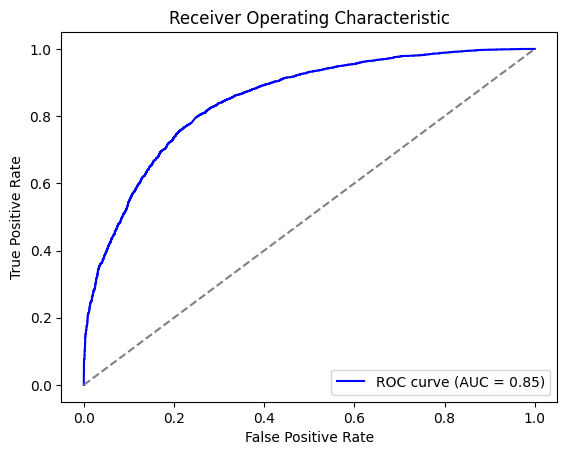

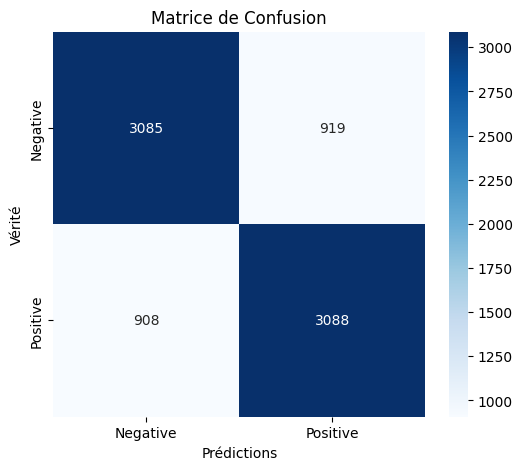

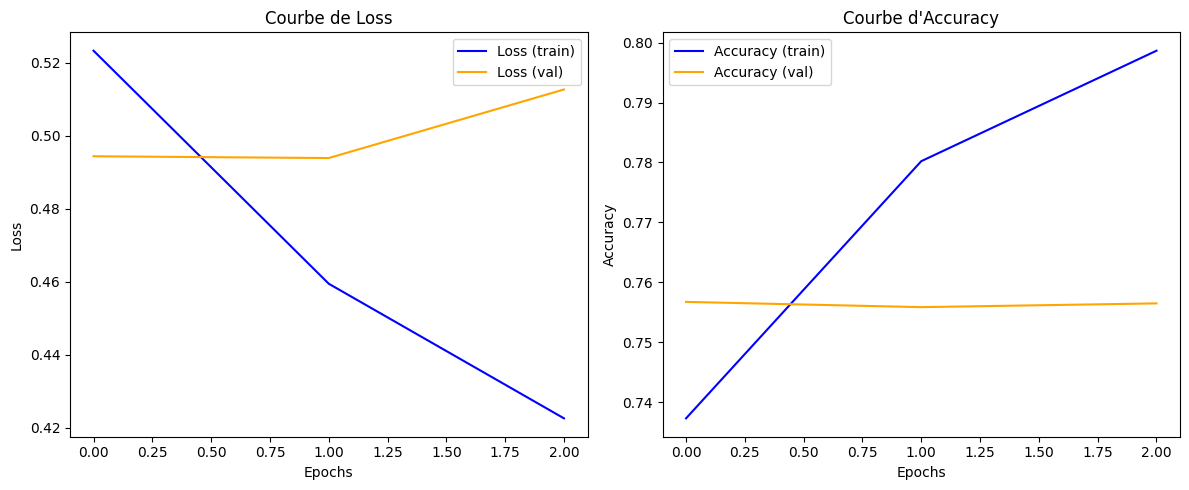

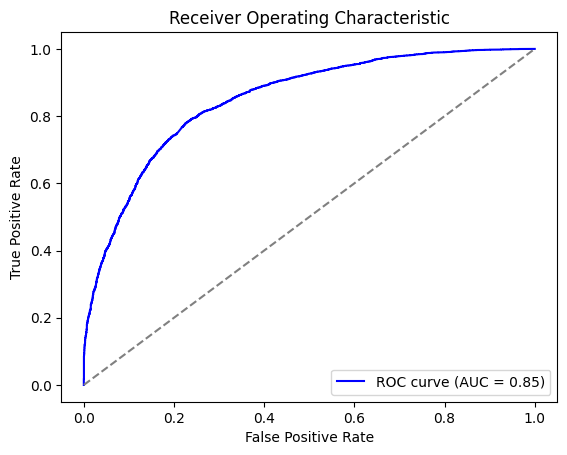

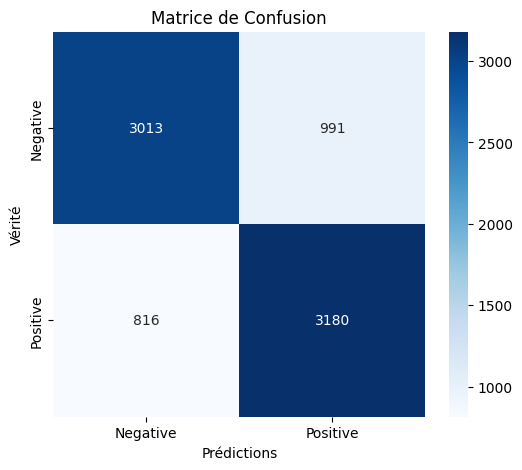

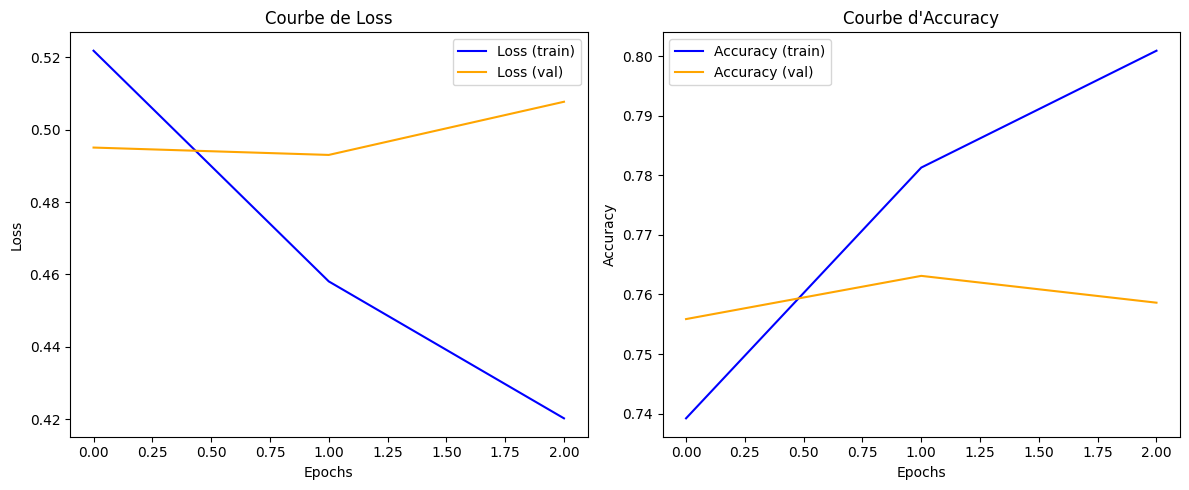

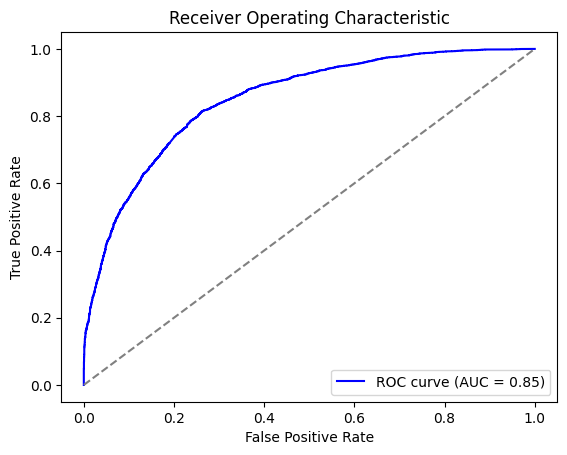

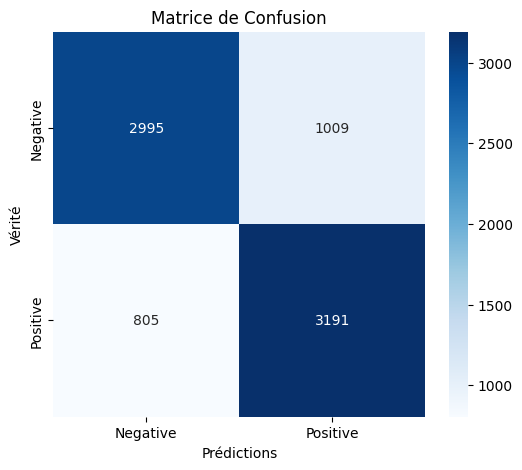

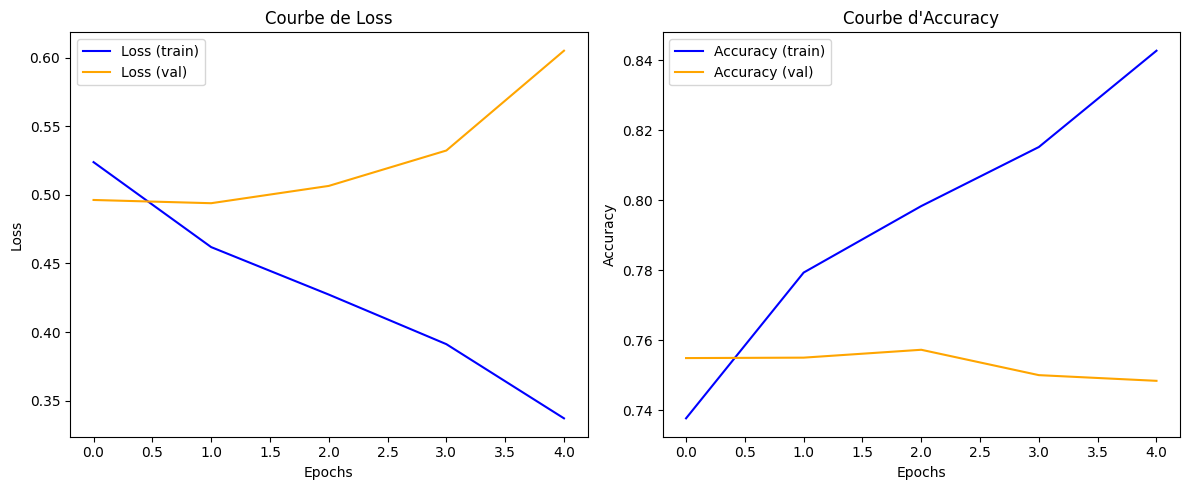

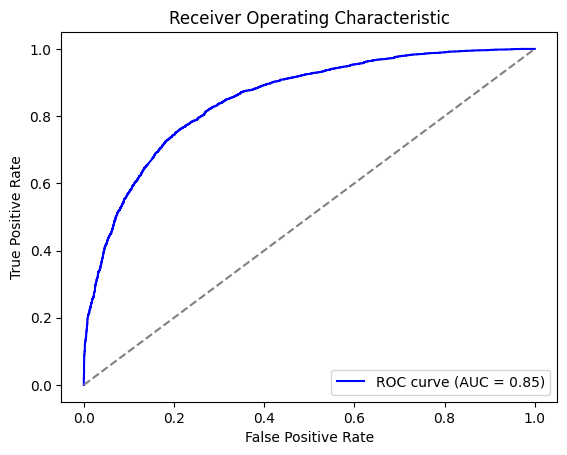

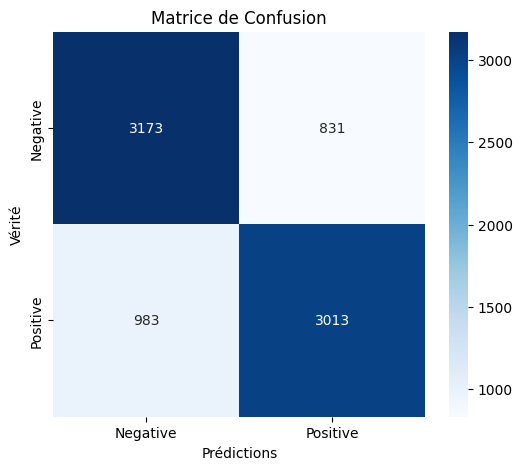

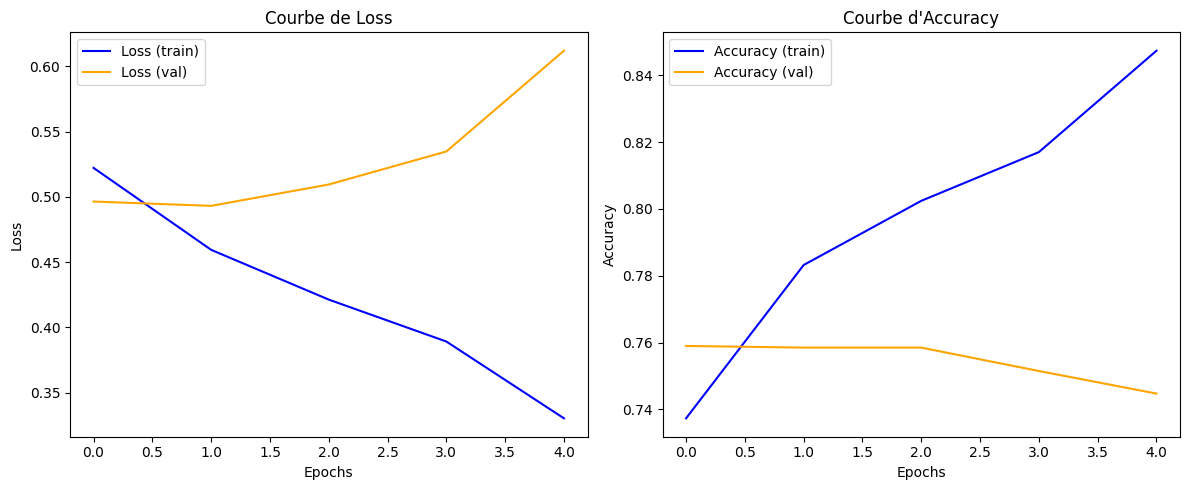

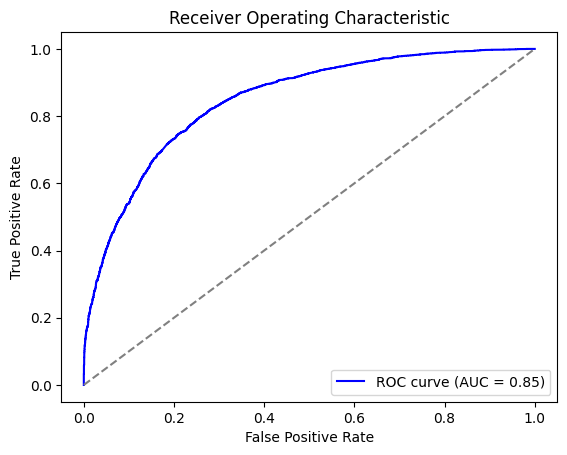

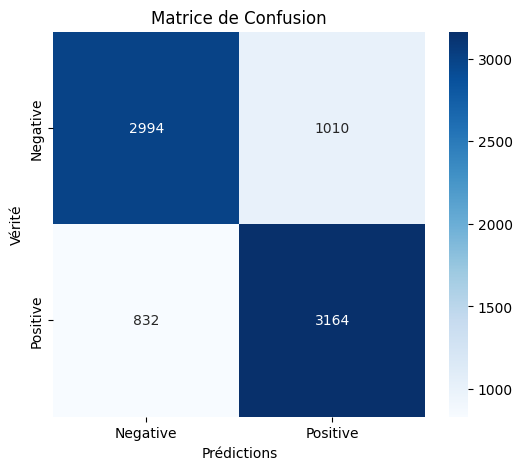

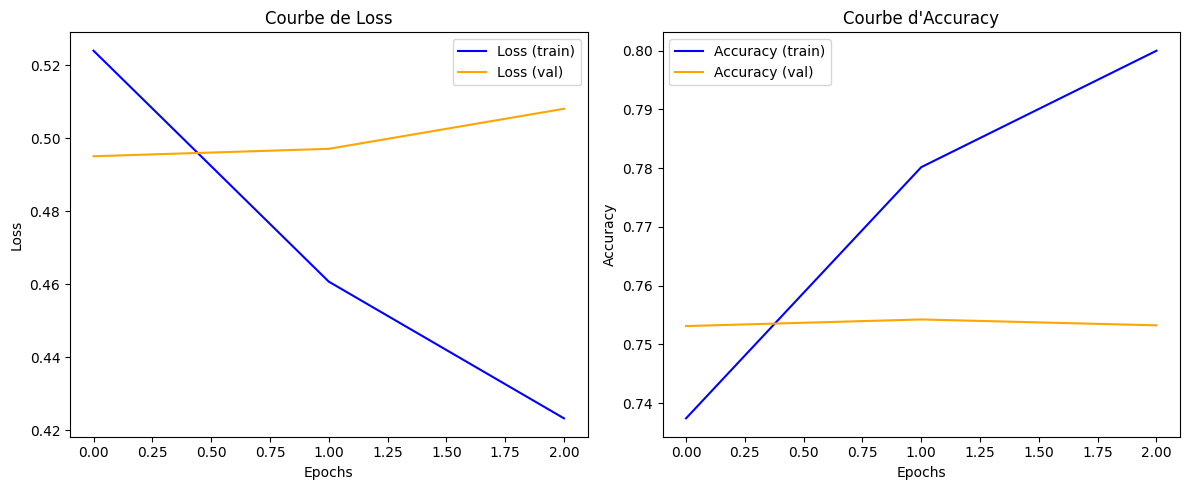

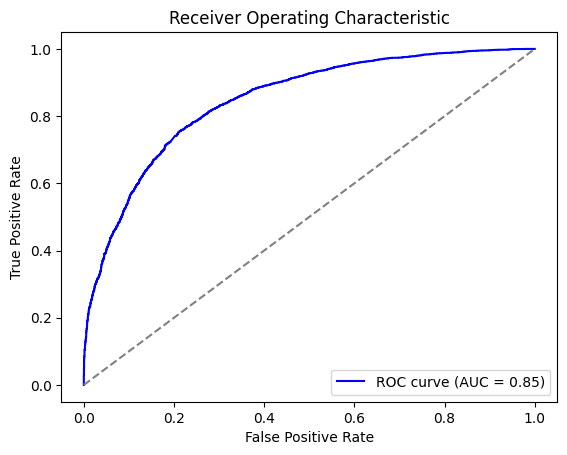

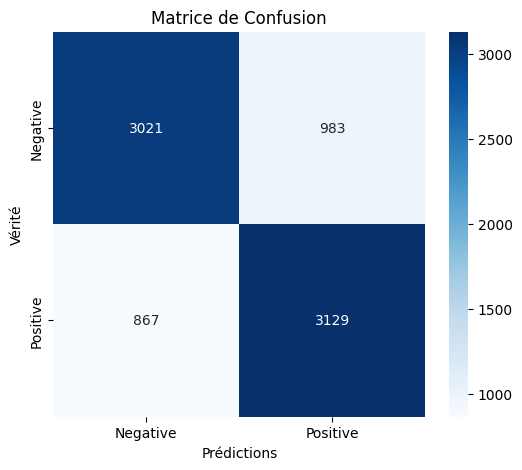

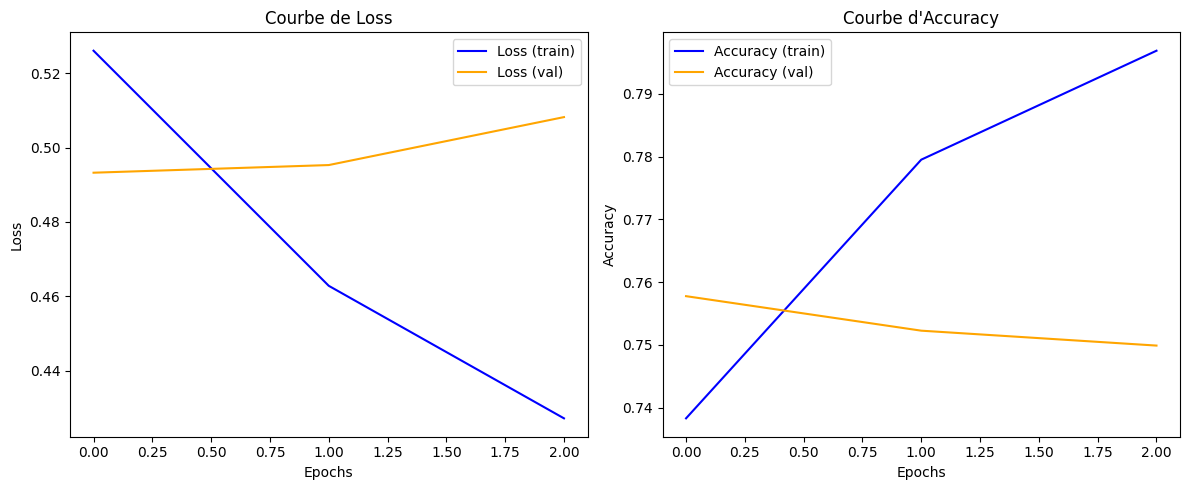

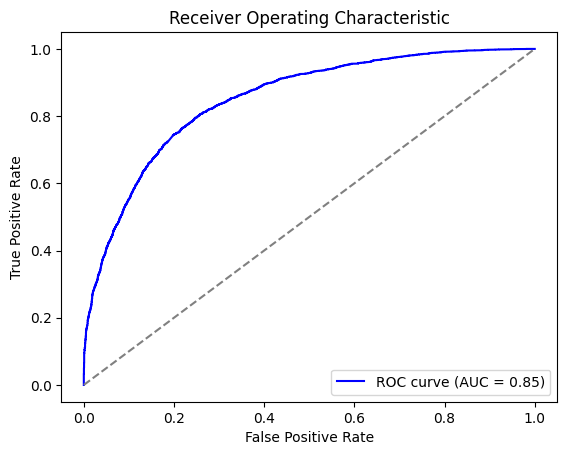

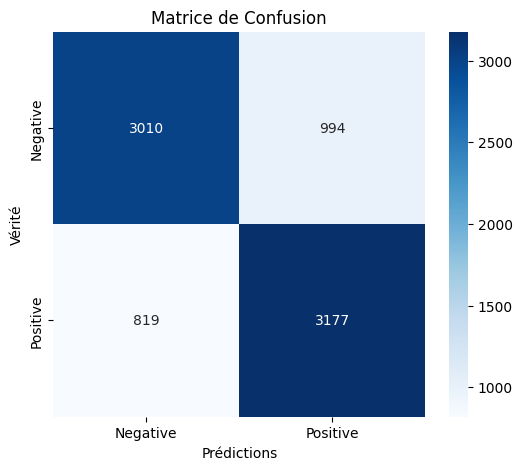

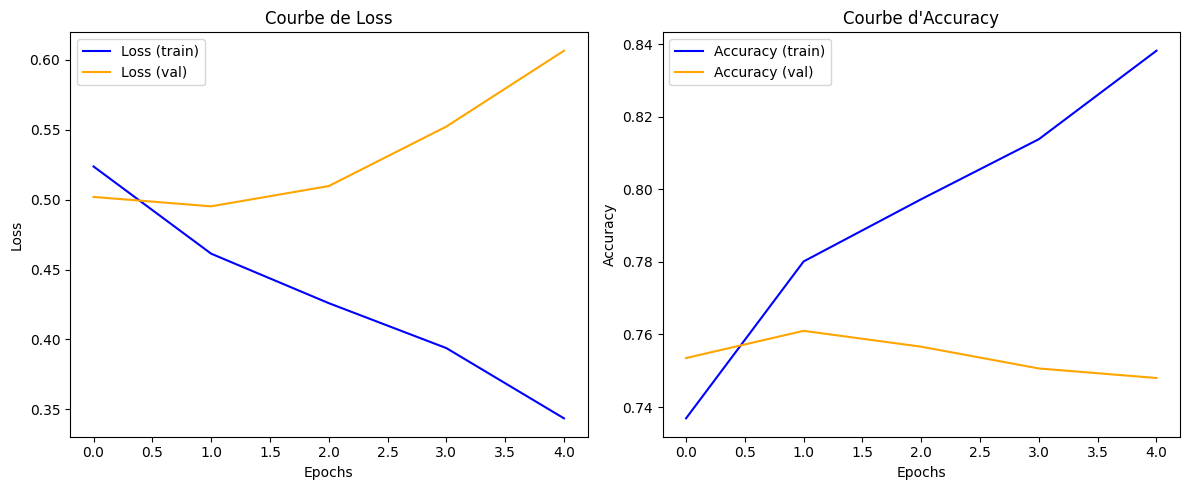

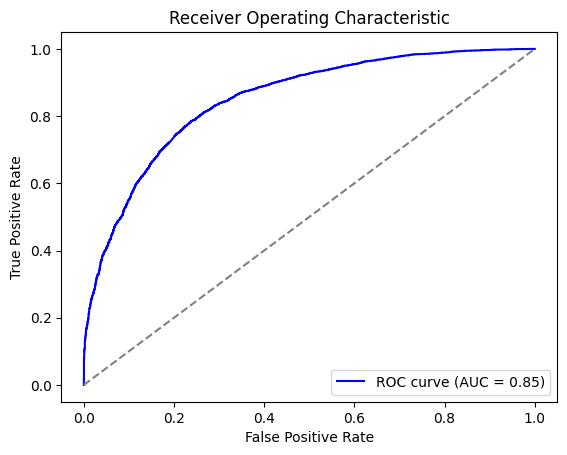

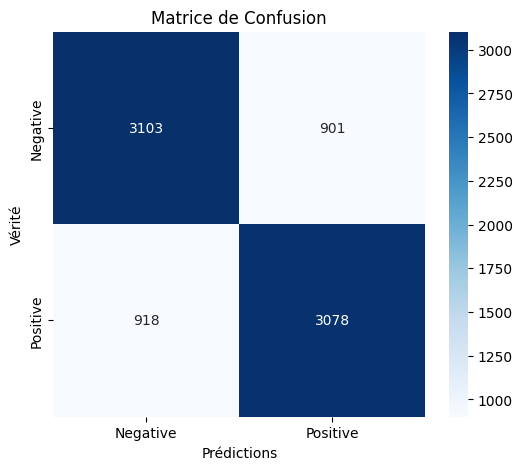

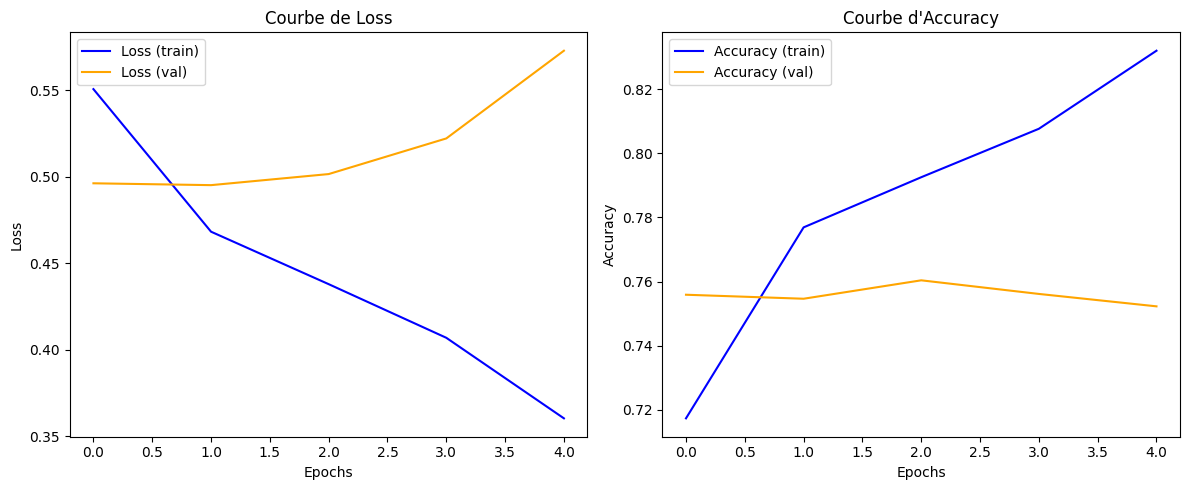

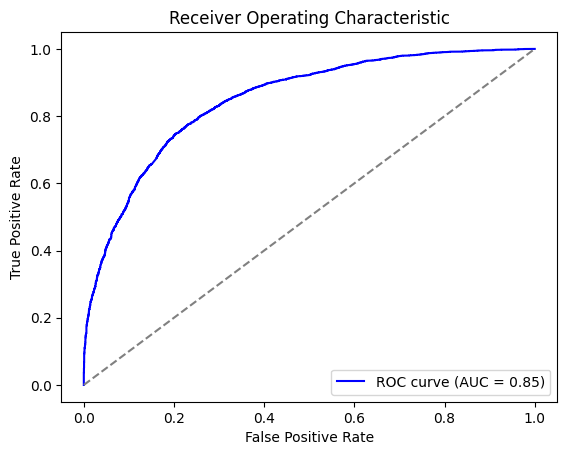

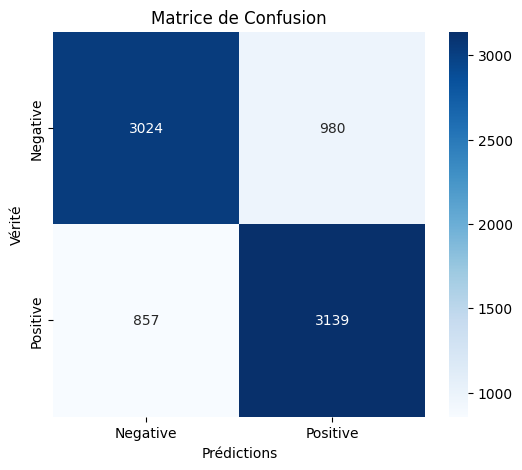

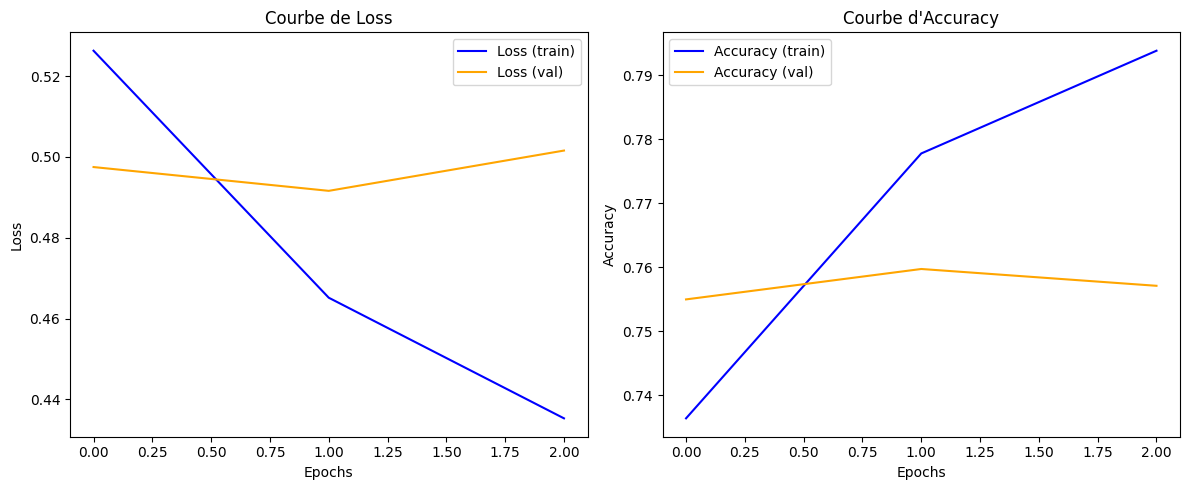

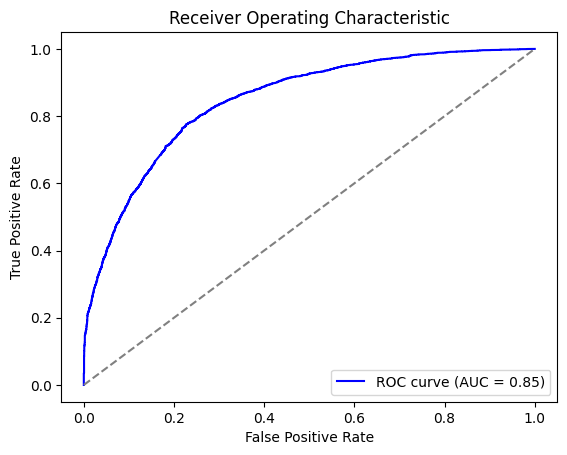

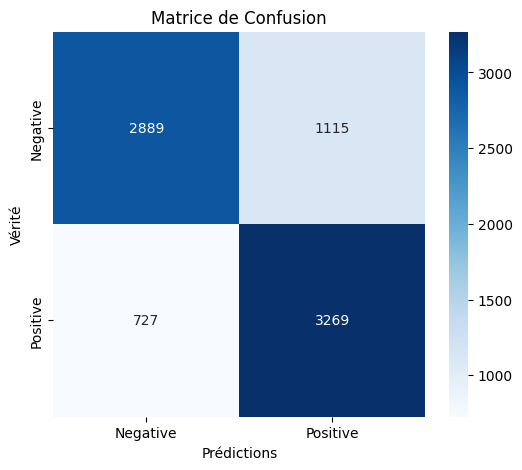

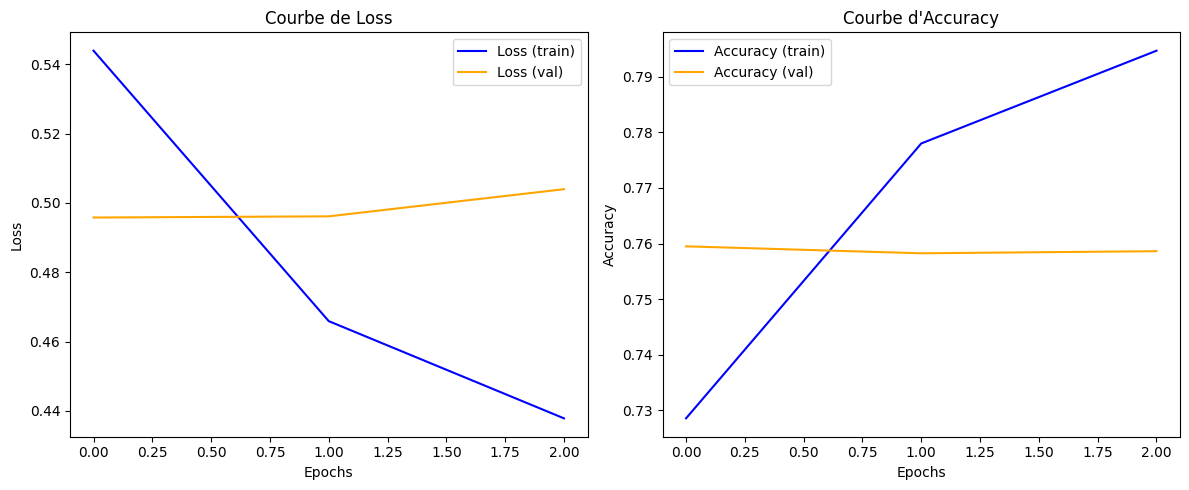

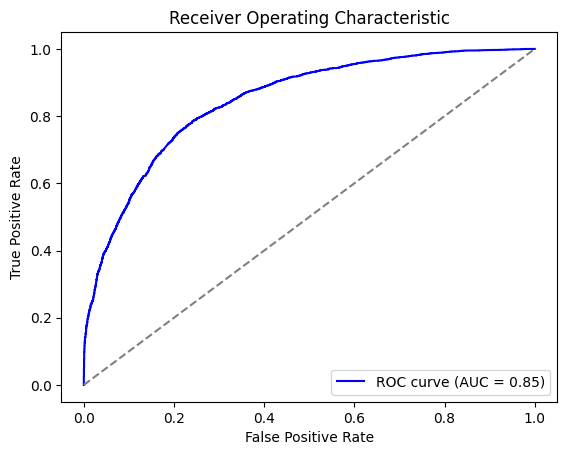

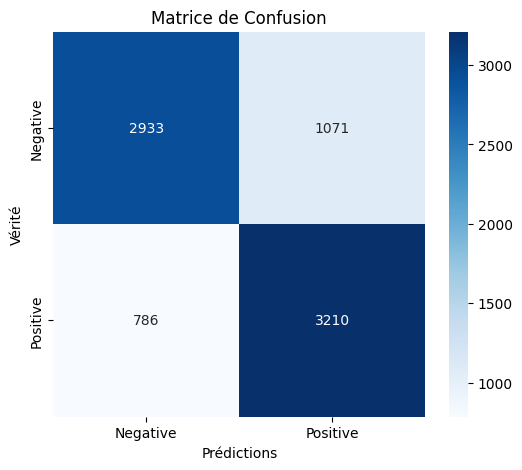

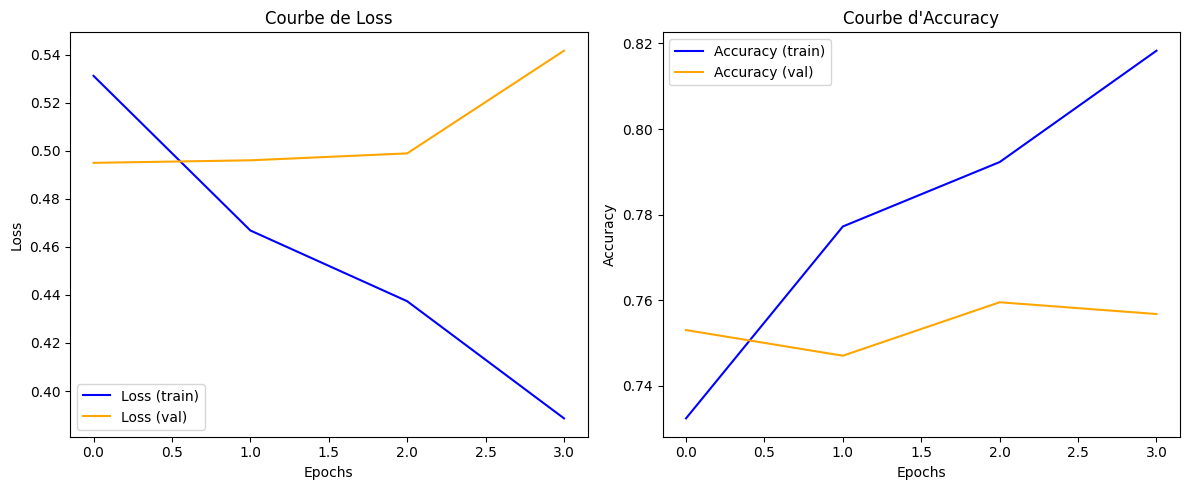

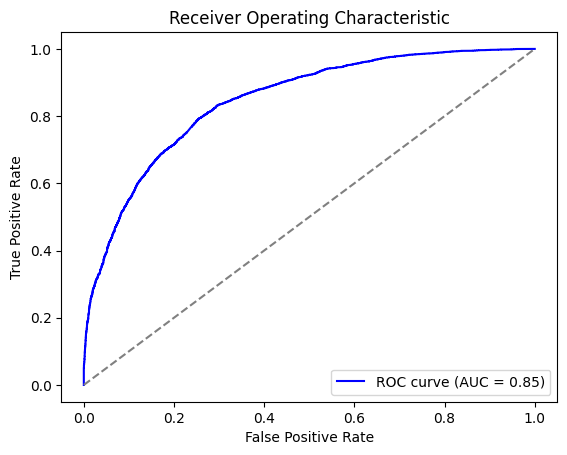

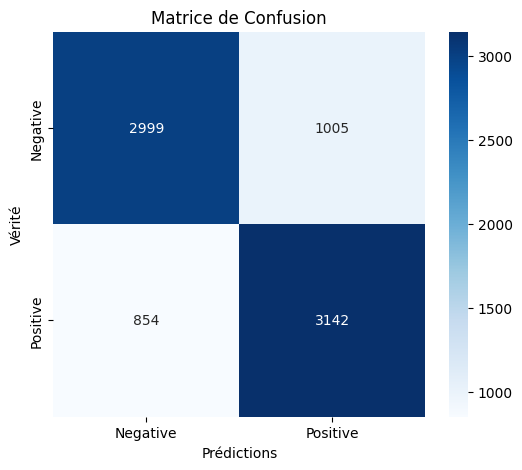

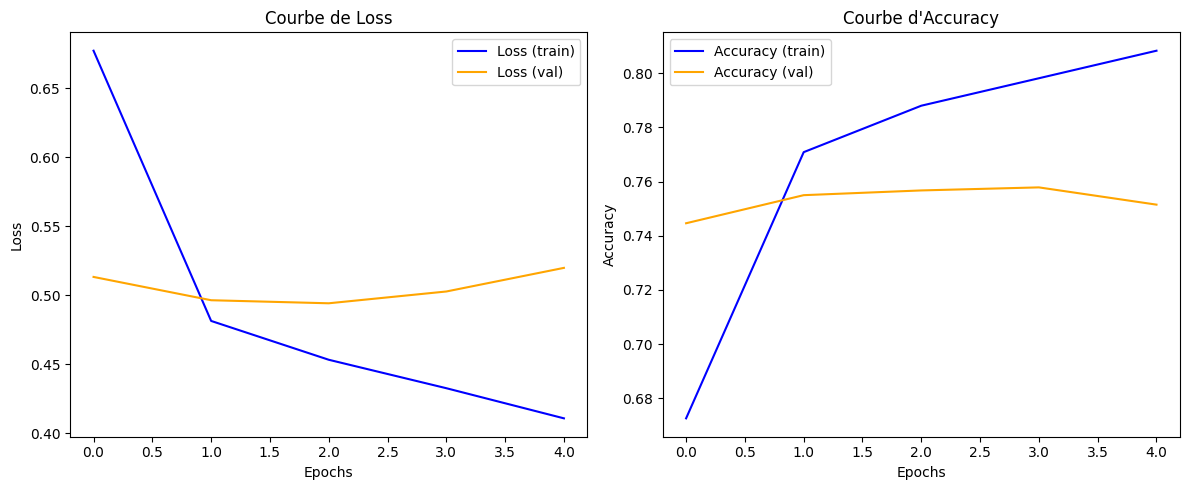

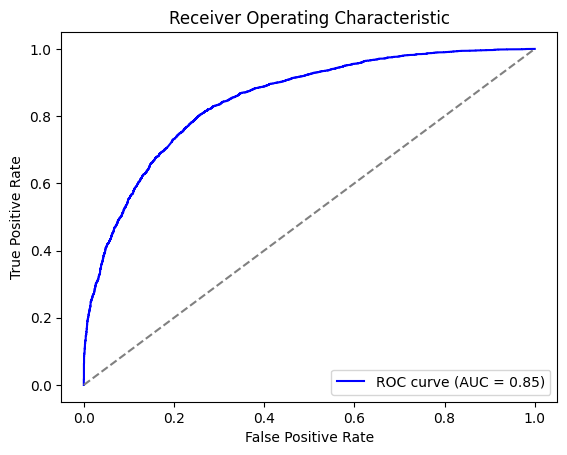

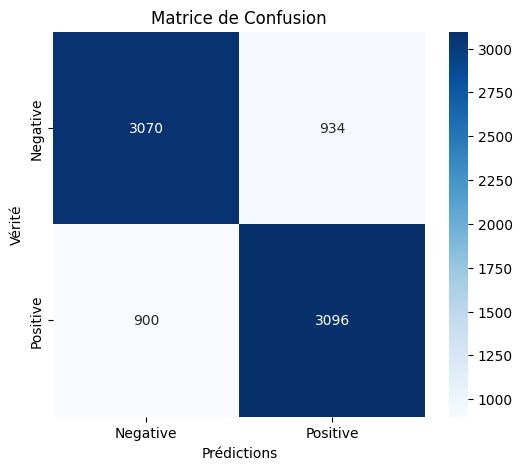

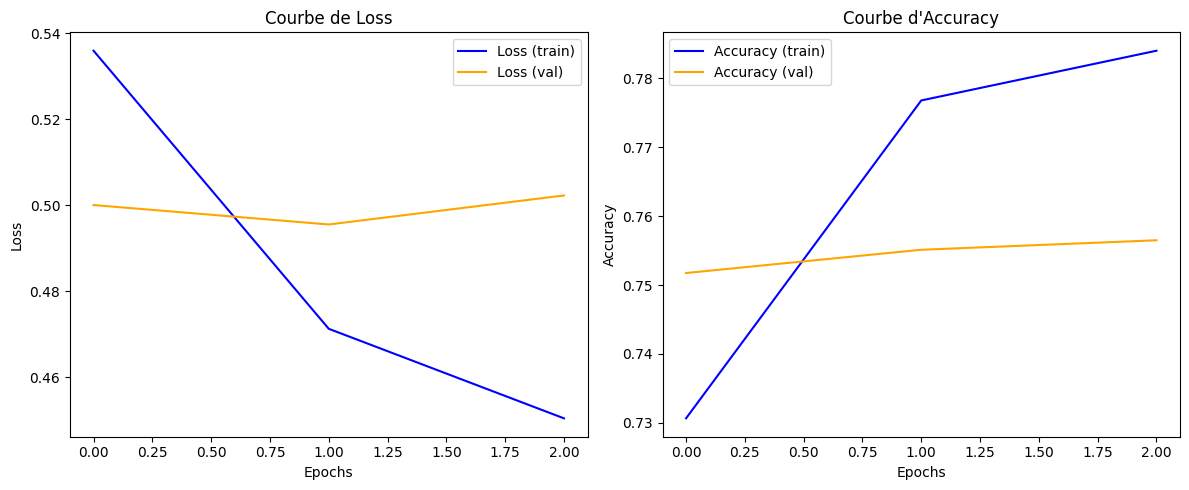

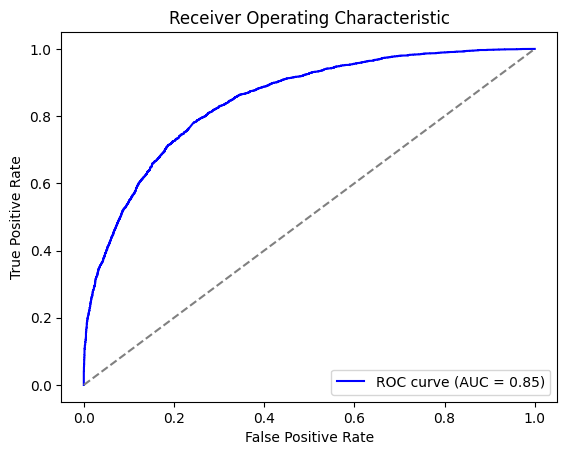

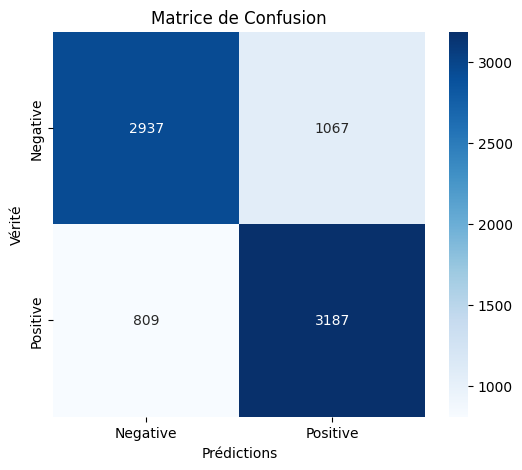

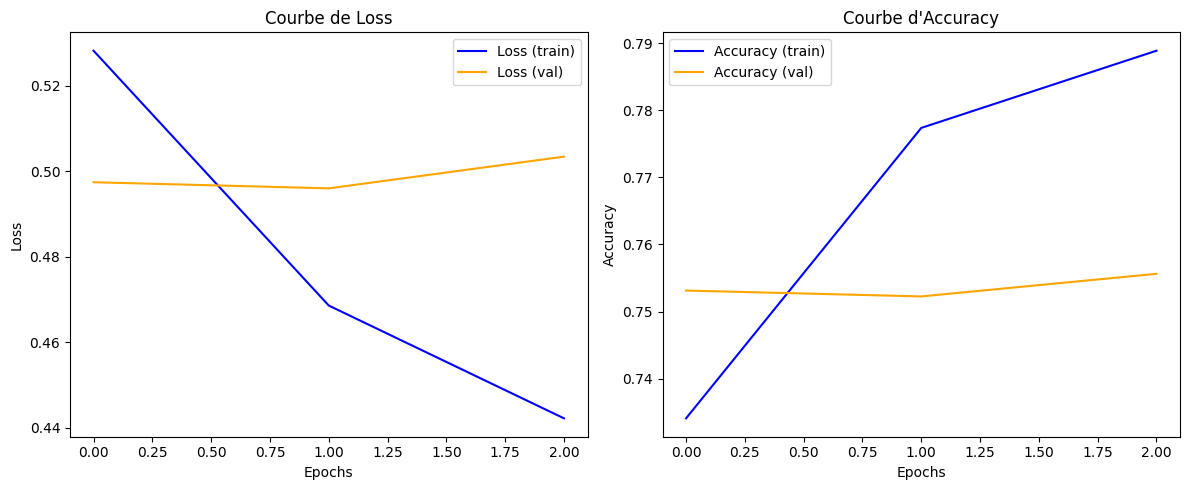

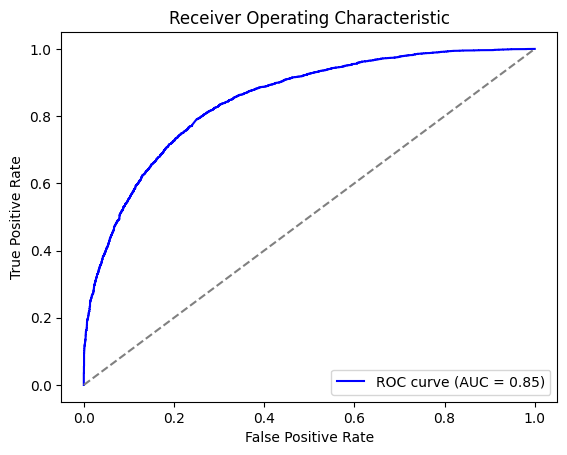

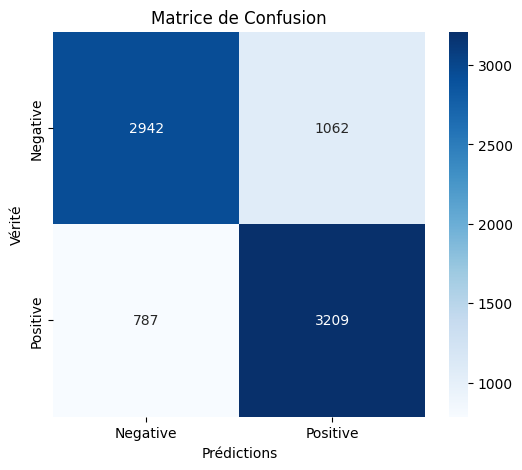

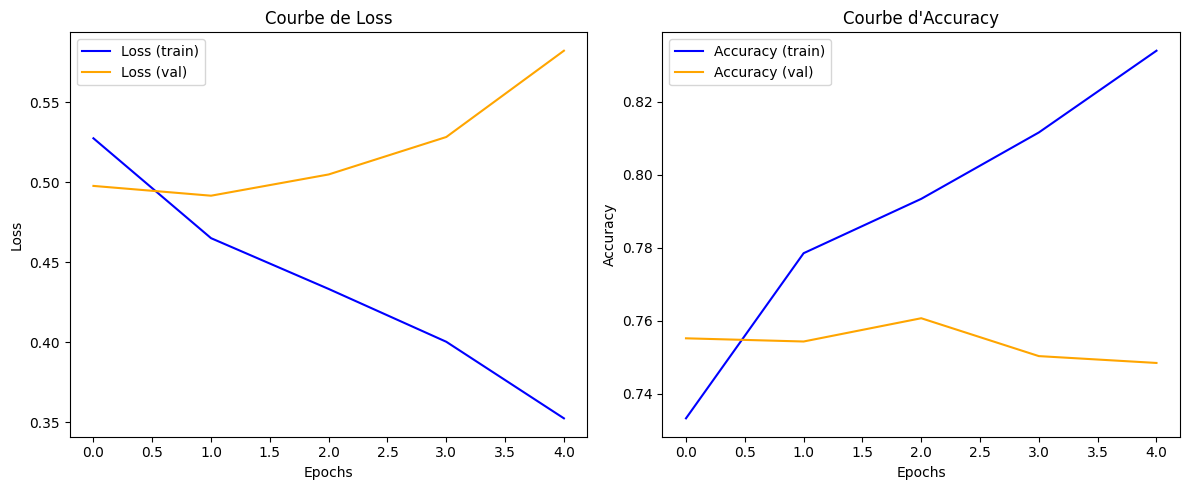

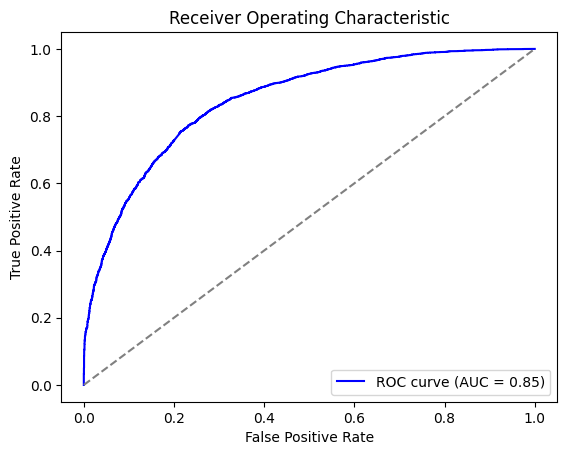

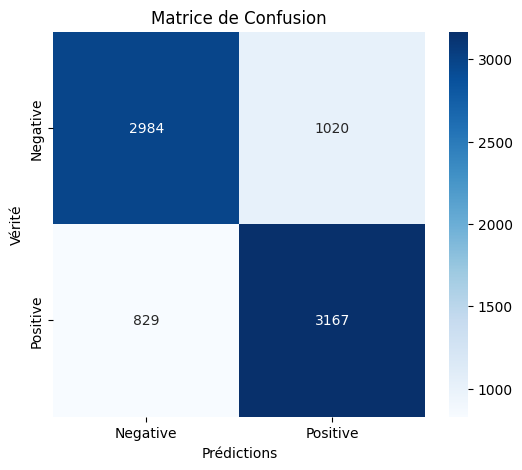

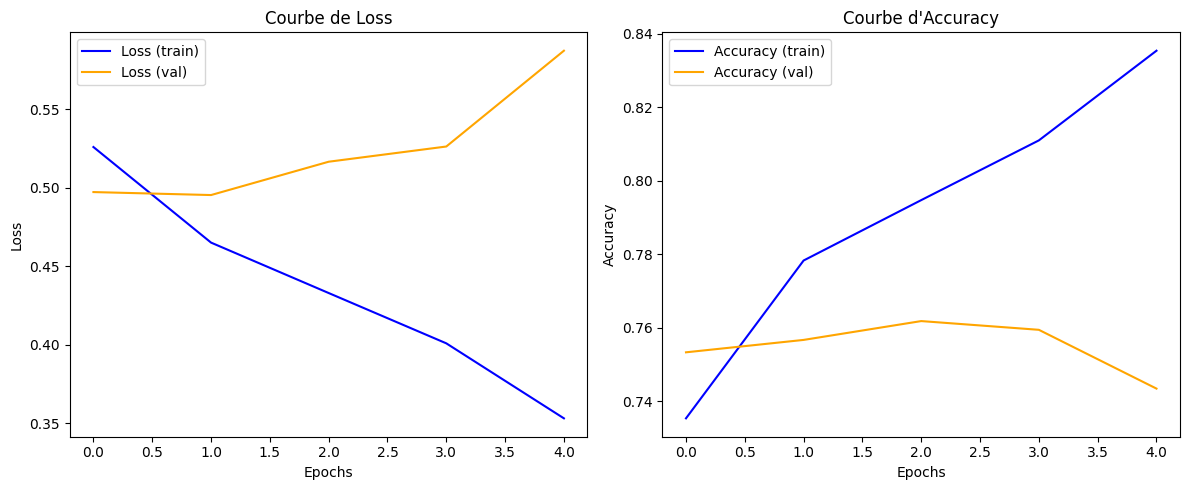

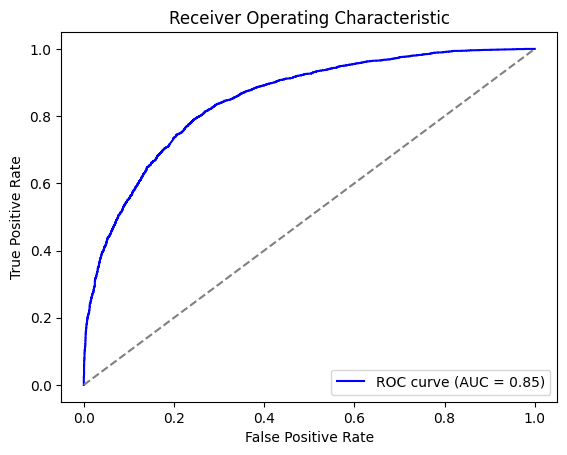

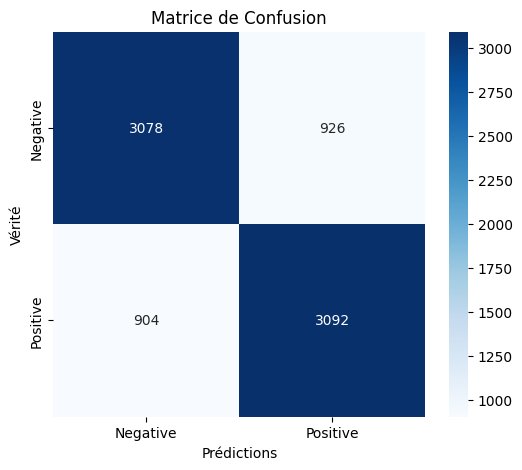

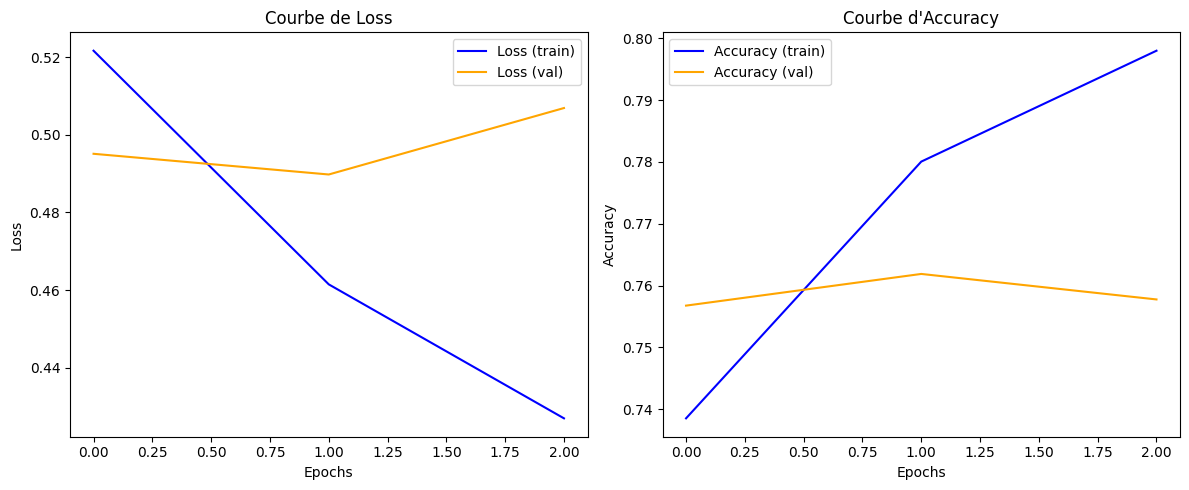

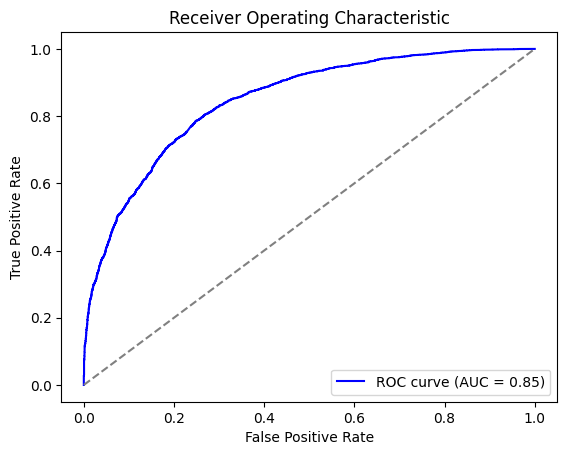

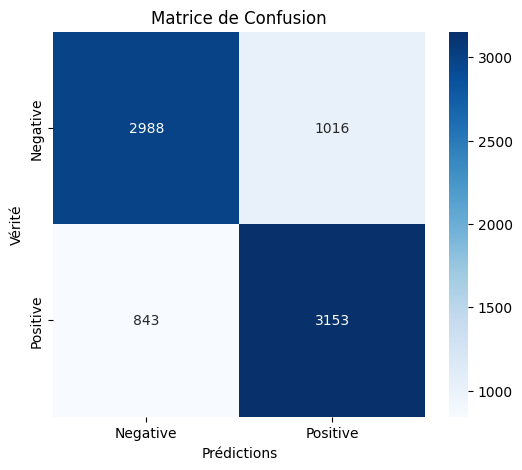

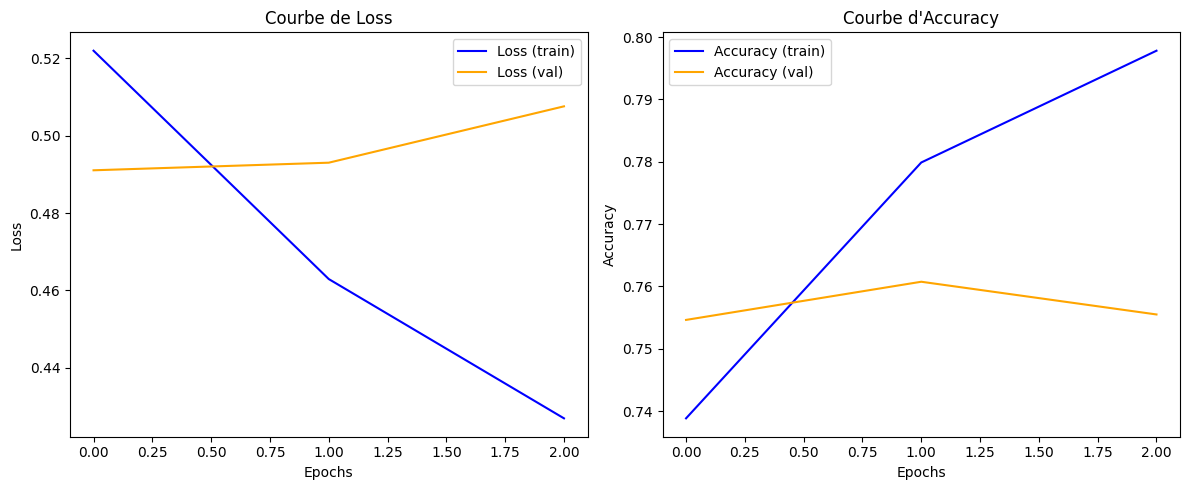

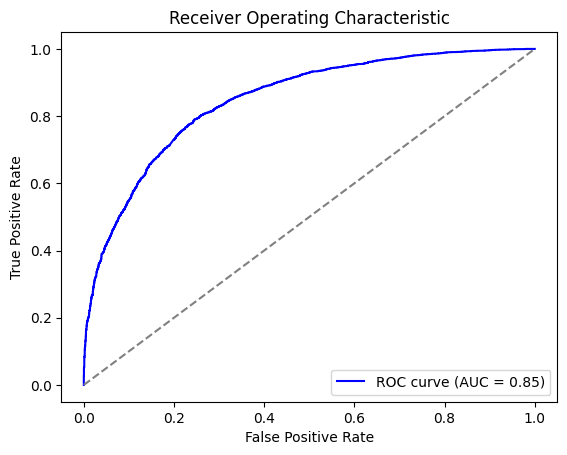

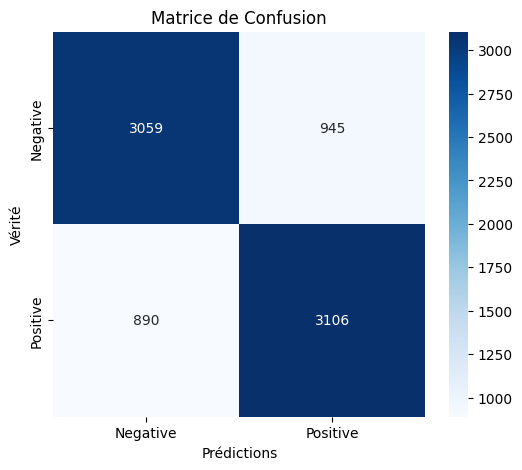

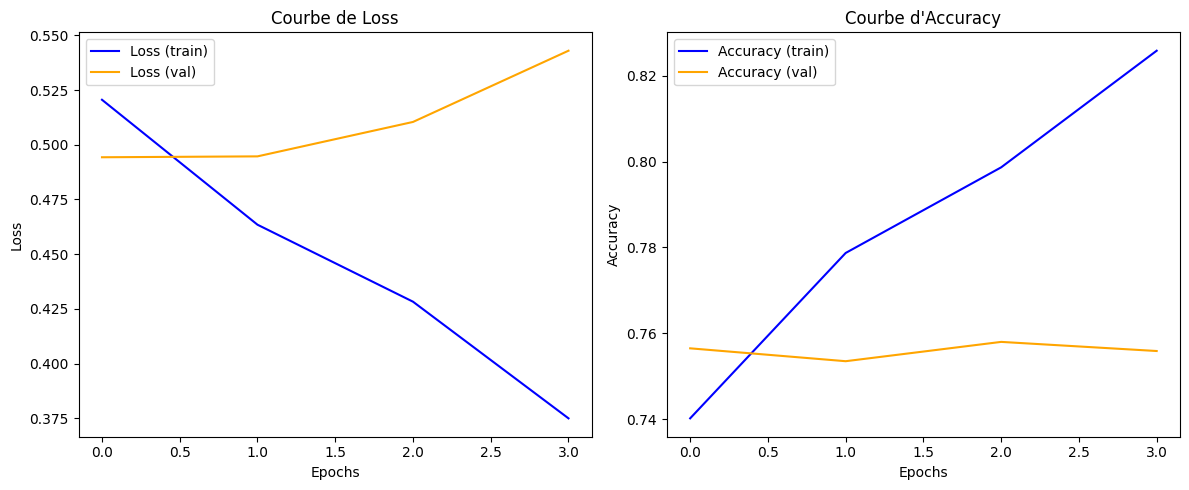

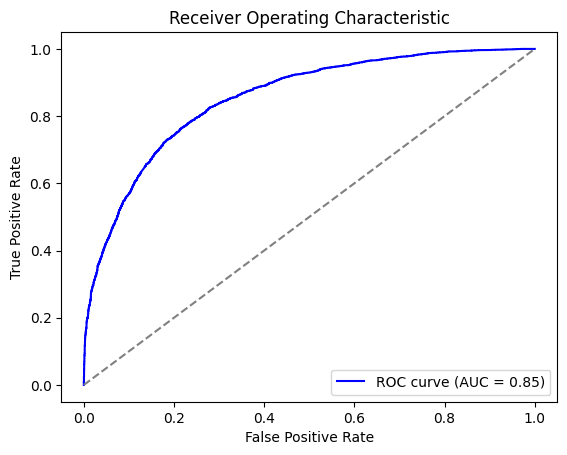

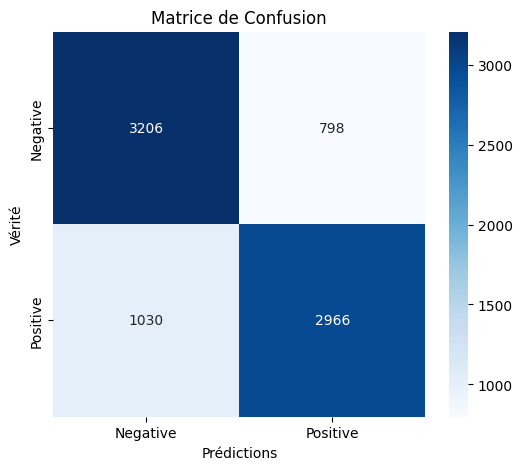

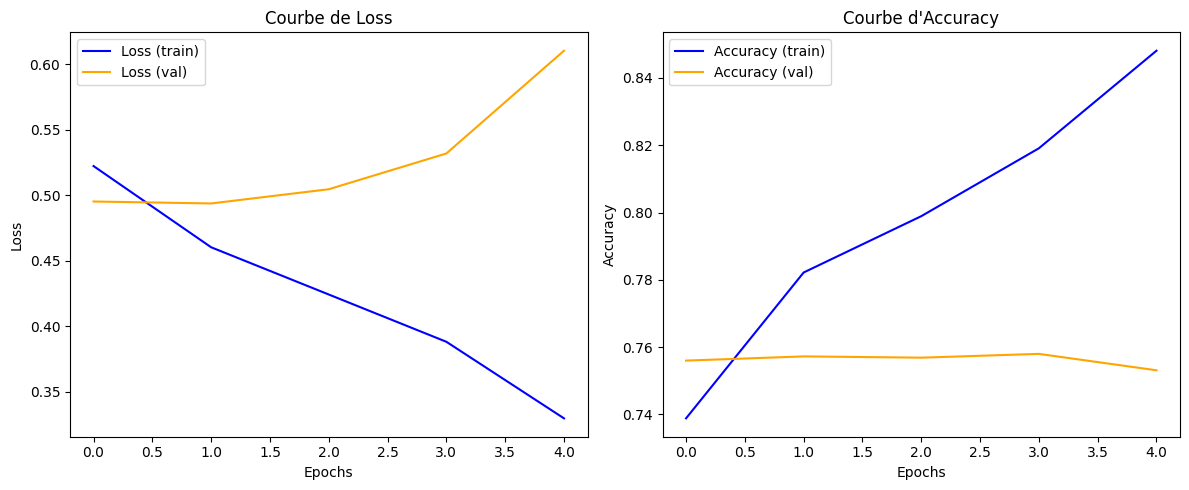

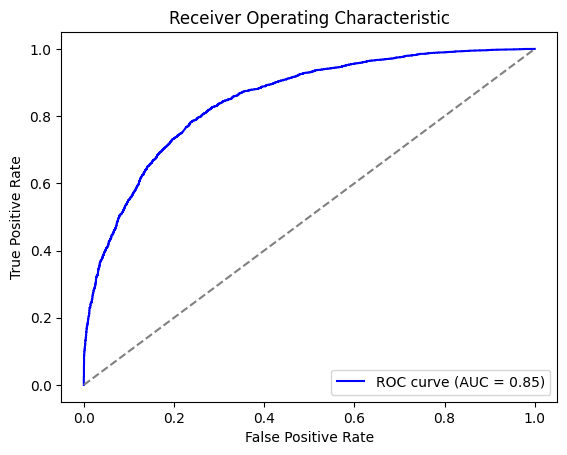

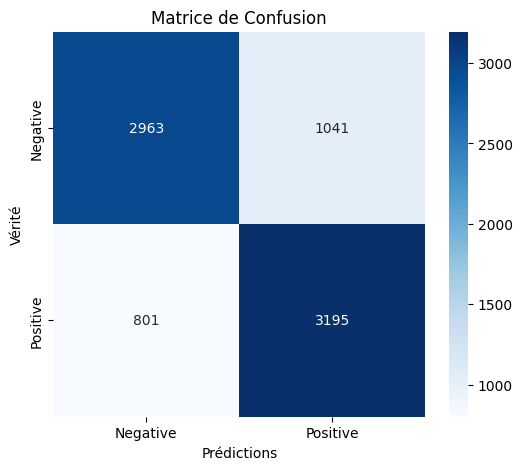

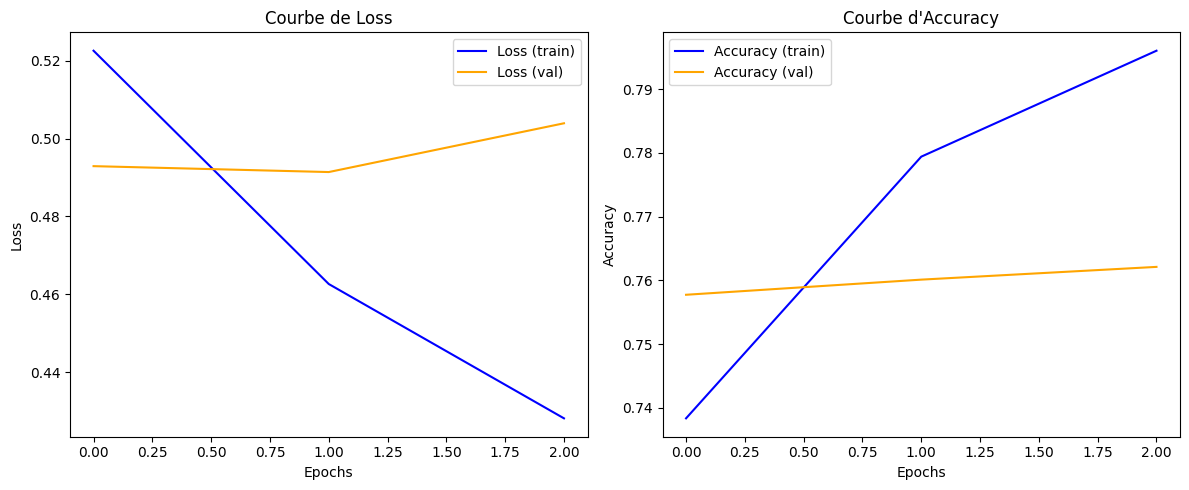

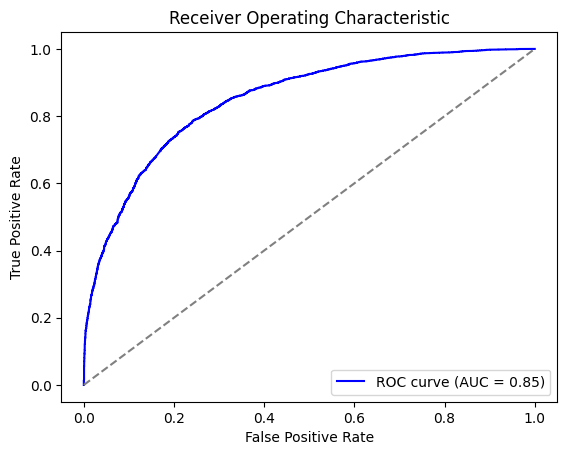

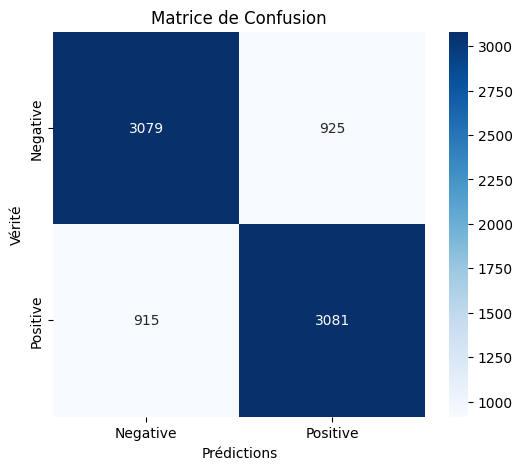

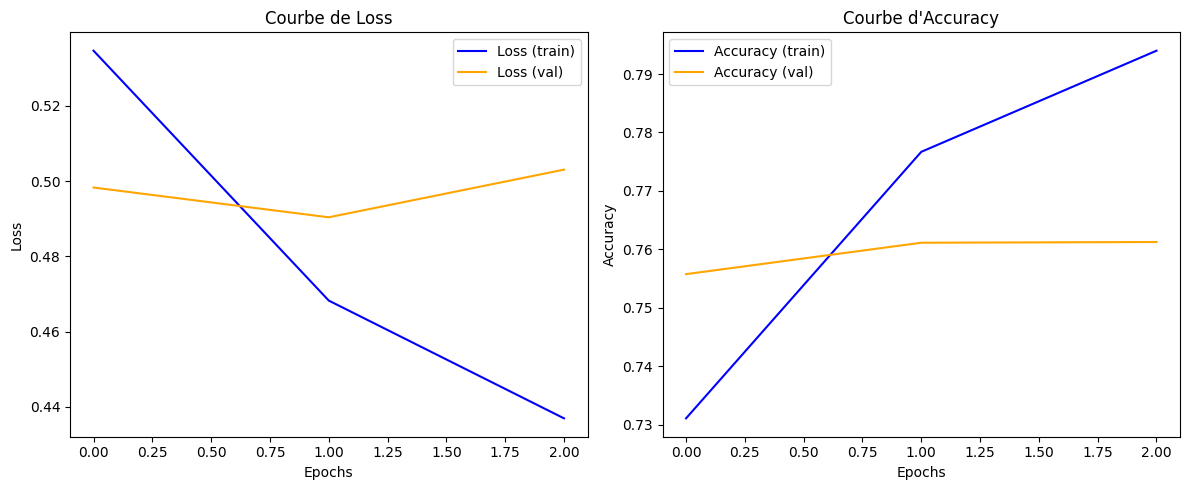

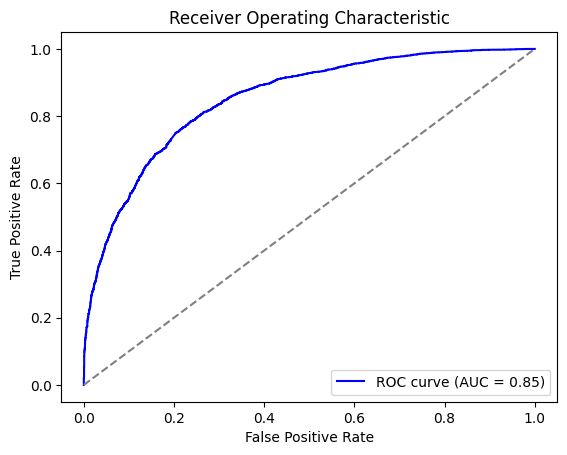

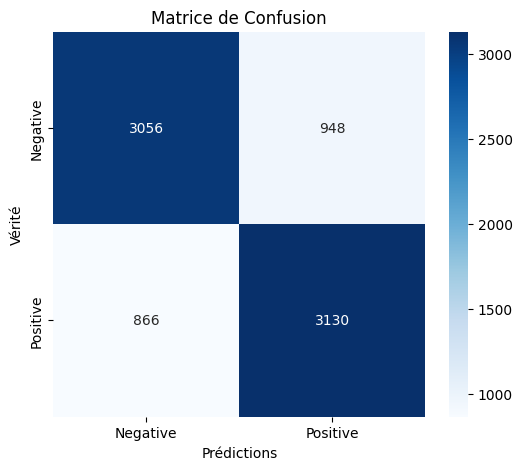

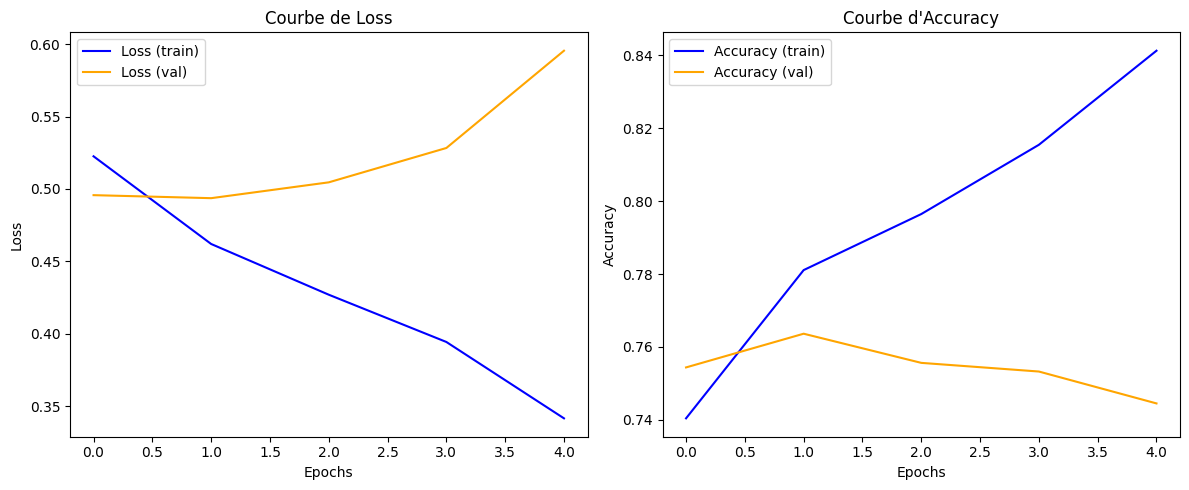

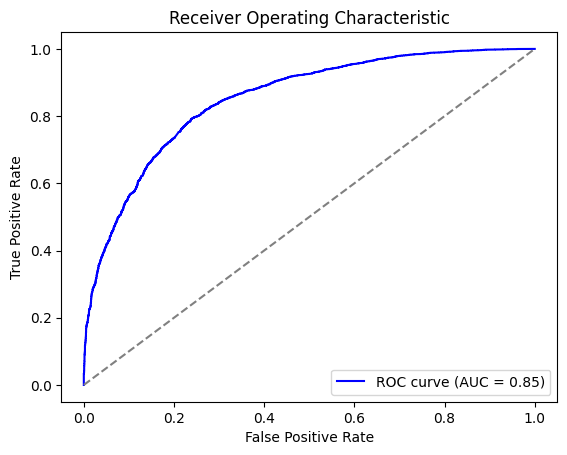

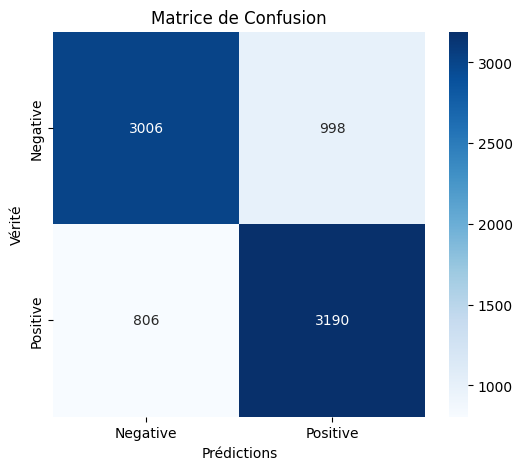

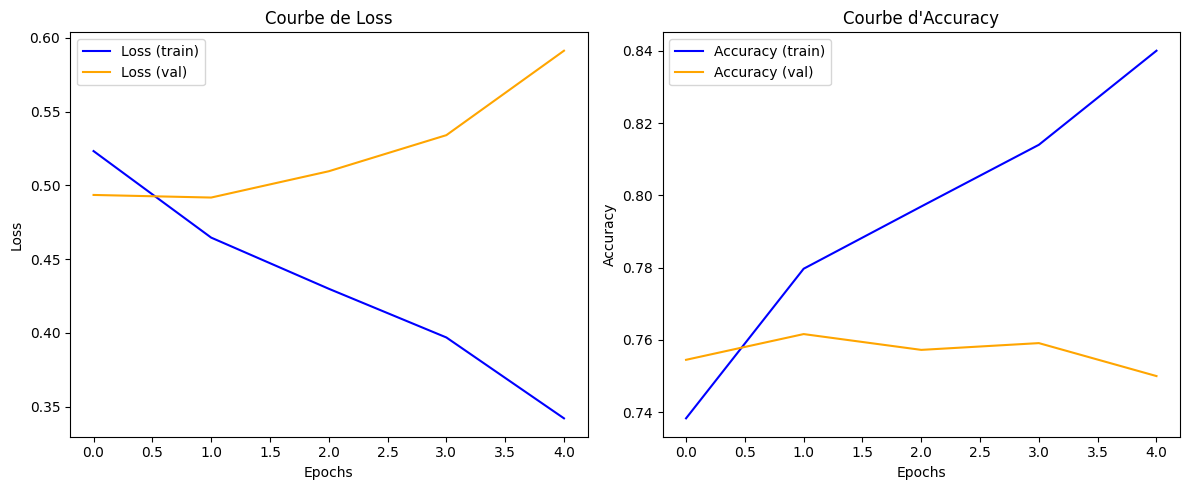

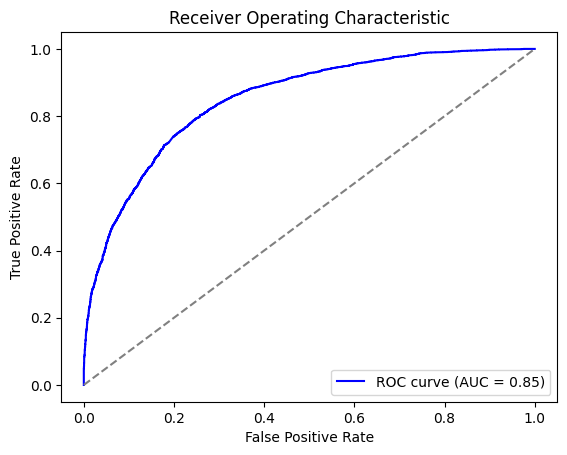

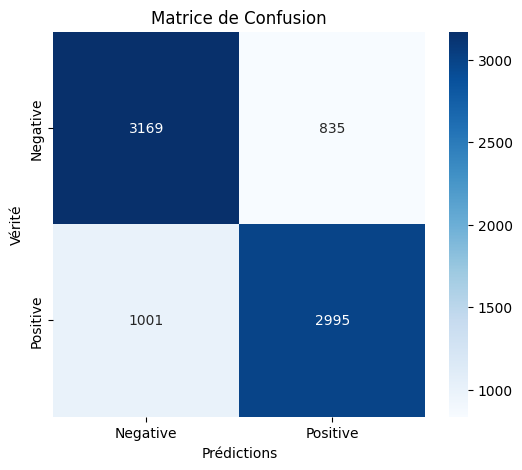

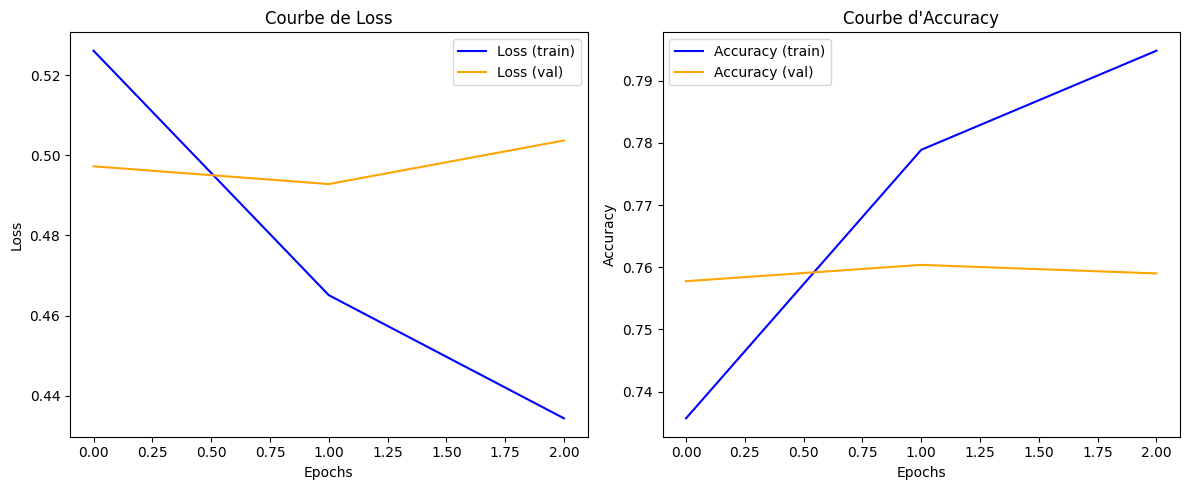

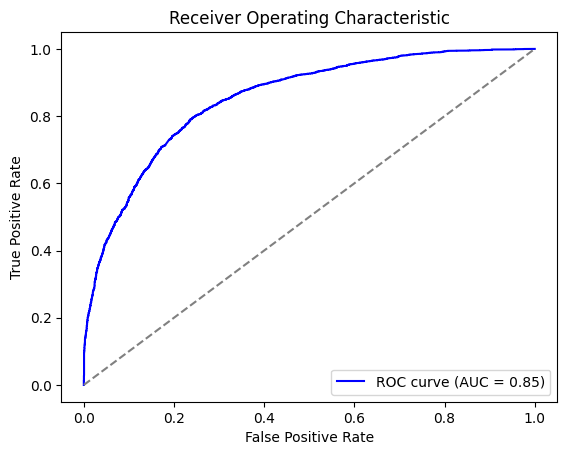

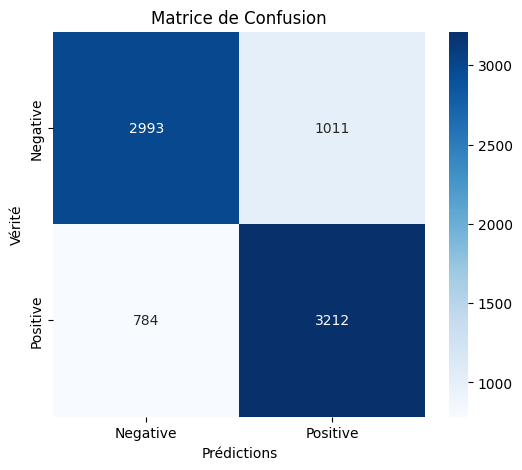

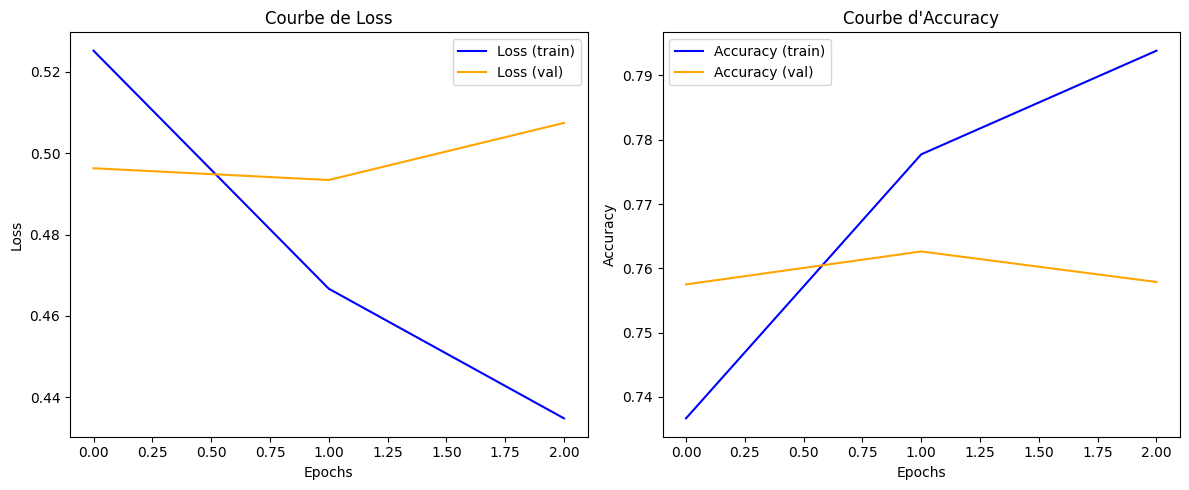

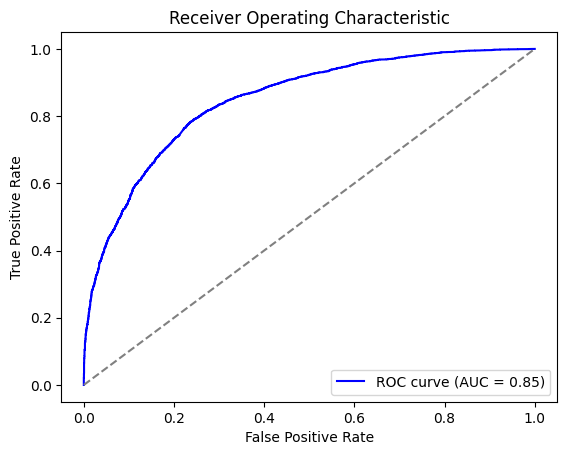

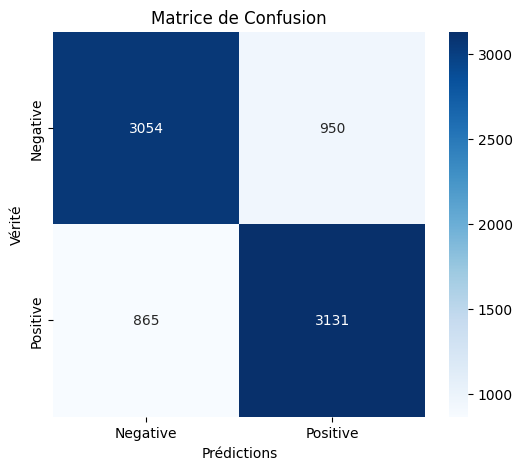

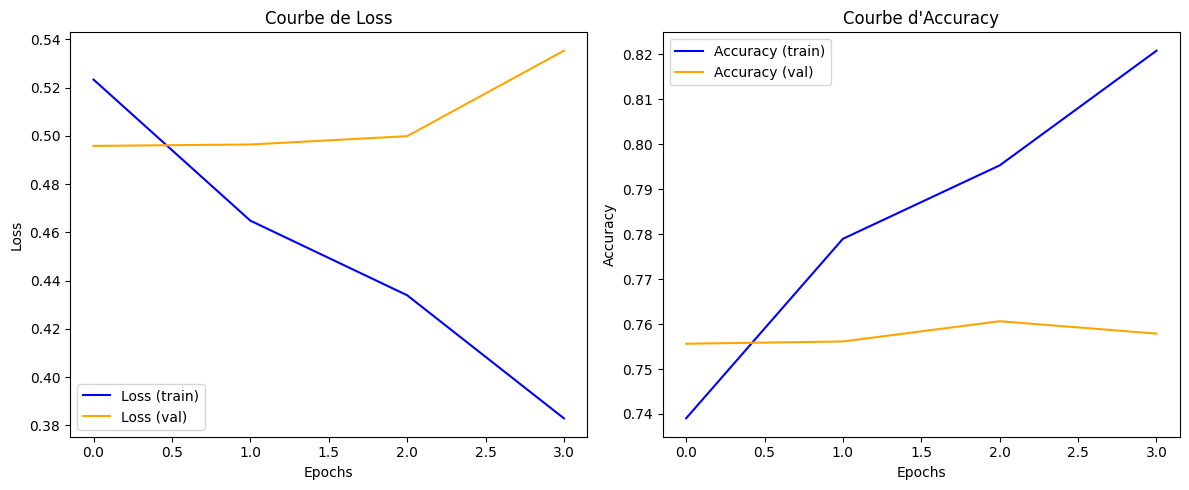

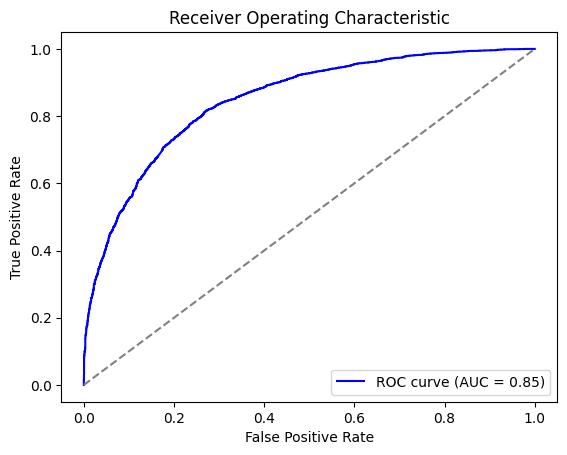

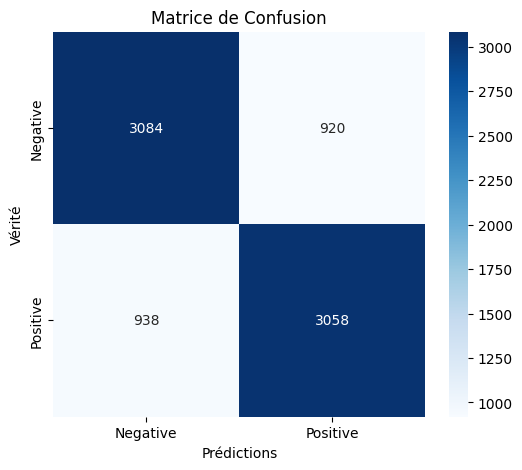

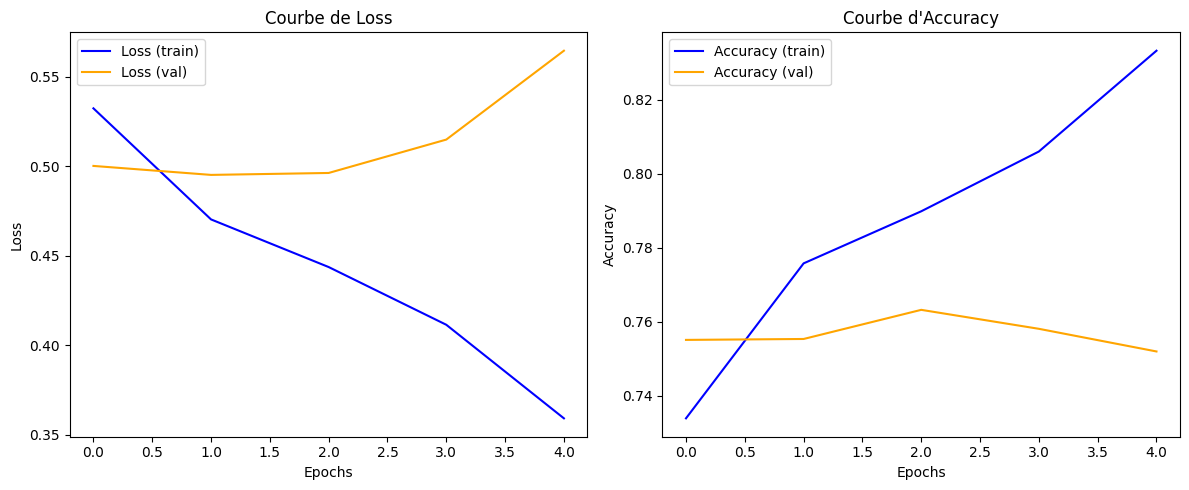

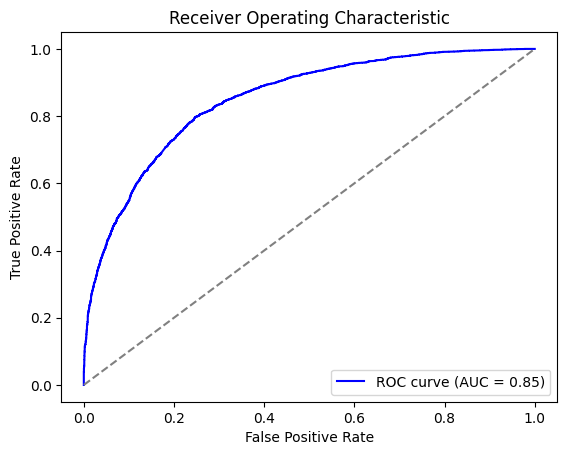

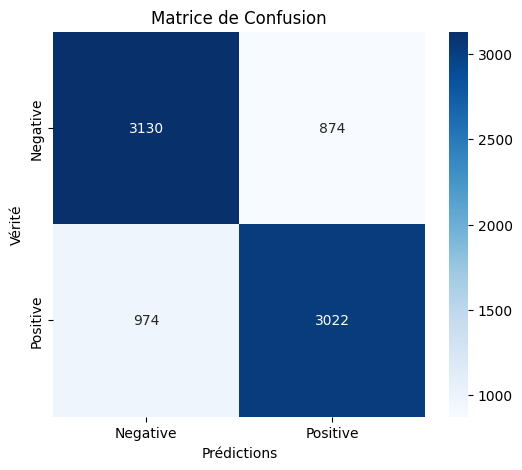

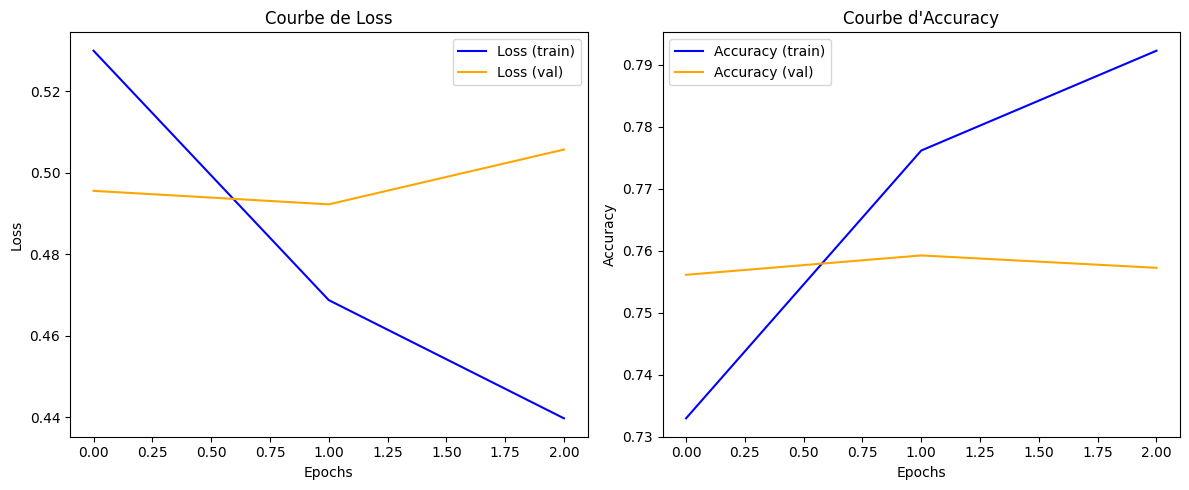

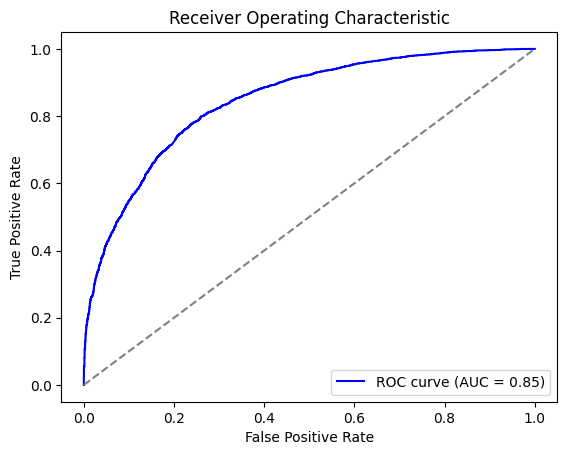

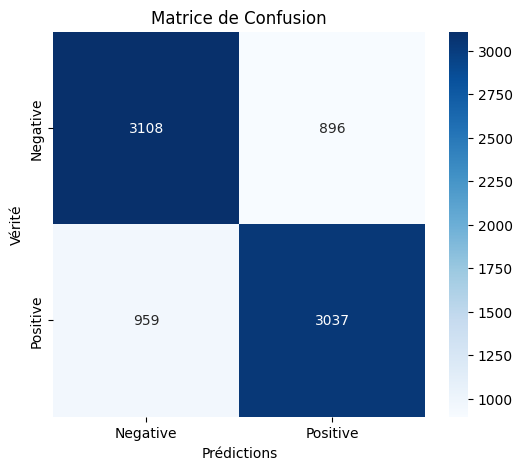

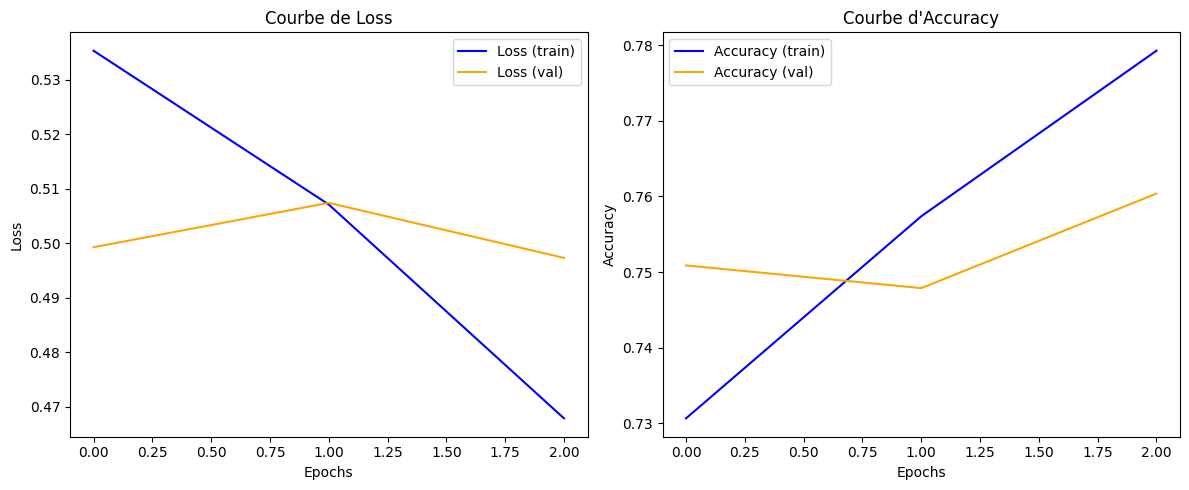

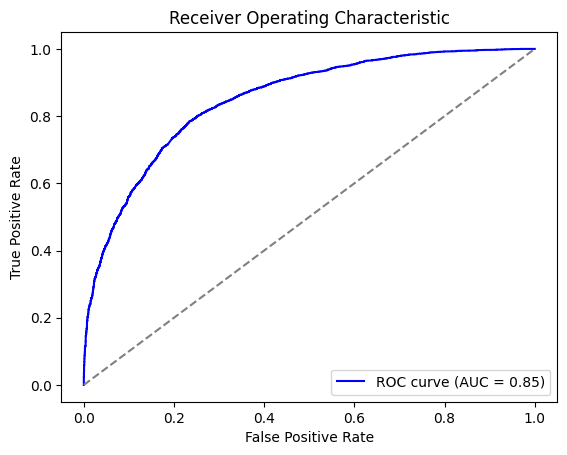

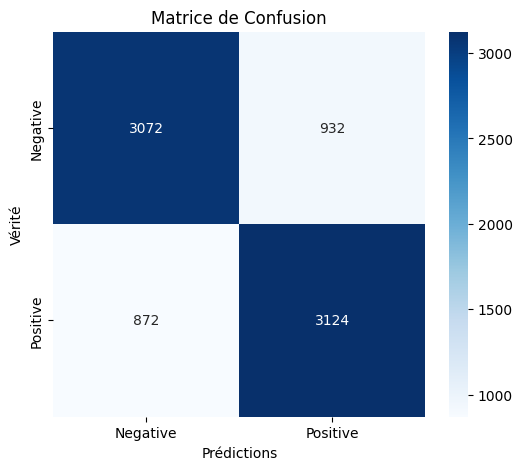

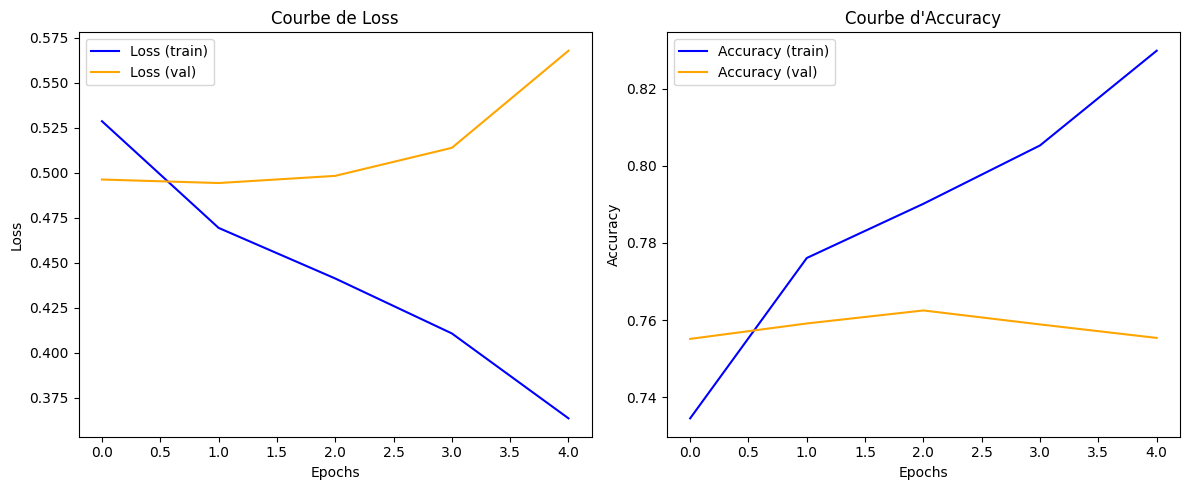

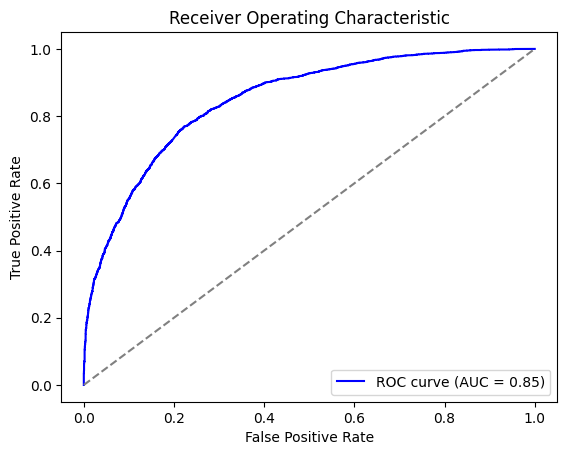

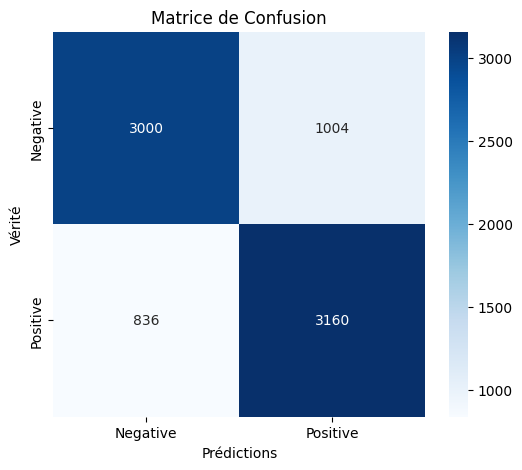

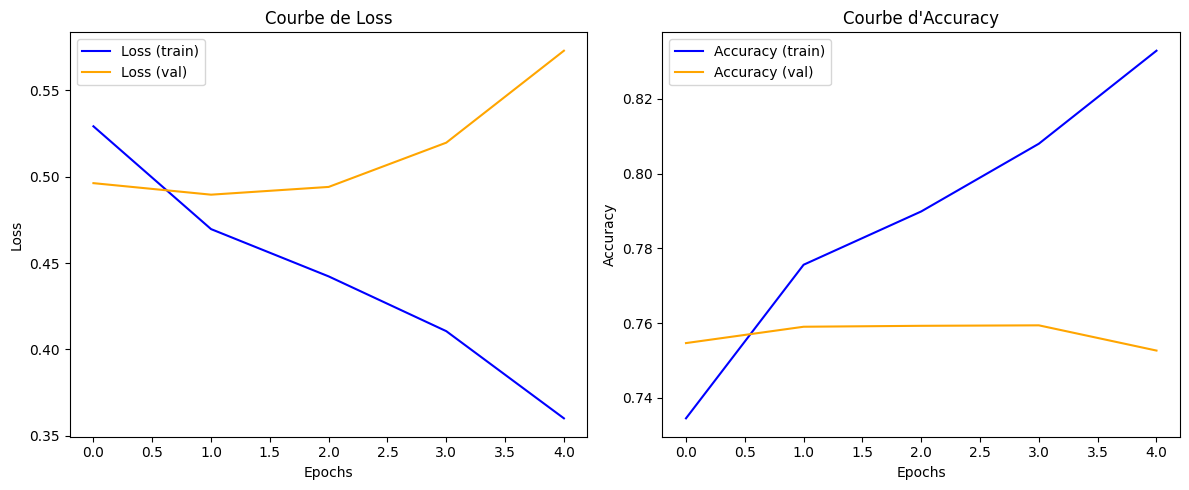

In [24]:
import mlflow
import mlflow.keras
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from sklearn.model_selection import train_test_split, ParameterGrid
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Définir l'URI du serveur MLFlow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("LSTM Experiment with Hyperparameter Tuning")

# Fonction de tracking avec MLFlow
def log_mlflow_experiment(model, X_train, y_train, X_valid, y_valid, X_test, y_test, model_name, params):
    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(params)

        start_time = time.time()

        # Ajouter EarlyStopping et ReduceLROnPlateau pour gérer les performances
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

        # Entraînement du modèle
        history = model.fit(
            X_train, y_train,
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            validation_data=(X_valid, y_valid),
            verbose=1,
            callbacks=[early_stopping, reduce_lr]
        )

        y_pred_probs = model.predict(X_test)
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()

        test_accuracy = accuracy_score(y_test, y_pred)
        test_auc = roc_auc_score(y_test, y_pred_probs)
        val_accuracy = max(history.history['val_accuracy'])

        training_time = time.time() - start_time

        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_auc", test_auc)
        mlflow.log_metric("training_time", training_time)
        mlflow.log_metric("val_accuracy", val_accuracy)

        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
        plt.figure()
        plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % test_auc)
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        roc_curve_path = f"{model_name}_roc_curve.png"
        plt.savefig(roc_curve_path)
        mlflow.log_artifact(roc_curve_path)

        # Matrice de confusion
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        plt.xlabel("Prédictions")
        plt.ylabel("Vérité")
        plt.title("Matrice de Confusion")
        cm_path = f"{model_name}_confusion_matrix.png"
        plt.savefig(cm_path)
        mlflow.log_artifact(cm_path)

        # Rapport de classification
        report_str = classification_report(y_test, y_pred)
        print(report_str)
        mlflow.log_text(report_str, f"{model_name}_classification_report.txt")

        # Enregistrement du modèle
        mlflow.keras.log_model(model, f"{model_name}_model")

        # Courbes de Loss et Accuracy
        plt.figure(figsize=(12, 5))

        # Courbe de Loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Loss (train)', color='blue')
        plt.plot(history.history['val_loss'], label='Loss (val)', color='orange')
        plt.title('Courbe de Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Courbe d'Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Accuracy (train)', color='blue')
        plt.plot(history.history['val_accuracy'], label='Accuracy (val)', color='orange')
        plt.title('Courbe d\'Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        loss_accuracy_path = f"{model_name}_loss_accuracy_curves.png"
        plt.tight_layout()
        plt.savefig(loss_accuracy_path)
        mlflow.log_artifact(loss_accuracy_path)

        print(f"Training Time: {training_time:.2f} seconds")

    return val_accuracy, test_accuracy, test_auc, training_time, model

# Fonction pour créer un modèle LSTM
def create_lstm_model(input_length, units, dropout_rate):
    model = Sequential([
        Embedding(input_dim=5000, output_dim=100, input_length=input_length),
        LSTM(units=units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Prétraitement des données textuelles
def preprocess_text_data(X_train, X_valid, X_test, column_name, max_len=500):
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train[column_name])

    X_train_seq = tokenizer.texts_to_sequences(X_train[column_name])
    X_valid_seq = tokenizer.texts_to_sequences(X_valid[column_name])
    X_test_seq = tokenizer.texts_to_sequences(X_test[column_name])

    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
    X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_len)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

    return X_train_pad, X_valid_pad, X_test_pad, tokenizer

# Chargement et division des données
subset_data = data.sample(n=80000, random_state=42)

X_train, X_temp, y_train, y_temp = train_test_split(
    subset_data[['cleaned_text_lemmatized', 'cleaned_text_stemmed']], 
    subset_data['target'], 
    test_size=0.2, 
    random_state=42
)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Remplacement des NaN
for col in ['cleaned_text_lemmatized', 'cleaned_text_stemmed']:
    X_train[col].fillna('', inplace=True)
    X_valid[col].fillna('', inplace=True)
    X_test[col].fillna('', inplace=True)

# Prétraitement
X_train_pad_lemmatized, X_valid_pad_lemmatized, X_test_pad_lemmatized, tokenizer_lemmatized = preprocess_text_data(
    X_train, X_valid, X_test, 'cleaned_text_lemmatized'
)

X_train_pad_stemmed, X_valid_pad_stemmed, X_test_pad_stemmed, tokenizer_stemmed = preprocess_text_data(
    X_train, X_valid, X_test, 'cleaned_text_stemmed'
)

# Grille d'hyperparamètres
param_grid = {
    'units': [64, 128],
    'dropout_rate': [0.2, 0.4],
    'batch_size': [32, 64],
    'epochs': [3, 5]
}

def format_params(params):
    """Convertit un dictionnaire d'hyperparamètres en une chaîne sans caractères spéciaux"""
    return "_".join([f"{key}-{value}" for key, value in params.items()])

# Optimisation
best_params = None
best_val_accuracy = 0
best_model = None

print("Testing Lemmatized Data...")
for params in ParameterGrid(param_grid):
    model_name = f"LSTM_Lemmatized_{format_params(params)}"
    model = create_lstm_model(input_length=500, units=params['units'], dropout_rate=params['dropout_rate'])
    val_accuracy, test_accuracy, auc_score, training_time, trained_model = log_mlflow_experiment(
        model, X_train_pad_lemmatized, y_train, X_valid_pad_lemmatized, y_valid, X_test_pad_lemmatized, y_test, 
        model_name=model_name, params=params
    )
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params
        best_model = trained_model

print("Testing Stemmed Data...")
for params in ParameterGrid(param_grid):
    model_name = f"LSTM_Stemmed_{format_params(params)}"
    model = create_lstm_model(input_length=500, units=params['units'], dropout_rate=params['dropout_rate'])
    val_accuracy, test_accuracy, auc_score, training_time, trained_model = log_mlflow_experiment(
        model, X_train_pad_stemmed, y_train, X_valid_pad_stemmed, y_valid, X_test_pad_stemmed, y_test, 
        model_name=model_name, params=params
    )
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params
        best_model = trained_model

# Enregistrer le meilleur modèle
with mlflow.start_run(run_name="Best_LSTM_Model"):
    mlflow.log_params(best_params)
    mlflow.log_metric("best_val_accuracy", best_val_accuracy)
    mlflow.keras.log_model(best_model, "best_lstm_model")
    print(f"Best Model is saved as 'best_lstm_model' with Validation Accuracy: {best_val_accuracy}")




### Performance globale :
- Le modèle atteint une **accuracy** autour de **77%** sur le test set.
- Les scores **precision**, **recall** et **F1-score** sont également équilibrés entre les classes 0 et 1.
- La **loss de validation** stagne ou augmente légèrement après quelques epochs, ce qui peut indiquer un **début d'overfitting**.

### Comparaison des architectures :
| Unités LSTM | Temps d'entraînement | Validation Accuracy |
|-------------|----------------------|---------------------|
| **64**      | **716 sec**           | **75.65%**         |
| **128**     | **1639 sec**          | **75.86%**         |

- **Avec 64 unités**, l'entraînement est plus rapide (**716 sec**) mais donne une **val_accuracy** de **75.65%**.
- **Avec 128 unités**, l'entraînement est **plus long** (**1639 sec**), mais l'amélioration est **minime** (**75.86%**).
- **Avec 5 epochs**, la tendance reste la même (**pas de grosse amélioration**).

### Recommandations :
- Tester un **early stopping** basé sur la validation loss pour éviter l’overfitting.
- Essayer une **réduction du learning rate** pour voir si l’apprentissage se stabilise.
- Comparer avec une **autre architecture** (ex: BiLSTM, GRU) pour voir si l’augmentation de la complexité apporte un réel gain.


## - <a href="#C7">2.2 LSTM et embeddings GloVe pré-entraînés.</a>


Le modèle est un **LSTM** utilisé pour la **classification binaire** des tweets. Je charge des **embeddings GloVe** pré-entraînés de 50 dimensions, puis j’ajoute **deux couches LSTM** pour capter les dépendances temporelles. Des **couches Dropout** sont appliquées pour éviter l'overfitting. La sortie est une **couche Dense** avec activation **sigmoïde** pour prédire la classe. J’utilise **Adam** comme optimiseur et **early stopping** pour prévenir l'overfitting. Je suis et enregistre les résultats avec **MLflow**.


| Élément         | Description                                                                 |
|-----------------|-----------------------------------------------------------------------------|
| 🎯 Objectif     | Classification de texte (tweets) avec un modèle LSTM et embeddings GloVe.   |
| 🔧 Prétraitement| - Nettoyage (lemmatisation) <br> - Tokenisation & padding des séquences.   |
| 🔍 Données      | Séparation en 80% train, 10% validation, 10% test après nettoyage.          |
| 🔑 Embeddings   | Chargement de GloVe (50D) pour représenter les mots.                        |
| 🧠 Modèle       | Modèle LSTM avec : <br> - 2 couches LSTM pour capturer la dépendance temporelle. <br> - Dropout pour régularisation. <br> - Couche Dense (sigmoïde) pour classification binaire. |
| ⚙️ Optimisation | Perte **binary_crossentropy**, optimiseur **Adam**, **EarlyStopping** pour éviter l'overfitting. |
| 📊 MLFlow       | Suivi des métriques, modèle et courbes pendant l'entraînement.              |
| 📈 Évaluation   | **Test Accuracy**, courbes **Loss/Accuracy**, courbe **ROC** avec **AUC**.  |


100%|██████████| 156831/156831 [00:09<00:00, 16547.05it/s]
C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025/03/05 09:18:18 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential_3' has no defined input shape yet.
2025/03/05 09:18:18 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/10
39208/39208 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7217 - loss: 0.5440

39208/39208 ━━━━━━━━━━━━━━━━━━━━ 4196s 107ms/step - accuracy: 0.7217 - loss: 0.5440 - val_accuracy: 0.7756 - val_loss: 0.4685
Epoch 2/10
39208/39208 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7802 - loss: 0.4630

39208/39208 ━━━━━━━━━━━━━━━━━━━━ 3754s 96ms/step - accuracy: 0.7802 - loss: 0.4630 - val_accuracy: 0.7824 - val_loss: 0.4573
Epoch 3/10
39208/39208 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7904 - loss: 0.4460

39208/39208 ━━━━━━━━━━━━━━━━━━━━ 4071s 104ms/step - accuracy: 0.7904 - loss: 0.4460 - val_accuracy: 0.7830 - val_loss: 0.4542
Epoch 4/10
39208/39208 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7953 - loss: 0.4371

39208/39208 ━━━━━━━━━━━━━━━━━━━━ 4793s 122ms/step - accuracy: 0.7953 - loss: 0.4371 - val_accuracy: 0.7875 - val_loss: 0.4501
Epoch 5/10
39208/39208 ━━━━━━━━━━━━━━━━━━━━ 4898s 125ms/step - accuracy: 0.8005 - loss: 0.4283 - val_accuracy: 0.7875 - val_loss: 0.4508
Epoch 6/10
39208/39208 ━━━━━━━━━━━━━━━━━━━━ 5339s 136ms/step - accuracy: 0.8043 - loss: 0.4224 - val_accuracy: 0.7863 - val_loss: 0.4546
Epoch 7/10
39208/39208 ━━━━━━━━━━━━━━━━━━━━ 5638s 144ms/step - accuracy: 0.8071 - loss: 0.4174 - val_accuracy: 0.7869 - val_loss: 0.4544
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


2025/03/05 18:24:06 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmp9fjz2cl6\model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 


4901/4901 ━━━━━━━━━━━━━━━━━━━━ 318s 65ms/step - accuracy: 0.7866 - loss: 0.4515


2025/03/05 18:29:30 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


✅ Modèle sauvegardé en local sous '_model_lstm_glove.h5'


2025/03/05 18:29:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpb3wjh769\model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/05 18:29:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test Accuracy: 0.7854, Test Loss: 0.4525
4901/4901 ━━━━━━━━━━━━━━━━━━━━ 292s 59ms/step

 Rapport de classification :
              precision    recall  f1-score        support
0              0.779943  0.793157  0.786495   78151.000000
1              0.791031  0.777720  0.784319   78680.000000
accuracy       0.785412  0.785412  0.785412       0.785412
macro avg      0.785487  0.785438  0.785407  156831.000000
weighted avg   0.785506  0.785412  0.785403  156831.000000


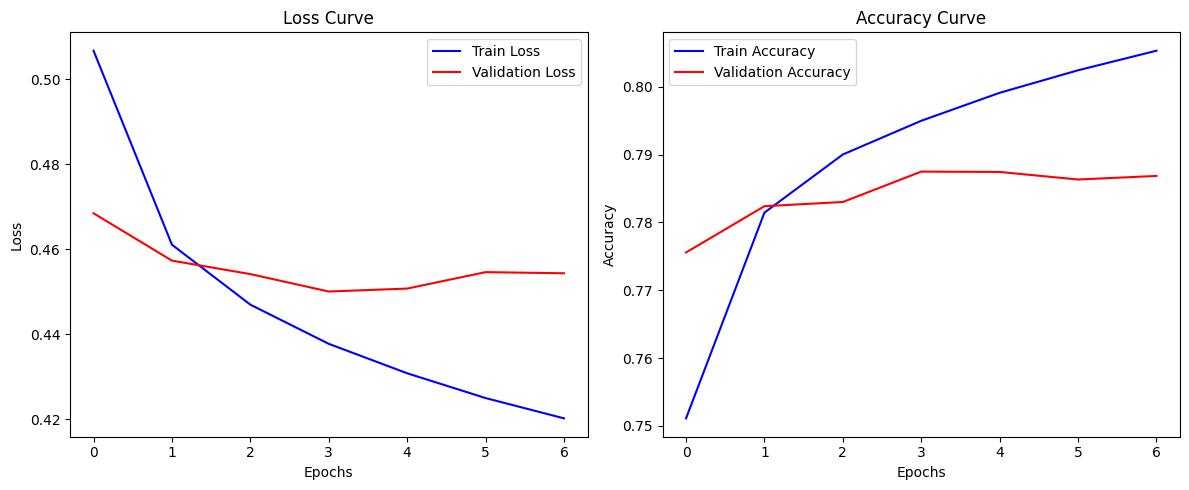

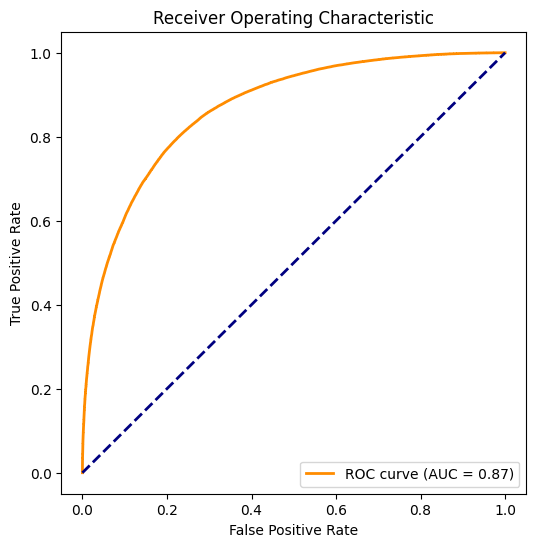

🏃 View run LSTM_GloVe_Text_Classification_Run at: http://localhost:5000/#/experiments/803906263697896924/runs/604947fe0854452b872d7b378ad26d52
🧪 View experiment at: http://localhost:5000/#/experiments/803906263697896924

 Script terminé, tout est tracké sur MLflow et le modèle est sauvegardé localement !


<Figure size 640x480 with 0 Axes>

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import mlflow
import mlflow.tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping

# Définir l'URI du serveur MLFlow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("LSTM_GloVe_Text_Classification")

# Activer l'autolog de MLflow
mlflow.tensorflow.autolog()

# Charger les données
data = data.dropna(subset=["cleaned_text_lemmatized"])  

# Séparation en train/val/test
X = data["cleaned_text_lemmatized"]
y = data["target"]  

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Fonction pour créer le corpus
def create_corpus(df):
    corpus = []
    for tweet in tqdm(df):
        words = [word.lower() for word in word_tokenize(tweet)] 
        corpus.append(words)
    return corpus

X_train_corpus = create_corpus(X_train)
X_valid_corpus = create_corpus(X_valid)
X_test_corpus = create_corpus(X_test)

# Tokenization
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(X_train_corpus)

# Sauvegarde du tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer_obj, f)

# Conversion en séquences
X_train_sequences = tokenizer_obj.texts_to_sequences(X_train_corpus)
X_valid_sequences = tokenizer_obj.texts_to_sequences(X_valid_corpus)
X_test_sequences = tokenizer_obj.texts_to_sequences(X_test_corpus)

# Padding des séquences
MAX_LEN = 50
X_train_pad = pad_sequences(X_train_sequences, maxlen=MAX_LEN, truncating='post', padding='post')
X_valid_pad = pad_sequences(X_valid_sequences, maxlen=MAX_LEN, truncating='post', padding='post')
X_test_pad = pad_sequences(X_test_sequences, maxlen=MAX_LEN, truncating='post', padding='post')

# Chargement des embeddings GloVe
embedding_index = {}
with open('./glove.6B.50d.txt', 'r', encoding='utf-8') as f:  
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Construction de la matrice d'embeddings
EMBEDDING_DIM = 50  
vocab_size = len(tokenizer_obj.word_index) + 1
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer_obj.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Début du tracking MLflow avec un nom significatif
with mlflow.start_run(run_name="LSTM_GloVe_Text_Classification_Run"):
    # Modèle LSTM
    model = Sequential([
        Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compilation du modèle
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # EarlyStopping pour stopper l'entraînement si la validation loss n'améliore pas
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Entraînement + tracking MLflow
    history = model.fit(
        X_train_pad, y_train, 
        validation_data=(X_valid_pad, y_valid), 
        epochs=10, batch_size=32, verbose=1, 
        callbacks=[early_stopping]
    )

    # Évaluation + tracking MLflow
    test_loss, test_acc = model.evaluate(X_test_pad, y_test)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_acc)

    #  Sauvegarde du modèle en local
    model.save("_model_lstm_glove.h5")
    print(" Modèle sauvegardé en local sous '_model_lstm_glove.h5'")

    #  Sauvegarde du modèle dans MLflow
    mlflow.tensorflow.log_model(model, "LSTM_GloVe_Model")

    print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

    # Prédictions + Rapport de classification
    y_pred_proba = model.predict(X_test_pad)
    y_pred = (y_pred_proba > 0.5).astype("int32")

    print("\n Rapport de classification :")
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)

    # Logging MLflow du rapport de classification
    mlflow.log_dict(report, "classification_report.json")

    # Courbes loss & accuracy
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(history.history["loss"], label="Train Loss", color='blue')
    axs[0].plot(history.history["val_loss"], label="Validation Loss", color='red')
    axs[0].set_title("Loss Curve")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(history.history["accuracy"], label="Train Accuracy", color='blue')
    axs[1].plot(history.history["val_accuracy"], label="Validation Accuracy", color='red')
    axs[1].set_title("Accuracy Curve")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # Sauvegarde des courbes sur MLflow
    fig.savefig("loss_accuracy_curves.png")
    mlflow.log_artifact("loss_accuracy_curves.png")

    #  Ajout de la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Sauvegarde de la courbe ROC
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")

print("\n Script terminé, tout est tracké sur MLflow et le modèle est sauvegardé localement !")


### Analyse des Performances du Modèle  

Le modèle affiche des performances équilibrées entre les classes, avec une **accuracy globale de 78.54%**. Voici quelques observations :  

####  Bonne homogénéité entre les classes  
- La **précision (precision)** et le **rappel (recall)** sont proches pour les deux classes, ce qui est un bon signe d’équilibre.  
- Légère différence entre les classes :  
  - **Classe 0** : Recall légèrement supérieur à la précision → ton modèle récupère bien les instances positives mais peut générer quelques faux positifs.  
  - **Classe 1** : Précision légèrement supérieure au recall → ton modèle est un peu plus sélectif pour identifier les instances positives.  

#### F1-score stable (~78.5%)  
- Une valeur proche de l’accuracy, ce qui signifie qu’il n’y a pas un fort déséquilibre entre les classes.  


### Code API

## <a href="C8">2.3 Modèle LSTM avec Word2Vec (Non Préentraîné)</a>



#####  Introduction  
J'ai entraîné un **modèle LSTM** en utilisant des **embeddings Word2Vec** pour la classification de texte.  
Afin d’optimiser les performances, j’ai comparé plusieurs versions du texte et suivi les expérimentations avec **MLflow**.

##  Méthodologie  

#####  Préparation des embeddings Word2Vec  
J’ai commencé par entraîner un **modèle Word2Vec** sur mon corpus, puis j’ai extrait une matrice d'embeddings pour l'intégrer dans l'Embedding Layer du LSTM.

#####  Prétraitement des textes  
J’ai testé trois versions du texte :  
- `cleaned_text`  
- `cleaned_text_lemmatized`  
- `cleaned_text_stemmed`  

J’ai ensuite tokenisé et appliqué un padding aux séquences.

#####  Architecture du modèle  
J’ai construit un modèle basé sur :  
- Une **couche Embedding** initialisée avec les embeddings Word2Vec.  
- Un **LSTM** avec un **dropout de 0.3** pour éviter l'overfitting.  
- Une **couche de classification** avec activation sigmoïde pour la prédiction.

#####  Expérimentations avec MLflow  
J’ai utilisé **MLflow** pour suivre les expérimentations :  
- Enregistrement des **paramètres** (`dropout_rate`, `learning_rate`…)  
- Suivi des **métriques** : `accuracy`, `loss`, `precision`, `recall`, `f1_score`  
- Sauvegarde du **meilleur modèle** selon `val_accuracy`.

#####  Évaluation finale  
J’ai évalué les performances sur l’ensemble de test en générant un **Classification Report** et en traçant la **courbe ROC** avec l’**AUC**.

##### Résultats et Conclusions  
Après avoir comparé les trois versions du texte, j’ai sélectionné celle qui donnait la **meilleure validation accuracy**.  
Grâce à **MLflow**, j’ai pu suivre et comparer facilement les performances de mes modèles, ce qui m’a permis d’optimiser mon pipeline efficacement.

---
 **Prochaine étape** : Tester des architectures plus avancées comme  **Transformer** pour améliorer encore les performances.  


100%|██████████| 50000/50000 [00:03<00:00, 14499.05it/s]


🏃 View run defiant-croc-852 at: http://localhost:5000/#/experiments/282566637774715027/runs/8883516a709b43fa8fd4fb076661b115
🧪 View experiment at: http://localhost:5000/#/experiments/282566637774715027


C:\Users\attia\python _projects\7myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025/03/06 14:06:12 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential' has no defined input shape yet.
2025/03/06 14:06:12 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/10
12498/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7333 - loss: 0.5283

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 151s 12ms/step - accuracy: 0.7333 - loss: 0.5283 - val_accuracy: 0.7581 - val_loss: 0.4940
Epoch 2/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7586 - loss: 0.4921

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 143s 11ms/step - accuracy: 0.7586 - loss: 0.4921 - val_accuracy: 0.7625 - val_loss: 0.4854
Epoch 3/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 145s 12ms/step - accuracy: 0.7621 - loss: 0.4868 - val_accuracy: 0.7605 - val_loss: 0.4921
Epoch 4/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7647 - loss: 0.4828

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 151s 12ms/step - accuracy: 0.7647 - loss: 0.4828 - val_accuracy: 0.7642 - val_loss: 0.4849
Epoch 5/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7664 - loss: 0.4784

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 164s 13ms/step - accuracy: 0.7664 - loss: 0.4784 - val_accuracy: 0.7654 - val_loss: 0.4822
Epoch 6/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 156s 12ms/step - accuracy: 0.7699 - loss: 0.4750 - val_accuracy: 0.7637 - val_loss: 0.4855
Epoch 7/10
12497/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7687 - loss: 0.4752

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 160s 13ms/step - accuracy: 0.7687 - loss: 0.4752 - val_accuracy: 0.7633 - val_loss: 0.4818
Epoch 8/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 170s 14ms/step - accuracy: 0.7707 - loss: 0.4730 - val_accuracy: 0.7653 - val_loss: 0.4823
Epoch 9/10
12496/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7714 - loss: 0.4725

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 186s 15ms/step - accuracy: 0.7714 - loss: 0.4725 - val_accuracy: 0.7667 - val_loss: 0.4802
Epoch 10/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 225s 18ms/step - accuracy: 0.7712 - loss: 0.4728 - val_accuracy: 0.7669 - val_loss: 0.4822
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


2025/03/06 14:34:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmph_u6aq3c\model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7676 - loss: 0.4781


2025/03/06 14:35:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/03/06 14:35:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpzi3ubpvf\model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/06 14:35:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step
🏃 View run indecisive-swan-579 at: http://localhost:5000/#/experiments/282566637774715027/runs/f7fa8227a7884a80af80f601c7a29a76
🧪 View experiment at: http://localhost:5000/#/experiments/282566637774715027

Fin du script, modèle et artefacts enregistrés pour le déploiement !


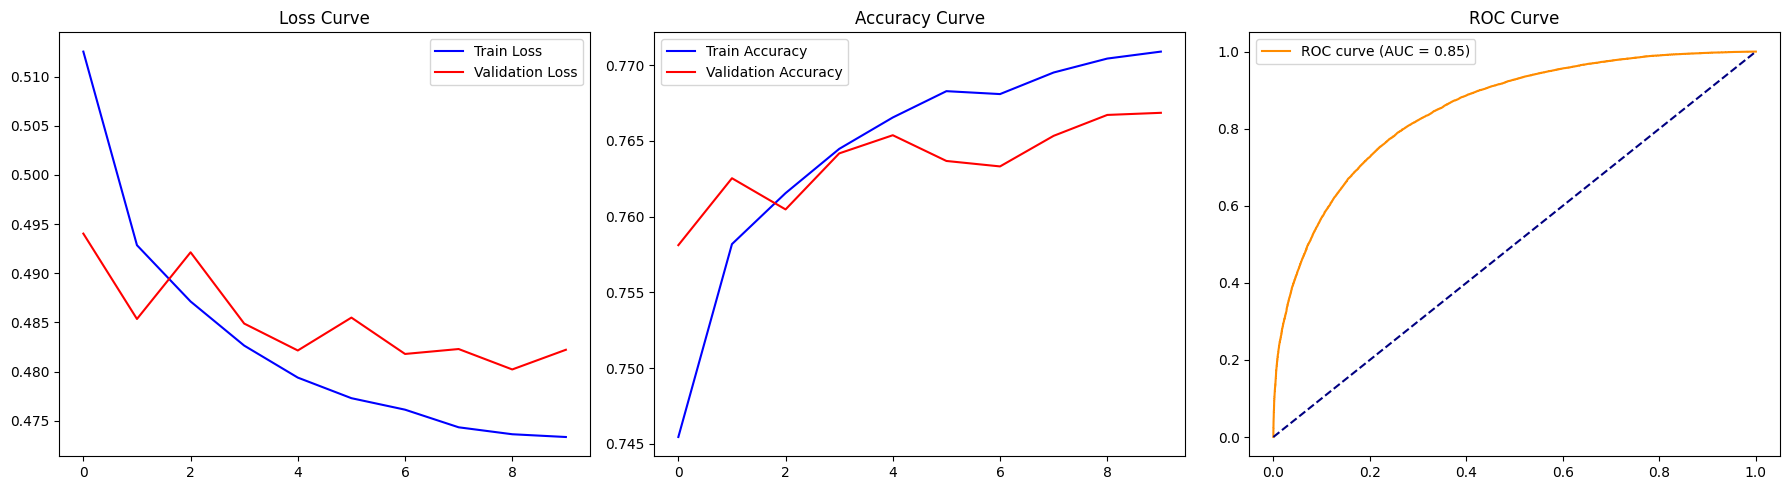

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
import mlflow
import mlflow.tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec

# Définir l'URI du serveur MLFlow
mlflow.set_tracking_uri("http://localhost:5000")
# Définir l'expérience MLflow
mlflow.set_experiment("LSTM_Word2Vec_Text_Classification")
mlflow.tensorflow.autolog()

# Charger les données et échantillonner un sous-ensemble de 500,000 exemples
data_sample = data.dropna(subset=["text_clean_stem"]).sample(n=500000, random_state=42)

# Séparer les caractéristiques et la cible
X, y = data_sample["text_clean_stem"], data_sample["target"]


# Division train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Fonction pour créer le corpus
def create_corpus(df):
    return [[word.lower() for word in word_tokenize(text)] for text in tqdm(df)]

X_train_corpus = create_corpus(X_train)
X_valid_corpus = create_corpus(X_valid)
X_test_corpus = create_corpus(X_test)

# Tokenization
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(X_train_corpus)
X_train_sequences = tokenizer_obj.texts_to_sequences(X_train_corpus)
X_valid_sequences = tokenizer_obj.texts_to_sequences(X_valid_corpus)
X_test_sequences = tokenizer_obj.texts_to_sequences(X_test_corpus)

# Padding
MAX_LEN = 50
X_train_pad = pad_sequences(X_train_sequences, maxlen=MAX_LEN, padding='post')
X_valid_pad = pad_sequences(X_valid_sequences, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_sequences, maxlen=MAX_LEN, padding='post')

# Enregistrement du tokenizer en local
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer_obj, f)

# Logging du tokenizer sur MLflow
mlflow.log_artifact("tokenizer.pkl")

# Word2Vec
word2vec_model = Word2Vec(sentences=X_train_corpus, vector_size=100, window=5, min_count=1, workers=4)
embedding_index = {word: word2vec_model.wv[word] for word in word2vec_model.wv.index_to_key}

# Matrice d'embeddings
EMBEDDING_DIM = 100
vocab_size = len(tokenizer_obj.word_index) + 1
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer_obj.word_index.items():
    if word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

# Début du tracking MLflow
mlflow.end_run()  # Termine une éventuelle session en cours
with mlflow.start_run():
    model_glove = Sequential()
    model_glove.add(Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False))
    model_glove.add(Dropout(0.2))
    model_glove.add(Conv1D(64, 5, activation='relu'))
    model_glove.add(MaxPooling1D(pool_size=4))
    model_glove.add(LSTM(100))
    model_glove.add(Dense(1, activation='sigmoid'))
    
    model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # EarlyStopping pour éviter le surapprentissage
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Entraînement du modèle
    history = model_glove.fit(X_train_pad, y_train, validation_data=(X_valid_pad, y_valid),
                              epochs=10, batch_size=32, verbose=1, callbacks=[early_stopping])
    
    # Évaluation sur le jeu de test
    test_loss, test_acc = model_glove.evaluate(X_test_pad, y_test)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_acc)
    
    # Enregistrement du modèle et des artefacts
    mlflow.tensorflow.log_model(model_glove, "LSTM_Word2Vec_Model")
    model_glove.save("LSTM_Word2Vec_Model.h5")
    mlflow.log_artifact("LSTM_Word2Vec_Model.h5")
    
    # Prédictions et ROC
    y_pred_proba = model_glove.predict(X_test_pad)
    y_pred = (y_pred_proba > 0.5).astype("int32")
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    mlflow.log_metric("roc_auc", roc_auc)
    
    # Rapport de classification
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    
    # Courbes
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].plot(history.history["loss"], label="Train Loss", color='blue')
    axs[0].plot(history.history["val_loss"], label="Validation Loss", color='red')
    axs[0].set_title("Loss Curve")
    axs[0].legend()
    
    axs[1].plot(history.history["accuracy"], label="Train Accuracy", color='blue')
    axs[1].plot(history.history["val_accuracy"], label="Validation Accuracy", color='red')
    axs[1].set_title("Accuracy Curve")
    axs[1].legend()
    
    axs[2].plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
    axs[2].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[2].set_title("ROC Curve")
    axs[2].legend()
    
    plt.tight_layout()
    plt.savefig("curves.png")
    mlflow.log_artifact("curves.png")
    
print("\nFin du script, modèle et artefacts enregistrés pour le déploiement !")


Le modèle présente des résultats assez solides, mais avec une légère différence entre les classes. La classe 2 semble être légèrement mieux classée que la classe 1, mais les différences de métriques ne sont pas énormes. Il y a donc une bonne capacité de généralisation du modèle.


## <a href="C9">2.4 Expérimentation avec le modèle BERT</a>




### **BERT (Bidirectional Encoder Representations from Transformers)**

**BERT** est un modèle de langage pré-entraîné développé par Google, basé sur l'architecture **Transformer**. Contrairement aux modèles traditionnels unidirectionnels, BERT est bidirectionnel, ce qui lui permet de mieux comprendre le contexte des mots dans une phrase grâce à des mécanismes d'attention.

Avantages :
- **Compréhension Contextuelle** : Modèle bidirectionnel permettant de capturer le contexte des mots dans une phrase.
- **Performances Élevées** : Surpasse de nombreux modèles dans des tâches de traitement du langage naturel.
- **Pré-entraînement & Fine-Tuning** : Peut être pré-entraîné sur un grand corpus et ajusté pour des tâches spécifiques.

Inconvénients :
- **Ressources Computationnelles Élevées** : Nécessite des GPU pour un entraînement et une utilisation efficaces.
- **Grande Taille du Modèle** : Les versions comme `bert-base` sont volumineuses et peuvent poser des problèmes de mémoire.


### **Description du modèle**

Je utilise un modèle **BERT pré-entraîné** (`bert-base-uncased`) de la bibliothèque **Transformers** de **Hugging Face**. Ce modèle est déjà formé sur un grand corpus de textes (notamment Wikipedia et BookCorpus), ce qui lui permet de générer des **embeddings** ou représentations vectorielles de textes. Ces embeddings sont ensuite utilisés comme entrées pour un modèle de réseau neuronal que je définis pour effectuer une tâche de **classification binaire**.



### **Résumé du Modèle**

1. **BERT pré-entraîné**  
   Le modèle BERT, pré-entraîné sur un large corpus de textes, est utilisé pour extraire des **embeddings contextuels**. Ces embeddings capturent les relations et significations profondes des mots dans leur contexte, ce qui permet une meilleure compréhension des textes.

2. **Réseau Neuronal**  
   Un modèle de réseau neuronal est ensuite construit en utilisant ces embeddings extraits par BERT. Il est composé de plusieurs couches :
   - **Dense** pour l'apprentissage des représentations complexes des données.
   - **Dropout** pour éviter le sur-apprentissage.
   - **Sigmoid** en sortie pour effectuer une **classification binaire**.

3. **MLflow**  
   **MLflow** est utilisé pour loguer les **paramètres**, les **performances** (précision, perte) et les **modèles** à chaque étape de l'expérimentation. Cela permet de suivre les différentes itérations du modèle et de gérer les versions de manière centralisée.

4. **Versions des Textes**  
   Trois versions des textes sont utilisées pour tester l'impact de la préprocessing :
   - **Nettoyées** : Textes après nettoyage de base.
   - **Lemmatisées** : Textes transformés avec des lemmes (racines des mots).
   - **Stemmées** : Textes avec les mots réduits à leur racine.
   
   Ces versions sont comparées pour analyser leur influence sur la **précision du modèle** et optimiser la performance.

---

Ce résumé décrit l'approche de ton modèle de manière détaillée et structurée pour un meilleur suivi et compréhension.


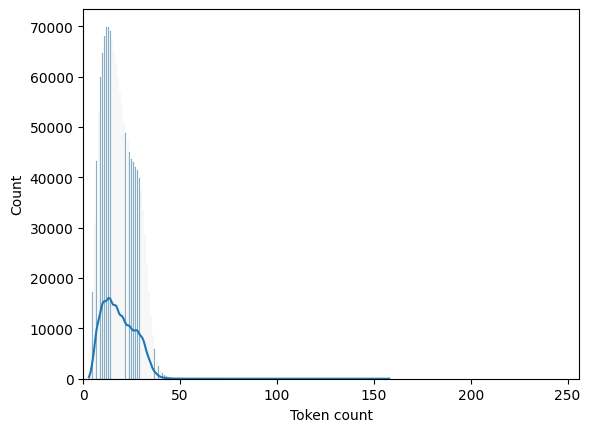

In [13]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split


# Charger les données et échantillonner
data_sample = data.dropna(subset=["cleaned_text"]).sample(n=1500000, random_state=42)

# Analyse de la distribution de la longueur des tokens
token_lens = [len(tokenizer.encode(txt, max_length=512, truncation=True)) for txt in data_sample.cleaned_text]

# Visualisation
sns.histplot(token_lens, kde=True)
plt.xlim([0, 256])
plt.xlabel('Token count')
plt.show()


### Modèle BERT pour la classification de texte

Le modèle est basé sur **BERT** (Bidirectional Encoder Representations from Transformers), un modèle pré-entraîné pour la compréhension du langage naturel.

#### Architecture :
- **BERT** : Utilisation du modèle `bert-base-uncased` pré-entraîné de la bibliothèque `transformers`.
- **Couche de Dropout** : Une couche de dropout avec un taux de 30% est appliquée pour éviter le surapprentissage.
- **Couche de Classification** : Une couche linéaire est ajoutée à la sortie de BERT pour effectuer la classification binaire (2 classes).

#### Flux de travail :
1. **Tokenisation** : Les textes sont tokenisés et convertis en `input_ids` et `attention_mask` via le tokenizer BERT.
2. **Encodage** : Les `input_ids` sont envoyés à travers BERT pour obtenir des embeddings contextuels.
3. **Dropout et Classification** : Après le passage dans BERT, un dropout est appliqué avant de passer à la couche de classification pour prédire les probabilités des deux classes.

#### Optimisation :
- **Fonction de perte** : `CrossEntropyLoss` pour la classification binaire.
- **Optimiseur** : `AdamW` pour la mise à jour des poids du modèle.


Chargement du tokenizer...
Epoch 1: Train Loss 0.4136 | Train Acc 0.8115 | Valid Loss 0.3887 | Valid Acc 0.8291
Epoch 2: Train Loss 0.2996 | Train Acc 0.8726 | Valid Loss 0.4165 | Valid Acc 0.8266
Epoch 3: Train Loss 0.1882 | Train Acc 0.9264 | Valid Loss 0.4527 | Valid Acc 0.8248
Epoch 4: Train Loss 0.1076 | Train Acc 0.9606 | Valid Loss 0.6105 | Valid Acc 0.8255
Epoch 5: Train Loss 0.0706 | Train Acc 0.9741 | Valid Loss 0.7065 | Valid Acc 0.8164


2025/03/09 17:02:42 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\attia\AppData\Local\Temp\tmpb42skdgs\model\data, flavor: pytorch). Fall back to return ['torch==2.6.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/09 17:02:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run BERT_Text_Classification_Run at: http://localhost:5000/#/experiments/539475255797234418/runs/5dd33dca802b416fbe8b3e3f2f3c43ce
🧪 View experiment at: http://localhost:5000/#/experiments/539475255797234418


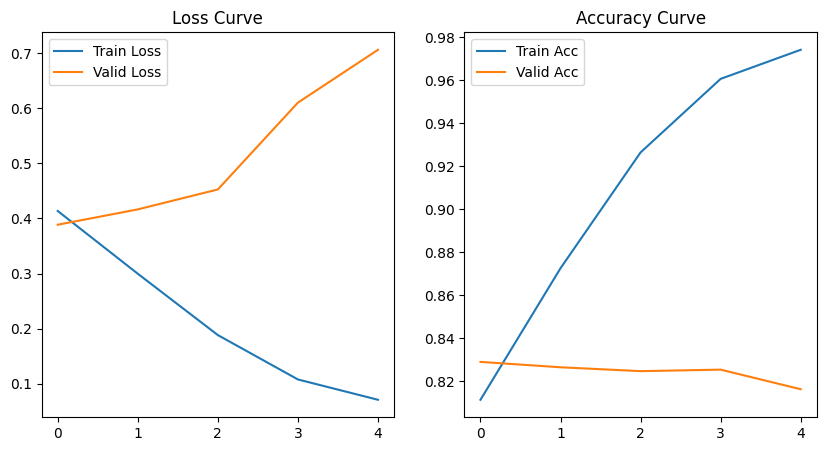

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow
import mlflow.pytorch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

# Paramètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 50  # Longueur max des séquences
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5

# Initialisation du tokenizer
print("Chargement du tokenizer...")
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Chargement et préparation des données
data_sample = data.dropna(subset=["cleaned_text"]).sample(n=100000, random_state=42)
X, y = data_sample["cleaned_text"], data_sample["target"].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Création d'un Dataset personnalisé
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.tolist()
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        encoding = self.tokenizer(
            self.texts[item],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[item], dtype=torch.long)
        }

# Dataloaders
train_dataset = TextDataset(X_train, y_train, tokenizer, MAX_LEN)
valid_dataset = TextDataset(X_valid, y_valid, tokenizer, MAX_LEN)
test_dataset = TextDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Définition du modèle de classification
class BertClassifier(nn.Module):
    def __init__(self, bert_model):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 2)  # Classification binaire
    
    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.pooler_output
        return self.out(self.drop(pooled_output))

# Initialisation du modèle
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = BertClassifier(bert_model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Initialisation MLflow avec un nom significatif
mlflow.end_run()
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("BERT_Text_Classification")
mlflow.start_run(run_name="BERT_Text_Classification_Run")
mlflow.log_params({
    "Model": PRE_TRAINED_MODEL_NAME,
    "Max Length": MAX_LEN,
    "Batch Size": BATCH_SIZE,
    "Epochs": EPOCHS,
    "Learning Rate": LEARNING_RATE
})

# Entraînement du modèle
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs):
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
        
        train_loss /= len(train_loader)
        train_acc = correct / len(train_dataset)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation
        model.eval()
        valid_loss, correct = 0, 0
        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()
        
        valid_loss /= len(valid_loader)
        valid_acc = correct / len(valid_dataset)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)
        
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | Valid Loss {valid_loss:.4f} | Valid Acc {valid_acc:.4f}")
        mlflow.log_metrics({"train_loss": train_loss, "train_acc": train_acc, "valid_loss": valid_loss, "valid_acc": valid_acc}, step=epoch)
    
    return history

if __name__ == "__main__":
    history = train_model(model, train_loader, valid_loader, criterion, optimizer, EPOCHS)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['valid_loss'], label='Valid Loss')
    plt.legend()
    plt.title("Loss Curve")
    mlflow.log_figure(plt.gcf(), "loss_curve.png")
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['valid_acc'], label='Valid Acc')
    plt.legend()
    plt.title("Accuracy Curve")
    mlflow.log_figure(plt.gcf(), "accuracy_curve.png")
    
    mlflow.pytorch.log_model(model, "bert_model")
    mlflow.end_run()


In [27]:
import mlflow
import mlflow.pytorch
from sklearn.metrics import classification_report, accuracy_score

# Charger le modèle BERT enregistré depuis MLflow
model_uri = "runs:/5dd33dca802b416fbe8b3e3f2f3c43ce/bert_model"  # Remplacez <run_id> par l'ID du run MLflow où le modèle a été enregistré
model = mlflow.pytorch.load_model(model_uri)

# Évaluation du modèle sur le jeu de test
model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids, attention_mask)
        preds = outputs.argmax(1)
        
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Affichage du rapport de classification
print("Classification Report:\n", classification_report(y_true, y_pred))

# Optionnel: Affichage de la précision
print("Accuracy Score: ", accuracy_score(y_true, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      4977
           1       0.84      0.78      0.81      5023

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

Accuracy Score:  0.8133


###  Interprétation des résultats

####  Bonnes performances en entraînement :
- **Train Accuracy** monte de 81.15% (Epoch 1) à 97.41% (Epoch 5).
- **Train Loss** diminue fortement (0.41 → 0.07), ce qui indique une bonne capacité d'apprentissage du modèle.

####  Problème en validation :
- **Valid Accuracy** reste stable autour de 82-83%, mais **Valid Loss** augmente (0.38 → 0.70).
- Cela suggère un **sur-apprentissage (overfitting)** : le modèle s’adapte trop aux données d’entraînement et généralise moins bien aux nouvelles données.

####  Points d'amélioration :
- Réduire le sur-apprentissage en appliquant plus de régularisation (Dropout, data augmentation).
- Tester un **early stopping** pour stopper l'entraînement avant la détérioration en validation.
- Ajuster le **learning rate** ou réduire le nombre d’époques pour éviter un sur-apprentissage trop rapide.

####  Prochaines étapes :
- Essayer d’autres modèles ou ajuster les hyperparamètres pour améliorer la généralisation.

####  Globalement, BERT apprend bien, mais il faut corriger le sur-apprentissage pour des performances plus robustes en production ! 🚀


## <a href="C10">3.Mise en Œuvre de l'API et du Déploiement</a>


In [ ]:


import os
import re
import logging
from pathlib import Path
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, field_validator
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Configuration des journaux
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Assurer que nltk_data est bien accessible (doit être géré par le YAML)
NLTK_DATA_PATH = os.getenv("NLTK_DATA", os.path.join(os.getcwd(), "myenv", "nltk_data"))  # Ajuste ce chemin selon ton environnement
nltk.data.path = [NLTK_DATA_PATH]
#nltk.data.path.append(NLTK_DATA_PATH)

# Téléchargement des ressources nécessaires
RESOURCES = ['wordnet', 'omw-1.4', 'stopwords', 'punkt', 'punkt_tab']
for resource in RESOURCES:
    try:
        nltk.data.find(f"tokenizers/{resource}" if resource in ['punkt', 'punkt_tab'] else f"corpora/{resource}")
    except LookupError:
        logging.info(f"Téléchargement du package NLTK : {resource}")
        nltk.download(resource, download_dir=NLTK_DATA_PATH)



# Initialisation de l'analyseur lexical et des stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text: str) -> str:
    """Nettoie le texte en supprimant les caractères spéciaux et les chiffres."""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Supprime la ponctuation
    text = re.sub(r'\d+', '', text)  # Supprime les chiffres
    return text

def preprocess_text(text: str) -> str:
    """Prépare le texte en le nettoyant, le tokenisant et en le lemmatisant."""
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Création de l'application FastAPI
app = FastAPI()

@app.get("/")
async def root():
    return {"message": "Bienvenue sur l'API d'Analyse de Sentiments !"}

# Chargement du modèle
MODEL_PATH = "best_model.pkl"
try:
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"Le fichier {MODEL_PATH} est introuvable.")
    pipeline = joblib.load(MODEL_PATH)
except Exception as e:
    logging.error(f"Erreur lors du chargement du modèle : {e}")
    raise RuntimeError(f"Échec du chargement du modèle : {e}")



class InputData(BaseModel):
    text: str

    @field_validator('text')
    def validate_text(cls, v):
        """Valide que le texte n'est pas vide et n'est pas un nombre."""
        
        # Vérifie si v est vide après avoir retiré les espaces
        if not v.strip():   
            raise HTTPException(status_code=400, detail="Le texte ne peut pas être vide.")
        
        # Vérifie si v est un nombre (int ou float)
        try:
            # Tente de convertir le texte en float pour voir s'il s'agit d'un nombre
            float(v)  
            raise HTTPException(status_code=400, detail="Le texte ne peut pas être un nombre.")
        except ValueError:
            # Si une exception est levée, cela signifie que v n'est pas un nombre
            pass
        
        return v
@app.post("/predict/")
async def predict(input_data: InputData):
    """Prédit le sentiment d'un texte."""
    try:
        # Prétraitement du texte
        cleaned_text = preprocess_text(input_data.text)
        
        # Prédiction avec le modèle
        predictions = pipeline.predict([cleaned_text])
        sentiment = "Positive" if predictions[0] == 1 else "Negative"
        
        # Retour de la réponse
        return {"prediction": int(predictions[0]), "sentiment": sentiment}
    except ValueError as ve:
        logging.error(f"Erreur lors de la prédiction : {ve}")
        raise HTTPException(status_code=400, detail=str(ve))
    except Exception as e:
        logging.error(f"Erreur lors de la prédiction : {e}")
        raise HTTPException(status_code=500, detail=str(e))

 #Lancer l'API avec Uvicorn
if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)







